### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Cab_env import CabDriver

Using TensorFlow backend.


([20], [[0, 0]])


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
Time_matrix[1,2,:,6]

array([7., 7., 7., 7., 7., 7., 4., 4., 4., 4., 4., 4., 2., 2., 2., 2., 2.,
       2., 8., 8., 8., 8., 8., 8.])

#### Tracking the state-action pairs for checking convergence


In [3]:

States_track = collections.defaultdict(dict)
print(len(States_track))

0


In [4]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [((0, 0, 0), (0,1)), ((0, 0, 0), (0,2))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = [] 

In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

## Architecture Detail:
### - The input to the NN is only the state and its output is the Q-value of every possible action. 

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size, discount_factor=0.95, learning_rate=0.001,
                 epsilon=1, epsilon_decay=0.0003, epsilon_min=0.00001):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon_max = epsilon
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.batch_size = 32
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets   
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, action_space, possible_actions_index):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            index = random.randrange(len(possible_actions_index))
            action_index = possible_actions_index[index]
            action = action_space[action_index]
            return action_index, action

        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size

            state = np.array(state).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            #print("action picked from compile model = {}".format(q_value))

            return np.argmax(q_value[0]), action_space[np.argmax(q_value[0])]

    def append_sample(self, state, action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        # print("trying training model")
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)

            update_output = np.zeros((self.batch_size, self.state_size))  # write here
            update_input = np.zeros((self.batch_size, self.state_size))  # write here

            actions, rewards = [], []

            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state

                # Write your code from here
                # 1. Predict the target from earlier model
                target = self.model.predict(update_input)

                # 2. Get the target for the Q-network
                target_qval = self.model.predict(update_output)

                # 3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                ### do we need to handle terminal state. termination function here is independent
                #  from actions and state so we can ignore it

                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def store_q_values(self):
        """ We are keeping track of q value for state [0,0,0] and action (0,2)"""
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][2])
            
    def save(self, name):
        self.model.save(name)
    

In [7]:
Episodes = 20000


### DQN block

In [8]:
start_time = time.time()
rewards_per_episode, episodes, avg_rewards_per_episode = [], [], []

env = CabDriver()
agent = DQNAgent(action_size=len(env.action_space), state_size=len(env.state_encod_arch1(
    env.state_init)))

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    score = 0
    # Call all the initialised variables of the environment
    action_space, state_space, state = env.reset()

    terminal_state = False
    t = 0
    count = 1
    while not terminal_state:
        #print("count = {}".format(count))
        count += 1
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_index, actions = env.requests(state)
        action_index, action = agent.get_action(env.state_encod_arch1(state), env.action_space, possible_actions_index)
        # 2. Evaluate your reward and next state
        next_state, wait_time, transit_time, ride_time = env.next_state_func(state, action,
                                                                             Time_matrix)
        reward = env.reward_func(state, action, Time_matrix)
        # 3. Append the experience to the memory
        agent.append_sample(env.state_encod_arch1(state), action_index,
                            reward, env.state_encod_arch1(next_state))
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state
        t += wait_time + transit_time + ride_time
        #print(t)
        # TODO Do we need a logic to make sure that total time never goes more than 30 days. Which
        # TODO requires last ride to be less than the time left
        # TODO OR we not very hard strict with 30 days, driver can even work extra few hour just
        # TODO because of last ride
        if t >= 24 * 30:
            print("state terminated")
            terminal_state = True

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                           score,
                                                                           len(agent.memory),
                                                                           agent.epsilon))
    # every few episodes:
    if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        agent.store_q_values()
    if episode % 1000 == 0:
        agent.save(name="model.pkl")
        elapsed_time = time.time() - start_time
        print('Total time taken ',elapsed_time)
### TODO Keep a track of Q-values, loss

state terminated
episode 0, reward -675.0, memory_length 139, epsilon 1.0
Total time taken  3.0820109844207764
state terminated
episode 1, reward 85.0, memory_length 292, epsilon 0.9997000479950504
state terminated
episode 2, reward -306.0, memory_length 425, epsilon 0.9994001859622058
state terminated
episode 3, reward 103.0, memory_length 573, epsilon 0.9991004138744786
state terminated
episode 4, reward -188.0, memory_length 697, epsilon 0.9988007317048893
state terminated
episode 5, reward -402.0, memory_length 829, epsilon 0.9985011394264665
state terminated
episode 6, reward -405.0, memory_length 972, epsilon 0.998201637012247
state terminated
episode 7, reward -117.0, memory_length 1134, epsilon 0.9979022244352754
state terminated
episode 8, reward -474.0, memory_length 1274, epsilon 0.9976029016686048
state terminated
episode 9, reward -567.0, memory_length 1448, epsilon 0.997303668685296
state terminated
episode 10, reward -120.0, memory_length 1583, epsilon 0.997004525458418


state terminated
episode 91, reward -197.0, memory_length 2000, epsilon 0.9730695462559861
state terminated
episode 92, reward -213.0, memory_length 2000, epsilon 0.9727776721754104
state terminated
episode 93, reward -280.0, memory_length 2000, epsilon 0.9724858856439259
state terminated
episode 94, reward -142.0, memory_length 2000, epsilon 0.9721941866352718
state terminated
episode 95, reward -314.0, memory_length 2000, epsilon 0.9719025751231951
state terminated
episode 96, reward 18.0, memory_length 2000, epsilon 0.9716110510814508
state terminated
episode 97, reward -217.0, memory_length 2000, epsilon 0.9713196144838019
state terminated
episode 98, reward -140.0, memory_length 2000, epsilon 0.9710282653040188
state terminated
episode 99, reward -180.0, memory_length 2000, epsilon 0.9707370035158802
state terminated
episode 100, reward 90.0, memory_length 2000, epsilon 0.9704458290931727
state terminated
episode 101, reward -146.0, memory_length 2000, epsilon 0.9701547420096904
s

state terminated
episode 181, reward 8.0, memory_length 2000, epsilon 0.9471484480208344
state terminated
episode 182, reward -36.0, memory_length 2000, epsilon 0.9468643491033965
state terminated
episode 183, reward 50.0, memory_length 2000, epsilon 0.9465803354028507
state terminated
episode 184, reward 0.0, memory_length 2000, epsilon 0.9462964068936357
state terminated
episode 185, reward -115.0, memory_length 2000, epsilon 0.946012563550198
state terminated
episode 186, reward 49.0, memory_length 2000, epsilon 0.9457288053469916
state terminated
episode 187, reward -300.0, memory_length 2000, epsilon 0.9454451322584783
state terminated
episode 188, reward -232.0, memory_length 2000, epsilon 0.9451615442591275
state terminated
episode 189, reward -196.0, memory_length 2000, epsilon 0.9448780413234165
state terminated
episode 190, reward -43.0, memory_length 2000, epsilon 0.9445946234258297
state terminated
episode 191, reward -11.0, memory_length 2000, epsilon 0.9443112905408597
st

state terminated
episode 272, reward 331.0, memory_length 2000, epsilon 0.9216413247859999
state terminated
episode 273, reward -222.0, memory_length 2000, epsilon 0.9213648768578268
state terminated
episode 274, reward -116.0, memory_length 2000, epsilon 0.9210885118515929
state terminated
episode 275, reward 265.0, memory_length 2000, epsilon 0.9208122297424259
state terminated
episode 276, reward -40.0, memory_length 2000, epsilon 0.9205360305054603
state terminated
episode 277, reward 418.0, memory_length 2000, epsilon 0.920259914115838
state terminated
episode 278, reward -306.0, memory_length 2000, epsilon 0.9199838805487086
state terminated
episode 279, reward 198.0, memory_length 2000, epsilon 0.919707929779229
state terminated
episode 280, reward 179.0, memory_length 2000, epsilon 0.9194320617825638
state terminated
episode 281, reward 43.0, memory_length 2000, epsilon 0.9191562765338847
state terminated
episode 282, reward -140.0, memory_length 2000, epsilon 0.918880574008371

state terminated
episode 363, reward 291.0, memory_length 2000, epsilon 0.8968211268228365
state terminated
episode 364, reward -47.0, memory_length 2000, epsilon 0.896552123837255
state terminated
episode 365, reward -351.0, memory_length 2000, epsilon 0.8962832015404654
state terminated
episode 366, reward 72.0, memory_length 2000, epsilon 0.8960143599082643
state terminated
episode 367, reward 102.0, memory_length 2000, epsilon 0.8957455989164563
state terminated
episode 368, reward 471.0, memory_length 2000, epsilon 0.8954769185408529
state terminated
episode 369, reward 74.0, memory_length 2000, epsilon 0.8952083187572727
state terminated
episode 370, reward -20.0, memory_length 2000, epsilon 0.8949397995415417
state terminated
episode 371, reward 129.0, memory_length 2000, epsilon 0.8946713608694933
state terminated
episode 372, reward -53.0, memory_length 2000, epsilon 0.8944030027169682
state terminated
episode 373, reward -63.0, memory_length 2000, epsilon 0.8941347250598136
s

state terminated
episode 454, reward 89.0, memory_length 2000, epsilon 0.8726693547370964
state terminated
episode 455, reward 342.0, memory_length 2000, epsilon 0.8724075961964195
state terminated
episode 456, reward 337.0, memory_length 2000, epsilon 0.8721459161715269
state terminated
episode 457, reward 486.0, memory_length 2000, epsilon 0.8718843146388674
state terminated
episode 458, reward 174.0, memory_length 2000, epsilon 0.8716227915748967
state terminated
episode 459, reward 243.0, memory_length 2000, epsilon 0.8713613469560779
state terminated
episode 460, reward 508.0, memory_length 2000, epsilon 0.8710999807588808
state terminated
episode 461, reward 301.0, memory_length 2000, epsilon 0.8708386929597827
state terminated
episode 462, reward 452.0, memory_length 2000, epsilon 0.8705774835352675
state terminated
episode 463, reward 214.0, memory_length 2000, epsilon 0.8703163524618265
state terminated
episode 464, reward 534.0, memory_length 2000, epsilon 0.8700552997159576


state terminated
episode 545, reward 408.0, memory_length 2000, epsilon 0.8491680073365939
state terminated
episode 546, reward 125.0, memory_length 2000, epsilon 0.8489132981426823
state terminated
episode 547, reward 85.0, memory_length 2000, epsilon 0.8486586653500682
state terminated
episode 548, reward 98.0, memory_length 2000, epsilon 0.8484041089358345
state terminated
episode 549, reward 409.0, memory_length 2000, epsilon 0.8481496288770711
state terminated
episode 550, reward 130.0, memory_length 2000, epsilon 0.847895225150875
state terminated
episode 551, reward 82.0, memory_length 2000, epsilon 0.8476408977343496
state terminated
episode 552, reward 561.0, memory_length 2000, epsilon 0.8473866466046057
state terminated
episode 553, reward 503.0, memory_length 2000, epsilon 0.8471324717387604
state terminated
episode 554, reward 399.0, memory_length 2000, epsilon 0.8468783731139383
state terminated
episode 555, reward 652.0, memory_length 2000, epsilon 0.8466243507072703
sta

state terminated
episode 636, reward 582.0, memory_length 2000, epsilon 0.8262995682142655
state terminated
episode 637, reward 490.0, memory_length 2000, epsilon 0.8260517185231138
state terminated
episode 638, reward 322.0, memory_length 2000, epsilon 0.8258039431757173
state terminated
episode 639, reward 629.0, memory_length 2000, epsilon 0.8255562421497762
state terminated
episode 640, reward 308.0, memory_length 2000, epsilon 0.8253086154229975
state terminated
episode 641, reward 227.0, memory_length 2000, epsilon 0.8250610629730948
state terminated
episode 642, reward 569.0, memory_length 2000, epsilon 0.8248135847777882
state terminated
episode 643, reward 250.0, memory_length 2000, epsilon 0.8245661808148047
state terminated
episode 644, reward 724.0, memory_length 2000, epsilon 0.8243188510618783
state terminated
episode 645, reward 290.0, memory_length 2000, epsilon 0.8240715954967489
state terminated
episode 646, reward 617.0, memory_length 2000, epsilon 0.8238244140971637

state terminated
episode 727, reward 378.0, memory_length 2000, epsilon 0.8040469926925548
state terminated
episode 728, reward 153.0, memory_length 2000, epsilon 0.8038058177727938
state terminated
episode 729, reward 648.0, memory_length 2000, epsilon 0.803564715194657
state terminated
episode 730, reward 457.0, memory_length 2000, epsilon 0.803323684936445
state terminated
episode 731, reward 516.0, memory_length 2000, epsilon 0.8030827269764652
state terminated
episode 732, reward 666.0, memory_length 2000, epsilon 0.8028418412930315
state terminated
episode 733, reward 111.0, memory_length 2000, epsilon 0.802601027864464
state terminated
episode 734, reward 564.0, memory_length 2000, epsilon 0.8023602866690894
state terminated
episode 735, reward 423.0, memory_length 2000, epsilon 0.8021196176852414
state terminated
episode 736, reward 159.0, memory_length 2000, epsilon 0.8018790208912593
state terminated
episode 737, reward 585.0, memory_length 2000, epsilon 0.8016384962654898
st

state terminated
episode 818, reward 669.0, memory_length 2000, epsilon 0.7823936951193962
state terminated
episode 819, reward 585.0, memory_length 2000, epsilon 0.7821590152146062
state terminated
episode 820, reward 608.0, memory_length 2000, epsilon 0.781924405703228
state terminated
episode 821, reward 944.0, memory_length 2000, epsilon 0.781689866564147
state terminated
episode 822, reward 332.0, memory_length 2000, epsilon 0.7814553977762544
state terminated
episode 823, reward 469.0, memory_length 2000, epsilon 0.7812209993184481
state terminated
episode 824, reward 467.0, memory_length 2000, epsilon 0.7809866711696325
state terminated
episode 825, reward 352.0, memory_length 2000, epsilon 0.7807524133087176
state terminated
episode 826, reward 360.0, memory_length 2000, epsilon 0.7805182257146205
state terminated
episode 827, reward 854.0, memory_length 2000, epsilon 0.7802841083662643
state terminated
episode 828, reward 314.0, memory_length 2000, epsilon 0.7800500612425784
s

state terminated
episode 909, reward 505.0, memory_length 2000, epsilon 0.7613235365063264
state terminated
episode 910, reward 544.0, memory_length 2000, epsilon 0.761095176701058
state terminated
episode 911, reward 314.0, memory_length 2000, epsilon 0.760866885393456
state terminated
episode 912, reward 335.0, memory_length 2000, epsilon 0.7606386625629742
state terminated
episode 913, reward 551.0, memory_length 2000, epsilon 0.7604105081890725
state terminated
episode 914, reward 708.0, memory_length 2000, epsilon 0.7601824222512171
state terminated
episode 915, reward 470.0, memory_length 2000, epsilon 0.7599544047288803
state terminated
episode 916, reward 630.0, memory_length 2000, epsilon 0.7597264556015404
state terminated
episode 917, reward 785.0, memory_length 2000, epsilon 0.7594985748486819
state terminated
episode 918, reward 647.0, memory_length 2000, epsilon 0.7592707624497957
state terminated
episode 919, reward 494.0, memory_length 2000, epsilon 0.7590430183843786
s

state terminated
episode 1000, reward 575.0, memory_length 2000, epsilon 0.740820812499511
Total time taken  3235.0312819480896
state terminated
episode 1001, reward 810.0, memory_length 2000, epsilon 0.7405986025889144
state terminated
episode 1002, reward 713.0, memory_length 2000, epsilon 0.7403764593312925
state terminated
episode 1003, reward 563.0, memory_length 2000, epsilon 0.7401543827066523
state terminated
episode 1004, reward 305.0, memory_length 2000, epsilon 0.7399323726950071
state terminated
episode 1005, reward 619.0, memory_length 2000, epsilon 0.739710429276376
state terminated
episode 1006, reward 270.0, memory_length 2000, epsilon 0.739488552430784
state terminated
episode 1007, reward 981.0, memory_length 2000, epsilon 0.7392667421382623
state terminated
episode 1008, reward 981.0, memory_length 2000, epsilon 0.7390449983788477
state terminated
episode 1009, reward 603.0, memory_length 2000, epsilon 0.7388233211325836
state terminated
episode 1010, reward 714.0, m

state terminated
episode 1089, reward 1019.0, memory_length 2000, epsilon 0.7213028876005225
state terminated
episode 1090, reward 877.0, memory_length 2000, epsilon 0.7210865321891767
state terminated
episode 1091, reward 765.0, memory_length 2000, epsilon 0.7208702416747194
state terminated
episode 1092, reward 639.0, memory_length 2000, epsilon 0.7206540160376842
state terminated
episode 1093, reward 702.0, memory_length 2000, epsilon 0.7204378552586109
state terminated
episode 1094, reward 474.0, memory_length 2000, epsilon 0.7202217593180452
state terminated
episode 1095, reward 832.0, memory_length 2000, epsilon 0.7200057281965382
state terminated
episode 1096, reward 963.0, memory_length 2000, epsilon 0.7197897618746473
state terminated
episode 1097, reward 971.0, memory_length 2000, epsilon 0.7195738603329355
state terminated
episode 1098, reward 583.0, memory_length 2000, epsilon 0.7193580235519714
state terminated
episode 1099, reward 931.0, memory_length 2000, epsilon 0.7191

state terminated
episode 1179, reward 896.0, memory_length 2000, epsilon 0.7020885405775186
state terminated
episode 1180, reward 516.0, memory_length 2000, epsilon 0.7018779486057204
state terminated
episode 1181, reward 973.0, memory_length 2000, epsilon 0.7016674198020383
state terminated
episode 1182, reward 799.0, memory_length 2000, epsilon 0.7014569541475243
state terminated
episode 1183, reward 968.0, memory_length 2000, epsilon 0.7012465516232367
state terminated
episode 1184, reward 781.0, memory_length 2000, epsilon 0.7010362122102393
state terminated
episode 1185, reward 975.0, memory_length 2000, epsilon 0.7008259358896014
state terminated
episode 1186, reward 1075.0, memory_length 2000, epsilon 0.7006157226423982
state terminated
episode 1187, reward 593.0, memory_length 2000, epsilon 0.7004055724497105
state terminated
episode 1188, reward 678.0, memory_length 2000, epsilon 0.7001954852926248
state terminated
episode 1189, reward 741.0, memory_length 2000, epsilon 0.6999

state terminated
episode 1268, reward 845.0, memory_length 2000, epsilon 0.6835910834710963
state terminated
episode 1269, reward 831.0, memory_length 2000, epsilon 0.6833860399041278
state terminated
episode 1270, reward 926.0, memory_length 2000, epsilon 0.6831810578410036
state terminated
episode 1271, reward 279.0, memory_length 2000, epsilon 0.6829761372632748
state terminated
episode 1272, reward 931.0, memory_length 2000, epsilon 0.6827712781524988
state terminated
episode 1273, reward 693.0, memory_length 2000, epsilon 0.6825664804902384
state terminated
episode 1274, reward 928.0, memory_length 2000, epsilon 0.6823617442580617
state terminated
episode 1275, reward 932.0, memory_length 2000, epsilon 0.6821570694375424
state terminated
episode 1276, reward 707.0, memory_length 2000, epsilon 0.6819524560102598
state terminated
episode 1277, reward 1014.0, memory_length 2000, epsilon 0.6817479039577988
state terminated
episode 1278, reward 820.0, memory_length 2000, epsilon 0.6815

state terminated
episode 1357, reward 696.0, memory_length 2000, epsilon 0.665580973434309
state terminated
episode 1358, reward 767.0, memory_length 2000, epsilon 0.6653813320899776
state terminated
episode 1359, reward 1011.0, memory_length 2000, epsilon 0.6651817506290666
state terminated
episode 1360, reward 864.0, memory_length 2000, epsilon 0.6649822290336137
state terminated
episode 1361, reward 966.0, memory_length 2000, epsilon 0.6647827672856618
state terminated
episode 1362, reward 944.0, memory_length 2000, epsilon 0.6645833653672593
state terminated
episode 1363, reward 1087.0, memory_length 2000, epsilon 0.6643840232604603
state terminated
episode 1364, reward 836.0, memory_length 2000, epsilon 0.6641847409473237
state terminated
episode 1365, reward 906.0, memory_length 2000, epsilon 0.6639855184099142
state terminated
episode 1366, reward 1168.0, memory_length 2000, epsilon 0.663786355630302
state terminated
episode 1367, reward 450.0, memory_length 2000, epsilon 0.6635

state terminated
episode 1446, reward 908.0, memory_length 2000, epsilon 0.6480453704770478
state terminated
episode 1447, reward 806.0, memory_length 2000, epsilon 0.6478509890245804
state terminated
episode 1448, reward 899.0, memory_length 2000, epsilon 0.6476566658778025
state terminated
episode 1449, reward 950.0, memory_length 2000, epsilon 0.6474624010192249
state terminated
episode 1450, reward 1328.0, memory_length 2000, epsilon 0.6472681944313639
state terminated
episode 1451, reward 861.0, memory_length 2000, epsilon 0.6470740460967407
state terminated
episode 1452, reward 695.0, memory_length 2000, epsilon 0.6468799559978822
state terminated
episode 1453, reward 783.0, memory_length 2000, epsilon 0.6466859241173202
state terminated
episode 1454, reward 1095.0, memory_length 2000, epsilon 0.6464919504375917
state terminated
episode 1455, reward 917.0, memory_length 2000, epsilon 0.6462980349412393
state terminated
episode 1456, reward 948.0, memory_length 2000, epsilon 0.646

state terminated
episode 1535, reward 922.0, memory_length 2000, epsilon 0.6309717729006522
state terminated
episode 1536, reward 1128.0, memory_length 2000, epsilon 0.6307825127592228
state terminated
episode 1537, reward 821.0, memory_length 2000, epsilon 0.6305933093873198
state terminated
episode 1538, reward 994.0, memory_length 2000, epsilon 0.6304041627679151
state terminated
episode 1539, reward 675.0, memory_length 2000, epsilon 0.6302150728839855
state terminated
episode 1540, reward 1140.0, memory_length 2000, epsilon 0.6300260397185128
state terminated
episode 1541, reward 400.0, memory_length 2000, epsilon 0.6298370632544843
state terminated
episode 1542, reward 714.0, memory_length 2000, epsilon 0.6296481434748917
state terminated
episode 1543, reward 966.0, memory_length 2000, epsilon 0.6294592803627326
state terminated
episode 1544, reward 1124.0, memory_length 2000, epsilon 0.6292704739010091
state terminated
episode 1545, reward 930.0, memory_length 2000, epsilon 0.62

state terminated
episode 1624, reward 943.0, memory_length 2000, epsilon 0.614348008385045
state terminated
episode 1625, reward 826.0, memory_length 2000, epsilon 0.6141637346249755
state terminated
episode 1626, reward 831.0, memory_length 2000, epsilon 0.6139795161387426
state terminated
episode 1627, reward 901.0, memory_length 2000, epsilon 0.6137953529097666
state terminated
episode 1628, reward 1107.0, memory_length 2000, epsilon 0.6136112449214727
state terminated
episode 1629, reward 1099.0, memory_length 2000, epsilon 0.6134271921572912
state terminated
episode 1630, reward 988.0, memory_length 2000, epsilon 0.6132431946006576
state terminated
episode 1631, reward 1101.0, memory_length 2000, epsilon 0.6130592522350119
state terminated
episode 1632, reward 1074.0, memory_length 2000, epsilon 0.6128753650437991
state terminated
episode 1633, reward 1213.0, memory_length 2000, epsilon 0.6126915330104697
state terminated
episode 1634, reward 983.0, memory_length 2000, epsilon 0.6

state terminated
episode 1713, reward 1025.0, memory_length 2000, epsilon 0.5981622253106904
state terminated
episode 1714, reward 924.0, memory_length 2000, epsilon 0.5979828065572558
state terminated
episode 1715, reward 1091.0, memory_length 2000, epsilon 0.5978034416213743
state terminated
episode 1716, reward 899.0, memory_length 2000, epsilon 0.5976241304869029
state terminated
episode 1717, reward 1113.0, memory_length 2000, epsilon 0.5974448731377037
state terminated
episode 1718, reward 778.0, memory_length 2000, epsilon 0.5972656695576433
state terminated
episode 1719, reward 1278.0, memory_length 2000, epsilon 0.5970865197305938
state terminated
episode 1720, reward 1376.0, memory_length 2000, epsilon 0.5969074236404314
state terminated
episode 1721, reward 1153.0, memory_length 2000, epsilon 0.5967283812710373
state terminated
episode 1722, reward 1147.0, memory_length 2000, epsilon 0.5965493926062982
state terminated
episode 1723, reward 1326.0, memory_length 2000, epsilon

state terminated
episode 1802, reward 984.0, memory_length 2000, epsilon 0.582402884309192
state terminated
episode 1803, reward 1349.0, memory_length 2000, epsilon 0.5822281926489584
state terminated
episode 1804, reward 999.0, memory_length 2000, epsilon 0.5820535533883626
state terminated
episode 1805, reward 1298.0, memory_length 2000, epsilon 0.581878966511687
state terminated
episode 1806, reward 1027.0, memory_length 2000, epsilon 0.5817044320032188
state terminated
episode 1807, reward 1392.0, memory_length 2000, epsilon 0.5815299498472499
state terminated
episode 1808, reward 1336.0, memory_length 2000, epsilon 0.5813555200280767
state terminated
episode 1809, reward 756.0, memory_length 2000, epsilon 0.5811811425300009
state terminated
episode 1810, reward 1354.0, memory_length 2000, epsilon 0.5810068173373282
state terminated
episode 1811, reward 895.0, memory_length 2000, epsilon 0.5808325444343695
state terminated
episode 1812, reward 1134.0, memory_length 2000, epsilon 0.

state terminated
episode 1891, reward 981.0, memory_length 2000, epsilon 0.5670587500365033
state terminated
episode 1892, reward 1242.0, memory_length 2000, epsilon 0.5668886609261345
state terminated
episode 1893, reward 1132.0, memory_length 2000, epsilon 0.5667186228348456
state terminated
episode 1894, reward 1461.0, memory_length 2000, epsilon 0.5665486357473333
state terminated
episode 1895, reward 1411.0, memory_length 2000, epsilon 0.5663786996482985
state terminated
episode 1896, reward 641.0, memory_length 2000, epsilon 0.566208814522447
state terminated
episode 1897, reward 1439.0, memory_length 2000, epsilon 0.5660389803544891
state terminated
episode 1898, reward 1060.0, memory_length 2000, epsilon 0.5658691971291401
state terminated
episode 1899, reward 1600.0, memory_length 2000, epsilon 0.5656994648311189
state terminated
episode 1900, reward 1203.0, memory_length 2000, epsilon 0.56552978344515
state terminated
episode 1901, reward 862.0, memory_length 2000, epsilon 0.

state terminated
episode 1980, reward 1140.0, memory_length 2000, epsilon 0.5521188831628875
state terminated
episode 1981, reward 1262.0, memory_length 2000, epsilon 0.5519532753403541
state terminated
episode 1982, reward 956.0, memory_length 2000, epsilon 0.5517877171927158
state terminated
episode 1983, reward 951.0, memory_length 2000, epsilon 0.5516222087050725
state terminated
episode 1984, reward 1326.0, memory_length 2000, epsilon 0.5514567498625282
state terminated
episode 1985, reward 1304.0, memory_length 2000, epsilon 0.551291340650192
state terminated
episode 1986, reward 1459.0, memory_length 2000, epsilon 0.5511259810531767
state terminated
episode 1987, reward 1362.0, memory_length 2000, epsilon 0.5509606710566001
state terminated
episode 1988, reward 1210.0, memory_length 2000, epsilon 0.5507954106455841
state terminated
episode 1989, reward 1202.0, memory_length 2000, epsilon 0.5506301998052556
state terminated
episode 1990, reward 1342.0, memory_length 2000, epsilon

state terminated
episode 2068, reward 1232.0, memory_length 2000, epsilon 0.5377339255564256
state terminated
episode 2069, reward 1301.0, memory_length 2000, epsilon 0.5375726325739159
state terminated
episode 2070, reward 1111.0, memory_length 2000, epsilon 0.5374113879720432
state terminated
episode 2071, reward 1131.0, memory_length 2000, epsilon 0.537250191736296
state terminated
episode 2072, reward 1179.0, memory_length 2000, epsilon 0.5370890438521663
state terminated
episode 2073, reward 1393.0, memory_length 2000, epsilon 0.536927944305151
state terminated
episode 2074, reward 1214.0, memory_length 2000, epsilon 0.5367668930807509
state terminated
episode 2075, reward 1392.0, memory_length 2000, epsilon 0.5366058901644717
state terminated
episode 2076, reward 1199.0, memory_length 2000, epsilon 0.5364449355418228
state terminated
episode 2077, reward 1123.0, memory_length 2000, epsilon 0.5362840291983186
state terminated
episode 2078, reward 1533.0, memory_length 2000, epsilo

state terminated
episode 2157, reward 1109.0, memory_length 2000, epsilon 0.5235666712206143
state terminated
episode 2158, reward 1363.0, memory_length 2000, epsilon 0.5234096277769426
state terminated
episode 2159, reward 1601.0, memory_length 2000, epsilon 0.5232526314392376
state terminated
episode 2160, reward 1565.0, memory_length 2000, epsilon 0.5230956821933699
state terminated
episode 2161, reward 1684.0, memory_length 2000, epsilon 0.5229387800252138
state terminated
episode 2162, reward 1326.0, memory_length 2000, epsilon 0.5227819249206483
state terminated
episode 2163, reward 1260.0, memory_length 2000, epsilon 0.5226251168655565
state terminated
episode 2164, reward 1341.0, memory_length 2000, epsilon 0.5224683558458255
state terminated
episode 2165, reward 1503.0, memory_length 2000, epsilon 0.5223116418473468
state terminated
episode 2166, reward 1268.0, memory_length 2000, epsilon 0.5221549748560163
state terminated
episode 2167, reward 1366.0, memory_length 2000, epsi

state terminated
episode 2246, reward 1737.0, memory_length 2000, epsilon 0.5097726773738316
state terminated
episode 2247, reward 1397.0, memory_length 2000, epsilon 0.5096197715076463
state terminated
episode 2248, reward 1750.0, memory_length 2000, epsilon 0.5094669115063405
state terminated
episode 2249, reward 1485.0, memory_length 2000, epsilon 0.5093140973561573
state terminated
episode 2250, reward 1477.0, memory_length 2000, epsilon 0.5091613290433431
state terminated
episode 2251, reward 1542.0, memory_length 2000, epsilon 0.5090086065541489
state terminated
episode 2252, reward 1501.0, memory_length 2000, epsilon 0.5088559298748295
state terminated
episode 2253, reward 1404.0, memory_length 2000, epsilon 0.5087032989916443
state terminated
episode 2254, reward 1201.0, memory_length 2000, epsilon 0.5085507138908564
state terminated
episode 2255, reward 1281.0, memory_length 2000, epsilon 0.5083981745587329
state terminated
episode 2256, reward 1397.0, memory_length 2000, epsi

state terminated
episode 2335, reward 1287.0, memory_length 2000, epsilon 0.4963421098316006
state terminated
episode 2336, reward 1172.0, memory_length 2000, epsilon 0.4961932325313627
state terminated
episode 2337, reward 1153.0, memory_length 2000, epsilon 0.4960443998876161
state terminated
episode 2338, reward 1120.0, memory_length 2000, epsilon 0.49589561188696585
state terminated
episode 2339, reward 1330.0, memory_length 2000, epsilon 0.4957468685160209
state terminated
episode 2340, reward 1330.0, memory_length 2000, epsilon 0.4955981697613946
state terminated
episode 2341, reward 1316.0, memory_length 2000, epsilon 0.49544951560970385
state terminated
episode 2342, reward 1292.0, memory_length 2000, epsilon 0.4953009060475698
state terminated
episode 2343, reward 1401.0, memory_length 2000, epsilon 0.49515234106161765
state terminated
episode 2344, reward 1075.0, memory_length 2000, epsilon 0.4950038206384766
state terminated
episode 2345, reward 1210.0, memory_length 2000, e

state terminated
episode 2423, reward 1260.0, memory_length 2000, epsilon 0.48341039187453416
state terminated
episode 2424, reward 1737.0, memory_length 2000, epsilon 0.48326539350781433
state terminated
episode 2425, reward 1328.0, memory_length 2000, epsilon 0.4831204386340803
state terminated
episode 2426, reward 1277.0, memory_length 2000, epsilon 0.482975527240286
state terminated
episode 2427, reward 1560.0, memory_length 2000, epsilon 0.4828306593133893
state terminated
episode 2428, reward 1356.0, memory_length 2000, epsilon 0.4826858348403525
state terminated
episode 2429, reward 1951.0, memory_length 2000, epsilon 0.4825410538081411
state terminated
episode 2430, reward 1501.0, memory_length 2000, epsilon 0.4823963162037248
state terminated
episode 2431, reward 1272.0, memory_length 2000, epsilon 0.48225162201407734
state terminated
episode 2432, reward 1407.0, memory_length 2000, epsilon 0.48210697122617624
state terminated
episode 2433, reward 1286.0, memory_length 2000, e

state terminated
episode 2511, reward 1475.0, memory_length 2000, epsilon 0.47081560422281893
state terminated
episode 2512, reward 1770.0, memory_length 2000, epsilon 0.4706743837256858
state terminated
episode 2513, reward 1307.0, memory_length 2000, epsilon 0.47053320558834755
state terminated
episode 2514, reward 1385.0, memory_length 2000, epsilon 0.47039206979809806
state terminated
episode 2515, reward 1435.0, memory_length 2000, epsilon 0.4702509763422353
state terminated
episode 2516, reward 1264.0, memory_length 2000, epsilon 0.4701099252080606
state terminated
episode 2517, reward 1503.0, memory_length 2000, epsilon 0.4699689163828795
state terminated
episode 2518, reward 1520.0, memory_length 2000, epsilon 0.4698279498540012
state terminated
episode 2519, reward 1510.0, memory_length 2000, epsilon 0.46968702560873876
state terminated
episode 2520, reward 1591.0, memory_length 2000, epsilon 0.4695461436344089
state terminated
episode 2521, reward 1306.0, memory_length 2000, 

state terminated
episode 2599, reward 1512.0, memory_length 2000, epsilon 0.45854896830341124
state terminated
episode 2600, reward 2096.0, memory_length 2000, epsilon 0.4584114272451105
state terminated
episode 2601, reward 1911.0, memory_length 2000, epsilon 0.4582739274429386
state terminated
episode 2602, reward 1300.0, memory_length 2000, epsilon 0.4581364688845204
state terminated
episode 2603, reward 1664.0, memory_length 2000, epsilon 0.45799905155748477
state terminated
episode 2604, reward 1214.0, memory_length 2000, epsilon 0.45786167544946405
state terminated
episode 2605, reward 1477.0, memory_length 2000, epsilon 0.4577243405480944
state terminated
episode 2606, reward 1360.0, memory_length 2000, epsilon 0.45758704684101575
state terminated
episode 2607, reward 1755.0, memory_length 2000, epsilon 0.4574497943158716
state terminated
episode 2608, reward 1463.0, memory_length 2000, epsilon 0.4573125829603092
state terminated
episode 2609, reward 1660.0, memory_length 2000, 

state terminated
episode 2687, reward 1840.0, memory_length 2000, epsilon 0.44660193426518274
state terminated
episode 2688, reward 1341.0, memory_length 2000, epsilon 0.44646797677953076
state terminated
episode 2689, reward 1541.0, memory_length 2000, epsilon 0.4463340594750969
state terminated
episode 2690, reward 1466.0, memory_length 2000, epsilon 0.4462001823398288
state terminated
episode 2691, reward 1480.0, memory_length 2000, epsilon 0.4460663453616773
state terminated
episode 2692, reward 1559.0, memory_length 2000, epsilon 0.4459325485285972
state terminated
episode 2693, reward 1403.0, memory_length 2000, epsilon 0.4457987918285468
state terminated
episode 2694, reward 1635.0, memory_length 2000, epsilon 0.445665075249488
state terminated
episode 2695, reward 1627.0, memory_length 2000, epsilon 0.44553139877938625
state terminated
episode 2696, reward 1379.0, memory_length 2000, epsilon 0.4453977624062107
state terminated
episode 2697, reward 1553.0, memory_length 2000, ep

state terminated
episode 2775, reward 1773.0, memory_length 2000, epsilon 0.43496617501966967
state terminated
episode 2776, reward 1914.0, memory_length 2000, epsilon 0.43483570773823454
state terminated
episode 2777, reward 1869.0, memory_length 2000, epsilon 0.4347052795911133
state terminated
episode 2778, reward 1664.0, memory_length 2000, epsilon 0.43457489056656756
state terminated
episode 2779, reward 1419.0, memory_length 2000, epsilon 0.4344445406528623
state terminated
episode 2780, reward 1318.0, memory_length 2000, epsilon 0.4343142298382659
state terminated
episode 2781, reward 1370.0, memory_length 2000, epsilon 0.4341839581110506
state terminated
episode 2782, reward 1585.0, memory_length 2000, epsilon 0.4340537254594917
state terminated
episode 2783, reward 1480.0, memory_length 2000, epsilon 0.43392353187186844
state terminated
episode 2784, reward 2007.0, memory_length 2000, epsilon 0.4337933773364634
state terminated
episode 2785, reward 1329.0, memory_length 2000, 

state terminated
episode 2863, reward 1849.0, memory_length 2000, epsilon 0.4236335804370883
state terminated
episode 2864, reward 1323.0, memory_length 2000, epsilon 0.42350651242411214
state terminated
episode 2865, reward 1817.0, memory_length 2000, epsilon 0.42337948252582236
state terminated
episode 2866, reward 1582.0, memory_length 2000, epsilon 0.42325249073078636
state terminated
episode 2867, reward 1575.0, memory_length 2000, epsilon 0.4231255370275747
state terminated
episode 2868, reward 1568.0, memory_length 2000, epsilon 0.42299862140476174
state terminated
episode 2869, reward 1423.0, memory_length 2000, epsilon 0.42287174385092496
state terminated
episode 2870, reward 1855.0, memory_length 2000, epsilon 0.42274490435464546
state terminated
episode 2871, reward 1719.0, memory_length 2000, epsilon 0.4226181029045076
state terminated
episode 2872, reward 1528.0, memory_length 2000, epsilon 0.4224913394890992
state terminated
episode 2873, reward 1753.0, memory_length 2000

state terminated
episode 2951, reward 1496.0, memory_length 2000, epsilon 0.4125962516935707
state terminated
episode 2952, reward 1773.0, memory_length 2000, epsilon 0.4124724943825875
state terminated
episode 2953, reward 1273.0, memory_length 2000, epsilon 0.412348774193229
state terminated
episode 2954, reward 1677.0, memory_length 2000, epsilon 0.41222509111436056
state terminated
episode 2955, reward 1417.0, memory_length 2000, epsilon 0.4121014451348505
state terminated
episode 2956, reward 1533.0, memory_length 2000, epsilon 0.4119778362435708
state terminated
episode 2957, reward 1536.0, memory_length 2000, epsilon 0.41185426442939665
state terminated
episode 2958, reward 1633.0, memory_length 2000, epsilon 0.41173072968120655
state terminated
episode 2959, reward 1420.0, memory_length 2000, epsilon 0.4116072319878824
state terminated
episode 2960, reward 1363.0, memory_length 2000, epsilon 0.4114837713383095
state terminated
episode 2961, reward 1963.0, memory_length 2000, ep

state terminated
episode 3039, reward 1404.0, memory_length 2000, epsilon 0.40184649576568066
state terminated
episode 3040, reward 1421.0, memory_length 2000, epsilon 0.4017259628977851
state terminated
episode 3041, reward 1703.0, memory_length 2000, epsilon 0.4016054661843266
state terminated
episode 3042, reward 1506.0, memory_length 2000, epsilon 0.40148500561446016
state terminated
episode 3043, reward 1588.0, memory_length 2000, epsilon 0.4013645811773446
state terminated
episode 3044, reward 1860.0, memory_length 2000, epsilon 0.4012441928621416
state terminated
episode 3045, reward 2071.0, memory_length 2000, epsilon 0.4011238406580162
state terminated
episode 3046, reward 1722.0, memory_length 2000, epsilon 0.40100352455413674
state terminated
episode 3047, reward 1874.0, memory_length 2000, epsilon 0.4008832445396748
state terminated
episode 3048, reward 1772.0, memory_length 2000, epsilon 0.4007630006038051
state terminated
episode 3049, reward 1598.0, memory_length 2000, e

state terminated
episode 3127, reward 1506.0, memory_length 2000, epsilon 0.3913768200683723
state terminated
episode 3128, reward 1663.0, memory_length 2000, epsilon 0.3912594276320977
state terminated
episode 3129, reward 1779.0, memory_length 2000, epsilon 0.39114207040827187
state terminated
episode 3130, reward 1668.0, memory_length 2000, epsilon 0.39102474838633255
state terminated
episode 3131, reward 1759.0, memory_length 2000, epsilon 0.3909074615557209
state terminated
episode 3132, reward 1864.0, memory_length 2000, epsilon 0.3907902099058811
state terminated
episode 3133, reward 2001.0, memory_length 2000, epsilon 0.39067299342626033
state terminated
episode 3134, reward 1819.0, memory_length 2000, epsilon 0.39055581210630935
state terminated
episode 3135, reward 1875.0, memory_length 2000, epsilon 0.39043866593548165
state terminated
episode 3136, reward 1854.0, memory_length 2000, epsilon 0.39032155490323417
state terminated
episode 3137, reward 1591.0, memory_length 2000

state terminated
episode 3215, reward 1906.0, memory_length 2000, epsilon 0.38117992723265537
state terminated
episode 3216, reward 1925.0, memory_length 2000, epsilon 0.3810655934054172
state terminated
episode 3217, reward 1427.0, memory_length 2000, epsilon 0.3809512938731826
state terminated
episode 3218, reward 1816.0, memory_length 2000, epsilon 0.38083702862566476
state terminated
episode 3219, reward 1833.0, memory_length 2000, epsilon 0.3807227976525798
state terminated
episode 3220, reward 2011.0, memory_length 2000, epsilon 0.3806086009436468
state terminated
episode 3221, reward 1815.0, memory_length 2000, epsilon 0.3804944384885882
state terminated
episode 3222, reward 1655.0, memory_length 2000, epsilon 0.3803803102771293
state terminated
episode 3223, reward 1811.0, memory_length 2000, epsilon 0.38026621629899865
state terminated
episode 3224, reward 1893.0, memory_length 2000, epsilon 0.3801521565439276
state terminated
episode 3225, reward 1395.0, memory_length 2000, e

state terminated
episode 3303, reward 1788.0, memory_length 2000, epsilon 0.3712487100193249
state terminated
episode 3304, reward 1732.0, memory_length 2000, epsilon 0.37113735511039064
state terminated
episode 3305, reward 1668.0, memory_length 2000, epsilon 0.3710260336029185
state terminated
episode 3306, reward 1254.0, memory_length 2000, epsilon 0.3709147454868897
state terminated
episode 3307, reward 1838.0, memory_length 2000, epsilon 0.3708034907522883
state terminated
episode 3308, reward 1460.0, memory_length 2000, epsilon 0.3706922693891012
state terminated
episode 3309, reward 1384.0, memory_length 2000, epsilon 0.37058108138731866
state terminated
episode 3310, reward 1775.0, memory_length 2000, epsilon 0.3704699267369337
state terminated
episode 3311, reward 1962.0, memory_length 2000, epsilon 0.37035880542794236
state terminated
episode 3312, reward 1816.0, memory_length 2000, epsilon 0.3702477174503438
state terminated
episode 3313, reward 1656.0, memory_length 2000, e

state terminated
episode 3391, reward 2042.0, memory_length 2000, epsilon 0.3615762463652126
state terminated
episode 3392, reward 1945.0, memory_length 2000, epsilon 0.3614677927601572
state terminated
episode 3393, reward 1739.0, memory_length 2000, epsilon 0.36135937168630344
state terminated
episode 3394, reward 1689.0, memory_length 2000, epsilon 0.36125098313389326
state terminated
episode 3395, reward 1523.0, memory_length 2000, epsilon 0.36114262709317185
state terminated
episode 3396, reward 2158.0, memory_length 2000, epsilon 0.36103430355438715
state terminated
episode 3397, reward 1647.0, memory_length 2000, epsilon 0.36092601250779005
state terminated
episode 3398, reward 1642.0, memory_length 2000, epsilon 0.36081775394363425
state terminated
episode 3399, reward 1732.0, memory_length 2000, epsilon 0.3607095278521766
state terminated
episode 3400, reward 1570.0, memory_length 2000, epsilon 0.3606013342236766
state terminated
episode 3401, reward 1799.0, memory_length 2000

state terminated
episode 3479, reward 1609.0, memory_length 2000, epsilon 0.352155794558505
state terminated
episode 3480, reward 1625.0, memory_length 2000, epsilon 0.35205016666511363
state terminated
episode 3481, reward 1863.0, memory_length 2000, epsilon 0.3519445704553375
state terminated
episode 3482, reward 1860.0, memory_length 2000, epsilon 0.351839005919673
state terminated
episode 3483, reward 1909.0, memory_length 2000, epsilon 0.35173347304861924
state terminated
episode 3484, reward 1782.0, memory_length 2000, epsilon 0.3516279718326783
state terminated
episode 3485, reward 1730.0, memory_length 2000, epsilon 0.3515225022623551
state terminated
episode 3486, reward 1869.0, memory_length 2000, epsilon 0.35141706432815734
state terminated
episode 3487, reward 1439.0, memory_length 2000, epsilon 0.3513116580205956
state terminated
episode 3488, reward 1732.0, memory_length 2000, epsilon 0.35120628333018317
state terminated
episode 3489, reward 1839.0, memory_length 2000, ep

state terminated
episode 3567, reward 1931.0, memory_length 2000, epsilon 0.3429807885397675
state terminated
episode 3568, reward 1861.0, memory_length 2000, epsilon 0.3428779127353478
state terminated
episode 3569, reward 2077.0, memory_length 2000, epsilon 0.34277506778904043
state terminated
episode 3570, reward 1723.0, memory_length 2000, epsilon 0.34267225369158943
state terminated
episode 3571, reward 1776.0, memory_length 2000, epsilon 0.34256947043374153
state terminated
episode 3572, reward 2091.0, memory_length 2000, epsilon 0.3424667180062462
state terminated
episode 3573, reward 1907.0, memory_length 2000, epsilon 0.34236399639985565
state terminated
episode 3574, reward 1737.0, memory_length 2000, epsilon 0.3422613056053251
state terminated
episode 3575, reward 1696.0, memory_length 2000, epsilon 0.34215864561341214
state terminated
episode 3576, reward 1964.0, memory_length 2000, epsilon 0.34205601641487765
state terminated
episode 3577, reward 1695.0, memory_length 2000

state terminated
episode 3655, reward 1952.0, memory_length 2000, epsilon 0.3340448333253976
state terminated
episode 3656, reward 1916.0, memory_length 2000, epsilon 0.33394463790546436
state terminated
episode 3657, reward 1808.0, memory_length 2000, epsilon 0.3338444725396488
state terminated
episode 3658, reward 1815.0, memory_length 2000, epsilon 0.33374433721893604
state terminated
episode 3659, reward 1722.0, memory_length 2000, epsilon 0.33364423193431386
state terminated
episode 3660, reward 1702.0, memory_length 2000, epsilon 0.3335441566767728
state terminated
episode 3661, reward 1584.0, memory_length 2000, epsilon 0.333444111437306
state terminated
episode 3662, reward 1820.0, memory_length 2000, epsilon 0.33334409620690947
state terminated
episode 3663, reward 1668.0, memory_length 2000, epsilon 0.3332441109765818
state terminated
episode 3664, reward 1955.0, memory_length 2000, epsilon 0.33314415573732437
state terminated
episode 3665, reward 1664.0, memory_length 2000, 

state terminated
episode 3743, reward 1827.0, memory_length 2000, epsilon 0.3253417005503181
state terminated
episode 3744, reward 2044.0, memory_length 2000, epsilon 0.32524411567861566
state terminated
episode 3745, reward 1764.0, memory_length 2000, epsilon 0.3251465600779838
state terminated
episode 3746, reward 2188.0, memory_length 2000, epsilon 0.32504903373964267
state terminated
episode 3747, reward 1962.0, memory_length 2000, epsilon 0.32495153665481474
state terminated
episode 3748, reward 2080.0, memory_length 2000, epsilon 0.32485406881472534
state terminated
episode 3749, reward 1759.0, memory_length 2000, epsilon 0.3247566302106023
state terminated
episode 3750, reward 2281.0, memory_length 2000, epsilon 0.32465922083367615
state terminated
episode 3751, reward 1582.0, memory_length 2000, epsilon 0.32456184067518024
state terminated
episode 3752, reward 2240.0, memory_length 2000, epsilon 0.3244644897263501
state terminated
episode 3753, reward 1973.0, memory_length 2000

state terminated
episode 3831, reward 1890.0, memory_length 2000, epsilon 0.3168653241268042
state terminated
episode 3832, reward 1785.0, memory_length 2000, epsilon 0.31677028178663
state terminated
episode 3833, reward 1893.0, memory_length 2000, epsilon 0.31667526795488143
state terminated
episode 3834, reward 1980.0, memory_length 2000, epsilon 0.31658028262300714
state terminated
episode 3835, reward 1671.0, memory_length 2000, epsilon 0.3164853257824585
state terminated
episode 3836, reward 2015.0, memory_length 2000, epsilon 0.3163903974246894
state terminated
episode 3837, reward 1739.0, memory_length 2000, epsilon 0.3162954975411563
state terminated
episode 3838, reward 1830.0, memory_length 2000, epsilon 0.3162006261233181
state terminated
episode 3839, reward 2079.0, memory_length 2000, epsilon 0.3161057831626365
state terminated
episode 3840, reward 1695.0, memory_length 2000, epsilon 0.31601096865057565
state terminated
episode 3841, reward 1794.0, memory_length 2000, eps

state terminated
episode 3919, reward 2075.0, memory_length 2000, epsilon 0.3086097960164168
state terminated
episode 3920, reward 1732.0, memory_length 2000, epsilon 0.30851722996321407
state terminated
episode 3921, reward 1749.0, memory_length 2000, epsilon 0.30842469167566233
state terminated
episode 3922, reward 2155.0, memory_length 2000, epsilon 0.308332181145433
state terminated
episode 3923, reward 2076.0, memory_length 2000, epsilon 0.3082396983642002
state terminated
episode 3924, reward 2096.0, memory_length 2000, epsilon 0.30814724332364046
state terminated
episode 3925, reward 1696.0, memory_length 2000, epsilon 0.3080548160154327
state terminated
episode 3926, reward 2047.0, memory_length 2000, epsilon 0.30796241643125866
state terminated
episode 3927, reward 1865.0, memory_length 2000, epsilon 0.30787004456280237
state terminated
episode 3928, reward 2212.0, memory_length 2000, epsilon 0.3077777004017503
state terminated
episode 3929, reward 1981.0, memory_length 2000, 

state terminated
episode 4007, reward 1993.0, memory_length 2000, epsilon 0.3005693621120971
state terminated
episode 4008, reward 1851.0, memory_length 2000, epsilon 0.3004792078272824
state terminated
episode 4009, reward 2024.0, memory_length 2000, epsilon 0.30038908058469654
state terminated
episode 4010, reward 1758.0, memory_length 2000, epsilon 0.30029898037622815
state terminated
episode 4011, reward 1946.0, memory_length 2000, epsilon 0.30020890719376825
state terminated
episode 4012, reward 1939.0, memory_length 2000, epsilon 0.3001188610292101
state terminated
episode 4013, reward 2124.0, memory_length 2000, epsilon 0.30002884187444967
state terminated
episode 4014, reward 1698.0, memory_length 2000, epsilon 0.29993884972138524
state terminated
episode 4015, reward 1600.0, memory_length 2000, epsilon 0.2998488845619175
state terminated
episode 4016, reward 1705.0, memory_length 2000, epsilon 0.2997589463879496
state terminated
episode 4017, reward 2267.0, memory_length 2000,

state terminated
episode 4095, reward 2006.0, memory_length 2000, epsilon 0.2927384182275514
state terminated
episode 4096, reward 2173.0, memory_length 2000, epsilon 0.2926506128735449
state terminated
episode 4097, reward 1813.0, memory_length 2000, epsilon 0.2925628338571936
state terminated
episode 4098, reward 2095.0, memory_length 2000, epsilon 0.2924750811705976
state terminated
episode 4099, reward 1766.0, memory_length 2000, epsilon 0.2923873548058591
state terminated
episode 4100, reward 1871.0, memory_length 2000, epsilon 0.2922996547550826
state terminated
episode 4101, reward 1669.0, memory_length 2000, epsilon 0.2922119810103754
state terminated
episode 4102, reward 1921.0, memory_length 2000, epsilon 0.2921243335638466
state terminated
episode 4103, reward 1896.0, memory_length 2000, epsilon 0.29203671240760803
state terminated
episode 4104, reward 1809.0, memory_length 2000, epsilon 0.29194911753377384
state terminated
episode 4105, reward 1827.0, memory_length 2000, ep

state terminated
episode 4183, reward 2059.0, memory_length 2000, epsilon 0.28511150619113046
state terminated
episode 4184, reward 2140.0, memory_length 2000, epsilon 0.28502598856755806
state terminated
episode 4185, reward 2009.0, memory_length 2000, epsilon 0.2849404965954248
state terminated
episode 4186, reward 2015.0, memory_length 2000, epsilon 0.28485503026703646
state terminated
episode 4187, reward 2251.0, memory_length 2000, epsilon 0.28476958957470094
state terminated
episode 4188, reward 1762.0, memory_length 2000, epsilon 0.28468417451072875
state terminated
episode 4189, reward 2071.0, memory_length 2000, epsilon 0.28459878506743247
state terminated
episode 4190, reward 1786.0, memory_length 2000, epsilon 0.28451342123712703
state terminated
episode 4191, reward 1979.0, memory_length 2000, epsilon 0.2844280830121297
state terminated
episode 4192, reward 1574.0, memory_length 2000, epsilon 0.28434277038476
state terminated
episode 4193, reward 1919.0, memory_length 2000,

state terminated
episode 4271, reward 2211.0, memory_length 2000, epsilon 0.277683310041481
state terminated
episode 4272, reward 1773.0, memory_length 2000, epsilon 0.27760002054251803
state terminated
episode 4273, reward 1978.0, memory_length 2000, epsilon 0.27751675602665715
state terminated
episode 4274, reward 2268.0, memory_length 2000, epsilon 0.2774335164864046
state terminated
episode 4275, reward 2140.0, memory_length 2000, epsilon 0.27735030191426846
state terminated
episode 4276, reward 1774.0, memory_length 2000, epsilon 0.27726711230275985
state terminated
episode 4277, reward 2099.0, memory_length 2000, epsilon 0.2771839476443915
state terminated
episode 4278, reward 2099.0, memory_length 2000, epsilon 0.2771008079316787
state terminated
episode 4279, reward 2052.0, memory_length 2000, epsilon 0.2770176931571387
state terminated
episode 4280, reward 1887.0, memory_length 2000, epsilon 0.27693460331329134
state terminated
episode 4281, reward 2238.0, memory_length 2000, 

state terminated
episode 4359, reward 2029.0, memory_length 2000, epsilon 0.2704486523223183
state terminated
episode 4360, reward 1898.0, memory_length 2000, epsilon 0.2703675328951441
state terminated
episode 4361, reward 2216.0, memory_length 2000, epsilon 0.27028643780014805
state terminated
episode 4362, reward 1671.0, memory_length 2000, epsilon 0.2702053670300315
state terminated
episode 4363, reward 2216.0, memory_length 2000, epsilon 0.27012432057749824
state terminated
episode 4364, reward 2193.0, memory_length 2000, epsilon 0.270043298435254
state terminated
episode 4365, reward 2153.0, memory_length 2000, epsilon 0.2699623005960068
state terminated
episode 4366, reward 2132.0, memory_length 2000, epsilon 0.2698813270524668
state terminated
episode 4367, reward 2347.0, memory_length 2000, epsilon 0.2698003777973465
state terminated
episode 4368, reward 2166.0, memory_length 2000, epsilon 0.26971945282336035
state terminated
episode 4369, reward 2242.0, memory_length 2000, ep

state terminated
episode 4447, reward 2137.0, memory_length 2000, epsilon 0.2634024904737369
state terminated
episode 4448, reward 1881.0, memory_length 2000, epsilon 0.2633234845780717
state terminated
episode 4449, reward 2098.0, memory_length 2000, epsilon 0.26324450238062025
state terminated
episode 4450, reward 1655.0, memory_length 2000, epsilon 0.26316554387427415
state terminated
episode 4451, reward 2023.0, memory_length 2000, epsilon 0.26308660905192727
state terminated
episode 4452, reward 2014.0, memory_length 2000, epsilon 0.2630076979064753
state terminated
episode 4453, reward 2320.0, memory_length 2000, epsilon 0.26292881043081645
state terminated
episode 4454, reward 1832.0, memory_length 2000, epsilon 0.2628499466178506
state terminated
episode 4455, reward 1808.0, memory_length 2000, epsilon 0.26277110646048013
state terminated
episode 4456, reward 1849.0, memory_length 2000, epsilon 0.26269228995160937
state terminated
episode 4457, reward 2354.0, memory_length 2000

state terminated
episode 4535, reward 2097.0, memory_length 2000, epsilon 0.25653991331754344
state terminated
episode 4536, reward 2218.0, memory_length 2000, epsilon 0.25646296588624
state terminated
episode 4537, reward 2095.0, memory_length 2000, epsilon 0.25638604153570355
state terminated
episode 4538, reward 2394.0, memory_length 2000, epsilon 0.25630914025901114
state terminated
episode 4539, reward 2088.0, memory_length 2000, epsilon 0.2562322620492415
state terminated
episode 4540, reward 2081.0, memory_length 2000, epsilon 0.2561554068994756
state terminated
episode 4541, reward 1726.0, memory_length 2000, epsilon 0.2560785748027965
state terminated
episode 4542, reward 2033.0, memory_length 2000, epsilon 0.25600176575228933
state terminated
episode 4543, reward 1893.0, memory_length 2000, epsilon 0.2559249797410412
state terminated
episode 4544, reward 2055.0, memory_length 2000, epsilon 0.2558482167621414
state terminated
episode 4545, reward 2198.0, memory_length 2000, ep

state terminated
episode 4623, reward 2166.0, memory_length 2000, epsilon 0.24985613763416342
state terminated
episode 4624, reward 2015.0, memory_length 2000, epsilon 0.2497811950348251
state terminated
episode 4625, reward 2052.0, memory_length 2000, epsilon 0.24970627491489455
state terminated
episode 4626, reward 2069.0, memory_length 2000, epsilon 0.2496313772676289
state terminated
episode 4627, reward 1980.0, memory_length 2000, epsilon 0.2495565020862874
state terminated
episode 4628, reward 2048.0, memory_length 2000, epsilon 0.24948164936413122
state terminated
episode 4629, reward 1997.0, memory_length 2000, epsilon 0.24940681909442367
state terminated
episode 4630, reward 1951.0, memory_length 2000, epsilon 0.24933201127043003
state terminated
episode 4631, reward 2015.0, memory_length 2000, epsilon 0.2492572258854175
state terminated
episode 4632, reward 2142.0, memory_length 2000, epsilon 0.2491824629326555
state terminated
episode 4633, reward 2281.0, memory_length 2000,

state terminated
episode 4711, reward 2385.0, memory_length 2000, epsilon 0.24334650482873482
state terminated
episode 4712, reward 2331.0, memory_length 2000, epsilon 0.24327351482633391
state terminated
episode 4713, reward 2396.0, memory_length 2000, epsilon 0.2432005467176496
state terminated
episode 4714, reward 2036.0, memory_length 2000, epsilon 0.24312760049611465
state terminated
episode 4715, reward 2099.0, memory_length 2000, epsilon 0.2430546761551639
state terminated
episode 4716, reward 2115.0, memory_length 2000, epsilon 0.24298177368823415
state terminated
episode 4717, reward 1912.0, memory_length 2000, epsilon 0.24290889308876423
state terminated
episode 4718, reward 1936.0, memory_length 2000, epsilon 0.2428360343501948
state terminated
episode 4719, reward 2183.0, memory_length 2000, epsilon 0.24276319746596864
state terminated
episode 4720, reward 2159.0, memory_length 2000, epsilon 0.24269038242953042
state terminated
episode 4721, reward 2244.0, memory_length 200

state terminated
episode 4799, reward 2216.0, memory_length 2000, epsilon 0.23700647768406508
state terminated
episode 4800, reward 1914.0, memory_length 2000, epsilon 0.23693538940453496
state terminated
episode 4801, reward 1899.0, memory_length 2000, epsilon 0.23686432244829006
state terminated
episode 4802, reward 2130.0, memory_length 2000, epsilon 0.23679327680893433
state terminated
episode 4803, reward 2004.0, memory_length 2000, epsilon 0.23672225248007367
state terminated
episode 4804, reward 2220.0, memory_length 2000, epsilon 0.2366512494553159
state terminated
episode 4805, reward 2151.0, memory_length 2000, epsilon 0.23658026772827073
state terminated
episode 4806, reward 2388.0, memory_length 2000, epsilon 0.23650930729254976
state terminated
episode 4807, reward 2161.0, memory_length 2000, epsilon 0.23643836814176666
state terminated
episode 4808, reward 2238.0, memory_length 2000, epsilon 0.23636745026953687
state terminated
episode 4809, reward 2294.0, memory_length 2

state terminated
episode 4887, reward 1894.0, memory_length 2000, epsilon 0.23083163719818892
state terminated
episode 4888, reward 2319.0, memory_length 2000, epsilon 0.23076240109296453
state terminated
episode 4889, reward 2186.0, memory_length 2000, epsilon 0.23069318575545641
state terminated
episode 4890, reward 2259.0, memory_length 2000, epsilon 0.23062399117943513
state terminated
episode 4891, reward 2162.0, memory_length 2000, epsilon 0.23055481735867323
state terminated
episode 4892, reward 2043.0, memory_length 2000, epsilon 0.23048566428694503
state terminated
episode 4893, reward 2073.0, memory_length 2000, epsilon 0.23041653195802678
state terminated
episode 4894, reward 2290.0, memory_length 2000, epsilon 0.23034742036569653
state terminated
episode 4895, reward 1996.0, memory_length 2000, epsilon 0.2302783295037343
state terminated
episode 4896, reward 2242.0, memory_length 2000, epsilon 0.2302092593659219
state terminated
episode 4897, reward 2159.0, memory_length 20

state terminated
episode 4975, reward 2123.0, memory_length 2000, epsilon 0.22481767950432138
state terminated
episode 4976, reward 2304.0, memory_length 2000, epsilon 0.2247502473158041
state terminated
episode 4977, reward 2403.0, memory_length 2000, epsilon 0.22468283535390923
state terminated
episode 4978, reward 2042.0, memory_length 2000, epsilon 0.22461544361256972
state terminated
episode 4979, reward 2038.0, memory_length 2000, epsilon 0.22454807208572028
state terminated
episode 4980, reward 2273.0, memory_length 2000, epsilon 0.22448072076729744
state terminated
episode 4981, reward 2014.0, memory_length 2000, epsilon 0.2244133896512396
state terminated
episode 4982, reward 2045.0, memory_length 2000, epsilon 0.22434607873148704
state terminated
episode 4983, reward 2272.0, memory_length 2000, epsilon 0.22427878800198173
state terminated
episode 4984, reward 2203.0, memory_length 2000, epsilon 0.22421151745666743
state terminated
episode 4985, reward 2110.0, memory_length 20

state terminated
episode 5063, reward 2067.0, memory_length 2000, epsilon 0.2189604128710608
state terminated
episode 5064, reward 2297.0, memory_length 2000, epsilon 0.21889473759898287
state terminated
episode 5065, reward 2112.0, memory_length 2000, epsilon 0.21882908202653148
state terminated
episode 5066, reward 2133.0, memory_length 2000, epsilon 0.2187634461477976
state terminated
episode 5067, reward 2259.0, memory_length 2000, epsilon 0.218697829956874
state terminated
episode 5068, reward 2106.0, memory_length 2000, epsilon 0.21863223344785526
state terminated
episode 5069, reward 2109.0, memory_length 2000, epsilon 0.21856665661483768
state terminated
episode 5070, reward 2352.0, memory_length 2000, epsilon 0.21850109945191934
state terminated
episode 5071, reward 2321.0, memory_length 2000, epsilon 0.21843556195320013
state terminated
episode 5072, reward 2025.0, memory_length 2000, epsilon 0.21837004411278163
state terminated
episode 5073, reward 2115.0, memory_length 2000

state terminated
episode 5151, reward 1865.0, memory_length 2000, epsilon 0.21325575478075015
state terminated
episode 5152, reward 2184.0, memory_length 2000, epsilon 0.21319179064941537
state terminated
episode 5153, reward 1861.0, memory_length 2000, epsilon 0.2131278457044419
state terminated
episode 5154, reward 2185.0, memory_length 2000, epsilon 0.21306391994007468
state terminated
episode 5155, reward 1849.0, memory_length 2000, epsilon 0.2130000133505604
state terminated
episode 5156, reward 2234.0, memory_length 2000, epsilon 0.21293612593014738
state terminated
episode 5157, reward 2388.0, memory_length 2000, epsilon 0.21287225767308593
state terminated
episode 5158, reward 2037.0, memory_length 2000, epsilon 0.2128084085736278
state terminated
episode 5159, reward 2189.0, memory_length 2000, epsilon 0.21274457862602655
state terminated
episode 5160, reward 1877.0, memory_length 2000, epsilon 0.21268076782453757
state terminated
episode 5161, reward 1898.0, memory_length 200

state terminated
episode 5239, reward 2250.0, memory_length 2000, epsilon 0.20769972908396012
state terminated
episode 5240, reward 1989.0, memory_length 2000, epsilon 0.20763743151033823
state terminated
episode 5241, reward 2052.0, memory_length 2000, epsilon 0.20757515262318527
state terminated
episode 5242, reward 2338.0, memory_length 2000, epsilon 0.20751289241689624
state terminated
episode 5243, reward 2092.0, memory_length 2000, epsilon 0.2074506508858676
state terminated
episode 5244, reward 2331.0, memory_length 2000, epsilon 0.2073884280244977
state terminated
episode 5245, reward 2315.0, memory_length 2000, epsilon 0.2073262238271865
state terminated
episode 5246, reward 2333.0, memory_length 2000, epsilon 0.20726403828833556
state terminated
episode 5247, reward 2216.0, memory_length 2000, epsilon 0.20720187140234822
state terminated
episode 5248, reward 2061.0, memory_length 2000, epsilon 0.20713972316362944
state terminated
episode 5249, reward 2490.0, memory_length 200

state terminated
episode 5327, reward 2188.0, memory_length 2000, epsilon 0.202288463228111
state terminated
episode 5328, reward 2222.0, memory_length 2000, epsilon 0.20222778879076322
state terminated
episode 5329, reward 1915.0, memory_length 2000, epsilon 0.20216713255301658
state terminated
episode 5330, reward 1759.0, memory_length 2000, epsilon 0.202106494509412
state terminated
episode 5331, reward 2318.0, memory_length 2000, epsilon 0.20204587465449203
state terminated
episode 5332, reward 2307.0, memory_length 2000, epsilon 0.20198527298280097
state terminated
episode 5333, reward 1736.0, memory_length 2000, epsilon 0.2019246894888846
state terminated
episode 5334, reward 2212.0, memory_length 2000, epsilon 0.2018641241672904
state terminated
episode 5335, reward 1894.0, memory_length 2000, epsilon 0.20180357701256754
state terminated
episode 5336, reward 2164.0, memory_length 2000, epsilon 0.20174304801926674
state terminated
episode 5337, reward 2317.0, memory_length 2000, 

state terminated
episode 5415, reward 2295.0, memory_length 2000, epsilon 0.19701818555830183
state terminated
episode 5416, reward 2519.0, memory_length 2000, epsilon 0.19695909196711625
state terminated
episode 5417, reward 2218.0, memory_length 2000, epsilon 0.19690001610134902
state terminated
episode 5418, reward 2079.0, memory_length 2000, epsilon 0.1968409579556834
state terminated
episode 5419, reward 2081.0, memory_length 2000, epsilon 0.19678191752480412
state terminated
episode 5420, reward 2434.0, memory_length 2000, epsilon 0.19672289480339755
state terminated
episode 5421, reward 2195.0, memory_length 2000, epsilon 0.19666388978615168
state terminated
episode 5422, reward 2261.0, memory_length 2000, epsilon 0.19660490246775603
state terminated
episode 5423, reward 2122.0, memory_length 2000, epsilon 0.1965459328429017
state terminated
episode 5424, reward 1893.0, memory_length 2000, epsilon 0.19648698090628147
state terminated
episode 5425, reward 2187.0, memory_length 20

state terminated
episode 5503, reward 2258.0, memory_length 2000, epsilon 0.19188522268846506
state terminated
episode 5504, reward 2091.0, memory_length 2000, epsilon 0.19182766875518018
state terminated
episode 5505, reward 2113.0, memory_length 2000, epsilon 0.1917701320854856
state terminated
episode 5506, reward 2149.0, memory_length 2000, epsilon 0.19171261267420303
state terminated
episode 5507, reward 2414.0, memory_length 2000, epsilon 0.19165511051615572
state terminated
episode 5508, reward 2282.0, memory_length 2000, epsilon 0.19159762560616853
state terminated
episode 5509, reward 2231.0, memory_length 2000, epsilon 0.19154015793906776
state terminated
episode 5510, reward 2350.0, memory_length 2000, epsilon 0.19148270750968133
state terminated
episode 5511, reward 2002.0, memory_length 2000, epsilon 0.1914252743128387
state terminated
episode 5512, reward 2217.0, memory_length 2000, epsilon 0.19136785834337086
state terminated
episode 5513, reward 2387.0, memory_length 20

state terminated
episode 5591, reward 2461.0, memory_length 2000, epsilon 0.18688599694101465
state terminated
episode 5592, reward 2282.0, memory_length 2000, epsilon 0.18682994255051133
state terminated
episode 5593, reward 2065.0, memory_length 2000, epsilon 0.18677390497380292
state terminated
episode 5594, reward 2425.0, memory_length 2000, epsilon 0.18671788420584615
state terminated
episode 5595, reward 2375.0, memory_length 2000, epsilon 0.18666188024159908
state terminated
episode 5596, reward 2296.0, memory_length 2000, epsilon 0.18660589307602132
state terminated
episode 5597, reward 2150.0, memory_length 2000, epsilon 0.18654992270407408
state terminated
episode 5598, reward 2285.0, memory_length 2000, epsilon 0.18649396912072005
state terminated
episode 5599, reward 2403.0, memory_length 2000, epsilon 0.18643803232092332
state terminated
episode 5600, reward 2141.0, memory_length 2000, epsilon 0.1863821122996496
state terminated
episode 5601, reward 2462.0, memory_length 2

state terminated
episode 5679, reward 2437.0, memory_length 2000, epsilon 0.1820170238532031
state terminated
episode 5680, reward 2382.0, memory_length 2000, epsilon 0.18196242993554418
state terminated
episode 5681, reward 2213.0, memory_length 2000, epsilon 0.18190785239360416
state terminated
episode 5682, reward 2235.0, memory_length 2000, epsilon 0.18185329122247096
state terminated
episode 5683, reward 2106.0, memory_length 2000, epsilon 0.1817987464172341
state terminated
episode 5684, reward 2299.0, memory_length 2000, epsilon 0.18174421797298454
state terminated
episode 5685, reward 2116.0, memory_length 2000, epsilon 0.1816897058848147
state terminated
episode 5686, reward 2034.0, memory_length 2000, epsilon 0.18163521014781855
state terminated
episode 5687, reward 2337.0, memory_length 2000, epsilon 0.18158073075709136
state terminated
episode 5688, reward 2332.0, memory_length 2000, epsilon 0.18152626770773012
state terminated
episode 5689, reward 2339.0, memory_length 200

state terminated
episode 5767, reward 2414.0, memory_length 2000, epsilon 0.17727490974844923
state terminated
episode 5768, reward 2235.0, memory_length 2000, epsilon 0.17722173825164797
state terminated
episode 5769, reward 2375.0, memory_length 2000, epsilon 0.17716858270390332
state terminated
episode 5770, reward 2265.0, memory_length 2000, epsilon 0.1771154431004312
state terminated
episode 5771, reward 2362.0, memory_length 2000, epsilon 0.17706231943644912
state terminated
episode 5772, reward 1799.0, memory_length 2000, epsilon 0.17700921170717587
state terminated
episode 5773, reward 2451.0, memory_length 2000, epsilon 0.17695611990783183
state terminated
episode 5774, reward 2304.0, memory_length 2000, epsilon 0.17690304403363868
state terminated
episode 5775, reward 2136.0, memory_length 2000, epsilon 0.17684998407981958
state terminated
episode 5776, reward 2251.0, memory_length 2000, epsilon 0.17679694004159918
state terminated
episode 5777, reward 2192.0, memory_length 2

state terminated
episode 5855, reward 1994.0, memory_length 2000, epsilon 0.17265634937094404
state terminated
episode 5856, reward 2278.0, memory_length 2000, epsilon 0.17260456323444162
state terminated
episode 5857, reward 2521.0, memory_length 2000, epsilon 0.17255279263145004
state terminated
episode 5858, reward 2250.0, memory_length 2000, epsilon 0.1725010375573099
state terminated
episode 5859, reward 2300.0, memory_length 2000, epsilon 0.17244929800736325
state terminated
episode 5860, reward 2362.0, memory_length 2000, epsilon 0.17239757397695352
state terminated
episode 5861, reward 2222.0, memory_length 2000, epsilon 0.1723458654614256
state terminated
episode 5862, reward 2435.0, memory_length 2000, epsilon 0.17229417245612563
state terminated
episode 5863, reward 2419.0, memory_length 2000, epsilon 0.17224249495640134
state terminated
episode 5864, reward 2333.0, memory_length 2000, epsilon 0.17219083295760168
state terminated
episode 5865, reward 2158.0, memory_length 20

state terminated
episode 5943, reward 2349.0, memory_length 2000, epsilon 0.1681581235818858
state terminated
episode 5944, reward 2204.0, memory_length 2000, epsilon 0.1681076867107202
state terminated
episode 5945, reward 2467.0, memory_length 2000, epsilon 0.1680572649683465
state terminated
episode 5946, reward 2416.0, memory_length 2000, epsilon 0.16800685835022677
state terminated
episode 5947, reward 2260.0, memory_length 2000, epsilon 0.16795646685182442
state terminated
episode 5948, reward 2364.0, memory_length 2000, epsilon 0.16790609046860416
state terminated
episode 5949, reward 2299.0, memory_length 2000, epsilon 0.16785572919603214
state terminated
episode 5950, reward 2230.0, memory_length 2000, epsilon 0.16780538302957593
state terminated
episode 5951, reward 2239.0, memory_length 2000, epsilon 0.16775505196470425
state terminated
episode 5952, reward 2159.0, memory_length 2000, epsilon 0.16770473599688737
state terminated
episode 5953, reward 2471.0, memory_length 200

state terminated
episode 6031, reward 2345.0, memory_length 2000, epsilon 0.16377709711573868
state terminated
episode 6032, reward 2153.0, memory_length 2000, epsilon 0.16372797435538644
state terminated
episode 6033, reward 2292.0, memory_length 2000, epsilon 0.163678866329652
state terminated
episode 6034, reward 2346.0, memory_length 2000, epsilon 0.16362977303411563
state terminated
episode 6035, reward 2470.0, memory_length 2000, epsilon 0.16358069446435897
state terminated
episode 6036, reward 2421.0, memory_length 2000, epsilon 0.1635316306159649
state terminated
episode 6037, reward 2421.0, memory_length 2000, epsilon 0.16348258148451766
state terminated
episode 6038, reward 2433.0, memory_length 2000, epsilon 0.16343354706560292
state terminated
episode 6039, reward 2403.0, memory_length 2000, epsilon 0.1633845273548075
state terminated
episode 6040, reward 2242.0, memory_length 2000, epsilon 0.16333552234771964
state terminated
episode 6041, reward 2251.0, memory_length 2000

state terminated
episode 6119, reward 2321.0, memory_length 2000, epsilon 0.15951021639495122
state terminated
episode 6120, reward 2491.0, memory_length 2000, epsilon 0.15946237350682477
state terminated
episode 6121, reward 2223.0, memory_length 2000, epsilon 0.15941454496941204
state terminated
episode 6122, reward 2653.0, memory_length 2000, epsilon 0.1593667307784085
state terminated
episode 6123, reward 2407.0, memory_length 2000, epsilon 0.1593189309295108
state terminated
episode 6124, reward 2545.0, memory_length 2000, epsilon 0.15927114541841697
state terminated
episode 6125, reward 2511.0, memory_length 2000, epsilon 0.1592233742408264
state terminated
episode 6126, reward 2186.0, memory_length 2000, epsilon 0.15917561739243957
state terminated
episode 6127, reward 1897.0, memory_length 2000, epsilon 0.15912787486895844
state terminated
episode 6128, reward 2392.0, memory_length 2000, epsilon 0.15908014666608614
state terminated
episode 6129, reward 2326.0, memory_length 200

state terminated
episode 6207, reward 2601.0, memory_length 2000, epsilon 0.15535450740161127
state terminated
episode 6208, reward 2403.0, memory_length 2000, epsilon 0.15530791103919464
state terminated
episode 6209, reward 2326.0, memory_length 2000, epsilon 0.1552613286535901
state terminated
episode 6210, reward 2326.0, memory_length 2000, epsilon 0.15521476024060524
state terminated
episode 6211, reward 2343.0, memory_length 2000, epsilon 0.1551682057960489
state terminated
episode 6212, reward 2375.0, memory_length 2000, epsilon 0.15512166531573116
state terminated
episode 6213, reward 2439.0, memory_length 2000, epsilon 0.15507513879546345
state terminated
episode 6214, reward 2414.0, memory_length 2000, epsilon 0.15502862623105831
state terminated
episode 6215, reward 2397.0, memory_length 2000, epsilon 0.15498212761832963
state terminated
episode 6216, reward 2295.0, memory_length 2000, epsilon 0.15493564295309256
state terminated
episode 6217, reward 2320.0, memory_length 20

state terminated
episode 6295, reward 2390.0, memory_length 2000, epsilon 0.15130707360455425
state terminated
episode 6296, reward 2299.0, memory_length 2000, epsilon 0.1512616912901604
state terminated
episode 6297, reward 2406.0, memory_length 2000, epsilon 0.15121632258841888
state terminated
episode 6298, reward 2362.0, memory_length 2000, epsilon 0.1511709674952465
state terminated
episode 6299, reward 2376.0, memory_length 2000, epsilon 0.1511256260065613
state terminated
episode 6300, reward 2046.0, memory_length 2000, epsilon 0.15108029811828252
state terminated
episode 6301, reward 2330.0, memory_length 2000, epsilon 0.15103498382633068
state terminated
episode 6302, reward 2484.0, memory_length 2000, epsilon 0.1509896831266275
state terminated
episode 6303, reward 2394.0, memory_length 2000, epsilon 0.1509443960150959
state terminated
episode 6304, reward 2566.0, memory_length 2000, epsilon 0.15089912248766005
state terminated
episode 6305, reward 2347.0, memory_length 2000,

state terminated
episode 6383, reward 2184.0, memory_length 2000, epsilon 0.14736509394047925
state terminated
episode 6384, reward 2373.0, memory_length 2000, epsilon 0.14732089404261328
state terminated
episode 6385, reward 2410.0, memory_length 2000, epsilon 0.14727670740272789
state terminated
episode 6386, reward 2427.0, memory_length 2000, epsilon 0.14723253401684627
state terminated
episode 6387, reward 2428.0, memory_length 2000, epsilon 0.1471883738809928
state terminated
episode 6388, reward 2401.0, memory_length 2000, epsilon 0.14714422699119303
state terminated
episode 6389, reward 2142.0, memory_length 2000, epsilon 0.14710009334347385
state terminated
episode 6390, reward 2385.0, memory_length 2000, epsilon 0.14705597293386316
state terminated
episode 6391, reward 2441.0, memory_length 2000, epsilon 0.14701186575839015
state terminated
episode 6392, reward 2579.0, memory_length 2000, epsilon 0.14696777181308512
state terminated
episode 6393, reward 2701.0, memory_length 2

state terminated
episode 6471, reward 2285.0, memory_length 2000, epsilon 0.14352582084766682
state terminated
episode 6472, reward 2368.0, memory_length 2000, epsilon 0.14348277255897868
state terminated
episode 6473, reward 2142.0, memory_length 2000, epsilon 0.1434397371828402
state terminated
episode 6474, reward 2612.0, memory_length 2000, epsilon 0.1433967147153781
state terminated
episode 6475, reward 2205.0, memory_length 2000, epsilon 0.14335370515272045
state terminated
episode 6476, reward 2489.0, memory_length 2000, epsilon 0.14331070849099636
state terminated
episode 6477, reward 2305.0, memory_length 2000, epsilon 0.14326772472633614
state terminated
episode 6478, reward 2533.0, memory_length 2000, epsilon 0.14322475385487127
state terminated
episode 6479, reward 2461.0, memory_length 2000, epsilon 0.1431817958727343
state terminated
episode 6480, reward 2556.0, memory_length 2000, epsilon 0.14313885077605906
state terminated
episode 6481, reward 2692.0, memory_length 200

state terminated
episode 6559, reward 2380.0, memory_length 2000, epsilon 0.13978657835092692
state terminated
episode 6560, reward 2350.0, memory_length 2000, epsilon 0.13974465166673872
state terminated
episode 6561, reward 2382.0, memory_length 2000, epsilon 0.13970273755866924
state terminated
episode 6562, reward 2351.0, memory_length 2000, epsilon 0.13966083602294627
state terminated
episode 6563, reward 2367.0, memory_length 2000, epsilon 0.13961894705579864
state terminated
episode 6564, reward 2537.0, memory_length 2000, epsilon 0.13957707065345631
state terminated
episode 6565, reward 2538.0, memory_length 2000, epsilon 0.13953520681215045
state terminated
episode 6566, reward 2645.0, memory_length 2000, epsilon 0.13949335552811332
state terminated
episode 6567, reward 2437.0, memory_length 2000, epsilon 0.13945151679757825
state terminated
episode 6568, reward 2459.0, memory_length 2000, epsilon 0.1394096906167798
state terminated
episode 6569, reward 2601.0, memory_length 2

state terminated
episode 6647, reward 2297.0, memory_length 2000, epsilon 0.13614476019644312
state terminated
episode 6648, reward 2051.0, memory_length 2000, epsilon 0.13610392589383585
state terminated
episode 6649, reward 2281.0, memory_length 2000, epsilon 0.13606310383968195
state terminated
episode 6650, reward 2305.0, memory_length 2000, epsilon 0.13602229403030752
state terminated
episode 6651, reward 2310.0, memory_length 2000, epsilon 0.13598149646203966
state terminated
episode 6652, reward 2484.0, memory_length 2000, epsilon 0.13594071113120657
state terminated
episode 6653, reward 2274.0, memory_length 2000, epsilon 0.13589993803413758
state terminated
episode 6654, reward 2398.0, memory_length 2000, epsilon 0.1358591771671631
state terminated
episode 6655, reward 2307.0, memory_length 2000, epsilon 0.13581842852661463
state terminated
episode 6656, reward 2463.0, memory_length 2000, epsilon 0.13577769210882482
state terminated
episode 6657, reward 2448.0, memory_length 2

state terminated
episode 6735, reward 2218.0, memory_length 2000, epsilon 0.13259782803521228
state terminated
episode 6736, reward 2401.0, memory_length 2000, epsilon 0.13255805765265732
state terminated
episode 6737, reward 2183.0, memory_length 2000, epsilon 0.13251829919942776
state terminated
episode 6738, reward 2744.0, memory_length 2000, epsilon 0.1324785526719451
state terminated
episode 6739, reward 2502.0, memory_length 2000, epsilon 0.13243881806663238
state terminated
episode 6740, reward 2506.0, memory_length 2000, epsilon 0.1323990953799133
state terminated
episode 6741, reward 2541.0, memory_length 2000, epsilon 0.13235938460821287
state terminated
episode 6742, reward 2320.0, memory_length 2000, epsilon 0.13231968574795722
state terminated
episode 6743, reward 2401.0, memory_length 2000, epsilon 0.13227999879557334
state terminated
episode 6744, reward 2411.0, memory_length 2000, epsilon 0.13224032374748945
state terminated
episode 6745, reward 2451.0, memory_length 20

state terminated
episode 6823, reward 2388.0, memory_length 2000, epsilon 0.12914330965381413
state terminated
episode 6824, reward 2215.0, memory_length 2000, epsilon 0.12910457547133586
state terminated
episode 6825, reward 2429.0, memory_length 2000, epsilon 0.12906585290736947
state terminated
episode 6826, reward 2600.0, memory_length 2000, epsilon 0.12902714195842996
state terminated
episode 6827, reward 2447.0, memory_length 2000, epsilon 0.12898844262103326
state terminated
episode 6828, reward 2665.0, memory_length 2000, epsilon 0.12894975489169647
state terminated
episode 6829, reward 2489.0, memory_length 2000, epsilon 0.12891107876693778
state terminated
episode 6830, reward 2758.0, memory_length 2000, epsilon 0.12887241424327622
state terminated
episode 6831, reward 2525.0, memory_length 2000, epsilon 0.12883376131723207
state terminated
episode 6832, reward 2133.0, memory_length 2000, epsilon 0.12879511998532647
state terminated
episode 6833, reward 2343.0, memory_length 

state terminated
episode 6911, reward 2462.0, memory_length 2000, epsilon 0.1257787972512774
state terminated
episode 6912, reward 2416.0, memory_length 2000, epsilon 0.12574107227113196
state terminated
episode 6913, reward 2365.0, memory_length 2000, epsilon 0.12570335860678317
state terminated
episode 6914, reward 2524.0, memory_length 2000, epsilon 0.12566565625483667
state terminated
episode 6915, reward 2411.0, memory_length 2000, epsilon 0.1256279652118993
state terminated
episode 6916, reward 2523.0, memory_length 2000, epsilon 0.12559028547457898
state terminated
episode 6917, reward 2639.0, memory_length 2000, epsilon 0.12555261703948434
state terminated
episode 6918, reward 2566.0, memory_length 2000, epsilon 0.1255149599032254
state terminated
episode 6919, reward 2539.0, memory_length 2000, epsilon 0.12547731406241286
state terminated
episode 6920, reward 2367.0, memory_length 2000, epsilon 0.12543967951365875
state terminated
episode 6921, reward 2586.0, memory_length 200

state terminated
episode 6999, reward 2376.0, memory_length 2000, epsilon 0.12250194576084127
state terminated
episode 7000, reward 2230.0, memory_length 2000, epsilon 0.12246520368869943
Total time taken  17514.117624998093
state terminated
episode 7001, reward 2736.0, memory_length 2000, epsilon 0.12242847263752596
state terminated
episode 7002, reward 2393.0, memory_length 2000, epsilon 0.1223917526040151
state terminated
episode 7003, reward 2280.0, memory_length 2000, epsilon 0.12235504358486211
state terminated
episode 7004, reward 2316.0, memory_length 2000, epsilon 0.12231834557676309
state terminated
episode 7005, reward 2349.0, memory_length 2000, epsilon 0.12228165857641529
state terminated
episode 7006, reward 2449.0, memory_length 2000, epsilon 0.1222449825805168
state terminated
episode 7007, reward 2501.0, memory_length 2000, epsilon 0.12220831758576688
state terminated
episode 7008, reward 2278.0, memory_length 2000, epsilon 0.12217166358886555
state terminated
episode 

state terminated
episode 7086, reward 2450.0, memory_length 2000, epsilon 0.11934626672586551
state terminated
episode 7087, reward 2394.0, memory_length 2000, epsilon 0.11931047121544283
state terminated
episode 7088, reward 2217.0, memory_length 2000, epsilon 0.11927468644206256
state terminated
episode 7089, reward 2410.0, memory_length 2000, epsilon 0.11923891240250416
state terminated
episode 7090, reward 2410.0, memory_length 2000, epsilon 0.11920314909354801
state terminated
episode 7091, reward 2573.0, memory_length 2000, epsilon 0.1191673965119753
state terminated
episode 7092, reward 2621.0, memory_length 2000, epsilon 0.11913165465456842
state terminated
episode 7093, reward 2554.0, memory_length 2000, epsilon 0.11909592351811046
state terminated
episode 7094, reward 2512.0, memory_length 2000, epsilon 0.11906020309938578
state terminated
episode 7095, reward 2479.0, memory_length 2000, epsilon 0.1190244933951794
state terminated
episode 7096, reward 2469.0, memory_length 20

state terminated
episode 7174, reward 2303.0, memory_length 2000, epsilon 0.11623701202970708
state terminated
episode 7175, reward 2313.0, memory_length 2000, epsilon 0.11620214915579072
state terminated
episode 7176, reward 2501.0, memory_length 2000, epsilon 0.1161672967391679
state terminated
episode 7177, reward 2359.0, memory_length 2000, epsilon 0.11613245477670181
state terminated
episode 7178, reward 2423.0, memory_length 2000, epsilon 0.11609762326525673
state terminated
episode 7179, reward 2272.0, memory_length 2000, epsilon 0.11606280220169787
state terminated
episode 7180, reward 2611.0, memory_length 2000, epsilon 0.11602799158289126
state terminated
episode 7181, reward 2292.0, memory_length 2000, epsilon 0.115993191405704
state terminated
episode 7182, reward 2453.0, memory_length 2000, epsilon 0.11595840166700398
state terminated
episode 7183, reward 2407.0, memory_length 2000, epsilon 0.11592362236366026
state terminated
episode 7184, reward 2631.0, memory_length 200

state terminated
episode 7262, reward 2326.0, memory_length 2000, epsilon 0.11320876761676614
state terminated
episode 7263, reward 2169.0, memory_length 2000, epsilon 0.11317481307991632
state terminated
episode 7264, reward 2379.0, memory_length 2000, epsilon 0.11314086872789972
state terminated
episode 7265, reward 2466.0, memory_length 2000, epsilon 0.11310693455766137
state terminated
episode 7266, reward 2637.0, memory_length 2000, epsilon 0.11307301056614726
state terminated
episode 7267, reward 2160.0, memory_length 2000, epsilon 0.11303909675030412
state terminated
episode 7268, reward 2383.0, memory_length 2000, epsilon 0.11300519310707982
state terminated
episode 7269, reward 2468.0, memory_length 2000, epsilon 0.11297129963342291
state terminated
episode 7270, reward 2556.0, memory_length 2000, epsilon 0.11293741632628312
state terminated
episode 7271, reward 2492.0, memory_length 2000, epsilon 0.11290354318261081
state terminated
episode 7272, reward 2548.0, memory_length 

state terminated
episode 7350, reward 2522.0, memory_length 2000, epsilon 0.11025942279923223
state terminated
episode 7351, reward 2590.0, memory_length 2000, epsilon 0.11022635293312037
state terminated
episode 7352, reward 2329.0, memory_length 2000, epsilon 0.11019329298648035
state terminated
episode 7353, reward 2375.0, memory_length 2000, epsilon 0.11016024295633685
state terminated
episode 7354, reward 2324.0, memory_length 2000, epsilon 0.11012720283971521
state terminated
episode 7355, reward 2529.0, memory_length 2000, epsilon 0.11009417263364196
state terminated
episode 7356, reward 2545.0, memory_length 2000, epsilon 0.11006115233514428
state terminated
episode 7357, reward 2558.0, memory_length 2000, epsilon 0.11002814194125042
state terminated
episode 7358, reward 2663.0, memory_length 2000, epsilon 0.10999514144898938
state terminated
episode 7359, reward 2581.0, memory_length 2000, epsilon 0.10996215085539113
state terminated
episode 7360, reward 2537.0, memory_length 

state terminated
episode 7438, reward 2520.0, memory_length 2000, epsilon 0.10738692188235063
state terminated
episode 7439, reward 2370.0, memory_length 2000, epsilon 0.10735471363726425
state terminated
episode 7440, reward 2487.0, memory_length 2000, epsilon 0.10732251505320219
state terminated
episode 7441, reward 2313.0, memory_length 2000, epsilon 0.10729032612726651
state terminated
episode 7442, reward 2643.0, memory_length 2000, epsilon 0.10725814685656031
state terminated
episode 7443, reward 2741.0, memory_length 2000, epsilon 0.10722597723818734
state terminated
episode 7444, reward 2514.0, memory_length 2000, epsilon 0.10719381726925246
state terminated
episode 7445, reward 2446.0, memory_length 2000, epsilon 0.10716166694686115
state terminated
episode 7446, reward 2493.0, memory_length 2000, epsilon 0.10712952626811993
state terminated
episode 7447, reward 2518.0, memory_length 2000, epsilon 0.10709739523013621
state terminated
episode 7448, reward 2477.0, memory_length 

state terminated
episode 7526, reward 2011.0, memory_length 2000, epsilon 0.10458926273160253
state terminated
episode 7527, reward 2587.0, memory_length 2000, epsilon 0.10455789365837928
state terminated
episode 7528, reward 2464.0, memory_length 2000, epsilon 0.10452653399446654
state terminated
episode 7529, reward 2465.0, memory_length 2000, epsilon 0.10449518373704196
state terminated
episode 7530, reward 2435.0, memory_length 2000, epsilon 0.10446384288328395
state terminated
episode 7531, reward 2427.0, memory_length 2000, epsilon 0.10443251143037191
state terminated
episode 7532, reward 2463.0, memory_length 2000, epsilon 0.10440118937548593
state terminated
episode 7533, reward 2644.0, memory_length 2000, epsilon 0.10436987671580705
state terminated
episode 7534, reward 2473.0, memory_length 2000, epsilon 0.10433857344851721
state terminated
episode 7535, reward 2604.0, memory_length 2000, epsilon 0.104307279570799
state terminated
episode 7536, reward 2337.0, memory_length 20

state terminated
episode 7614, reward 2521.0, memory_length 2000, epsilon 0.1018644953772158
state terminated
episode 7615, reward 2401.0, memory_length 2000, epsilon 0.10183394361159659
state terminated
episode 7616, reward 2430.0, memory_length 2000, epsilon 0.10180340101013242
state terminated
episode 7617, reward 2640.0, memory_length 2000, epsilon 0.10177286757007438
state terminated
episode 7618, reward 2451.0, memory_length 2000, epsilon 0.10174234328867453
state terminated
episode 7619, reward 2737.0, memory_length 2000, epsilon 0.1017118281631856
state terminated
episode 7620, reward 2429.0, memory_length 2000, epsilon 0.1016813221908613
state terminated
episode 7621, reward 2505.0, memory_length 2000, epsilon 0.10165082536895605
state terminated
episode 7622, reward 2567.0, memory_length 2000, epsilon 0.10162033769472513
state terminated
episode 7623, reward 2535.0, memory_length 2000, epsilon 0.1015898591654247
state terminated
episode 7624, reward 2460.0, memory_length 2000

state terminated
episode 7702, reward 2601.0, memory_length 2000, epsilon 0.09921072065503556
state terminated
episode 7703, reward 2609.0, memory_length 2000, epsilon 0.09918096490242513
state terminated
episode 7704, reward 2648.0, memory_length 2000, epsilon 0.09915121807520158
state terminated
episode 7705, reward 2610.0, memory_length 2000, epsilon 0.09912148017068775
state terminated
episode 7706, reward 2335.0, memory_length 2000, epsilon 0.09909175118620715
state terminated
episode 7707, reward 2622.0, memory_length 2000, epsilon 0.09906203111908429
state terminated
episode 7708, reward 2523.0, memory_length 2000, epsilon 0.09903231996664426
state terminated
episode 7709, reward 2297.0, memory_length 2000, epsilon 0.09900261772621308
state terminated
episode 7710, reward 2605.0, memory_length 2000, epsilon 0.0989729243951176
state terminated
episode 7711, reward 2575.0, memory_length 2000, epsilon 0.09894323997068534
state terminated
episode 7712, reward 2570.0, memory_length 2

state terminated
episode 7790, reward 2287.0, memory_length 2000, epsilon 0.0966260888828057
state terminated
episode 7791, reward 2469.0, memory_length 2000, epsilon 0.09659710840343011
state terminated
episode 7792, reward 2507.0, memory_length 2000, epsilon 0.09656813661689437
state terminated
episode 7793, reward 2550.0, memory_length 2000, epsilon 0.09653917352059095
state terminated
episode 7794, reward 2447.0, memory_length 2000, epsilon 0.09651021911191326
state terminated
episode 7795, reward 2697.0, memory_length 2000, epsilon 0.0964812733882553
state terminated
episode 7796, reward 2483.0, memory_length 2000, epsilon 0.09645233634701202
state terminated
episode 7797, reward 2430.0, memory_length 2000, epsilon 0.09642340798557912
state terminated
episode 7798, reward 2546.0, memory_length 2000, epsilon 0.09639448830135296
state terminated
episode 7799, reward 2648.0, memory_length 2000, epsilon 0.09636557729173086
state terminated
episode 7800, reward 2534.0, memory_length 20

state terminated
episode 7878, reward 2424.0, memory_length 2000, epsilon 0.09410879857093928
state terminated
episode 7879, reward 2569.0, memory_length 2000, epsilon 0.09408057316539055
state terminated
episode 7880, reward 2610.0, memory_length 2000, epsilon 0.09405235622619341
state terminated
episode 7881, reward 2541.0, memory_length 2000, epsilon 0.09402414775080846
state terminated
episode 7882, reward 2591.0, memory_length 2000, epsilon 0.09399594773669681
state terminated
episode 7883, reward 2509.0, memory_length 2000, epsilon 0.09396775618132053
state terminated
episode 7884, reward 2358.0, memory_length 2000, epsilon 0.09393957308214242
state terminated
episode 7885, reward 2388.0, memory_length 2000, epsilon 0.09391139843662588
state terminated
episode 7886, reward 2469.0, memory_length 2000, epsilon 0.09388323224223533
state terminated
episode 7887, reward 2544.0, memory_length 2000, epsilon 0.09385507449643568
state terminated
episode 7888, reward 2581.0, memory_length 

state terminated
episode 7966, reward 2627.0, memory_length 2000, epsilon 0.09165709516687977
state terminated
episode 7967, reward 2466.0, memory_length 2000, epsilon 0.09162960516203658
state terminated
episode 7968, reward 2294.0, memory_length 2000, epsilon 0.09160212340295797
state terminated
episode 7969, reward 2525.0, memory_length 2000, epsilon 0.0915746498871705
state terminated
episode 7970, reward 2510.0, memory_length 2000, epsilon 0.0915471846122016
state terminated
episode 7971, reward 2535.0, memory_length 2000, epsilon 0.09151972757557934
state terminated
episode 7972, reward 2687.0, memory_length 2000, epsilon 0.09149227877483262
state terminated
episode 7973, reward 2488.0, memory_length 2000, epsilon 0.09146483820749111
state terminated
episode 7974, reward 2474.0, memory_length 2000, epsilon 0.09143740587108505
state terminated
episode 7975, reward 2494.0, memory_length 2000, epsilon 0.09140998176314562
state terminated
episode 7976, reward 2524.0, memory_length 20

state terminated
episode 8053, reward 2600.0, memory_length 2000, epsilon 0.08929605163019522
state terminated
episode 8054, reward 2437.0, memory_length 2000, epsilon 0.0892692698321767
state terminated
episode 8055, reward 2532.0, memory_length 2000, epsilon 0.08924249606749259
state terminated
episode 8056, reward 2555.0, memory_length 2000, epsilon 0.08921573033373312
state terminated
episode 8057, reward 2418.0, memory_length 2000, epsilon 0.0891889726284895
state terminated
episode 8058, reward 2490.0, memory_length 2000, epsilon 0.08916222294935343
state terminated
episode 8059, reward 2510.0, memory_length 2000, epsilon 0.08913548129391748
state terminated
episode 8060, reward 2738.0, memory_length 2000, epsilon 0.08910874765977495
state terminated
episode 8061, reward 2627.0, memory_length 2000, epsilon 0.08908202204451973
state terminated
episode 8062, reward 2473.0, memory_length 2000, epsilon 0.0890553044457466
state terminated
episode 8063, reward 2566.0, memory_length 200

state terminated
episode 8141, reward 2547.0, memory_length 2000, epsilon 0.08696974226130609
state terminated
episode 8142, reward 2614.0, memory_length 2000, epsilon 0.08694365825142483
state terminated
episode 8143, reward 2605.0, memory_length 2000, epsilon 0.08691758206557285
state terminated
episode 8144, reward 2625.0, memory_length 2000, epsilon 0.08689151370140333
state terminated
episode 8145, reward 2533.0, memory_length 2000, epsilon 0.08686545315657007
state terminated
episode 8146, reward 2573.0, memory_length 2000, epsilon 0.08683940042872766
state terminated
episode 8147, reward 2605.0, memory_length 2000, epsilon 0.08681335551553136
state terminated
episode 8148, reward 2446.0, memory_length 2000, epsilon 0.0867873184146371
state terminated
episode 8149, reward 2511.0, memory_length 2000, epsilon 0.08676128912370161
state terminated
episode 8150, reward 2658.0, memory_length 2000, epsilon 0.08673526764038213
state terminated
episode 8151, reward 2362.0, memory_length 2

state terminated
episode 8229, reward 2464.0, memory_length 2000, epsilon 0.08470404387454662
state terminated
episode 8230, reward 2583.0, memory_length 2000, epsilon 0.08467863947223511
state terminated
episode 8231, reward 2695.0, memory_length 2000, epsilon 0.08465324269010126
state terminated
episode 8232, reward 2478.0, memory_length 2000, epsilon 0.08462785352585926
state terminated
episode 8233, reward 2510.0, memory_length 2000, epsilon 0.08460247197722415
state terminated
episode 8234, reward 2542.0, memory_length 2000, epsilon 0.0845770980419116
state terminated
episode 8235, reward 2619.0, memory_length 2000, epsilon 0.08455173171763791
state terminated
episode 8236, reward 2627.0, memory_length 2000, epsilon 0.08452637300212015
state terminated
episode 8237, reward 2610.0, memory_length 2000, epsilon 0.084501021893076
state terminated
episode 8238, reward 2599.0, memory_length 2000, epsilon 0.0844756783882239
state terminated
episode 8239, reward 2567.0, memory_length 2000

state terminated
episode 8317, reward 2464.0, memory_length 2000, epsilon 0.08249737727705274
state terminated
episode 8318, reward 2533.0, memory_length 2000, epsilon 0.08247263477543047
state terminated
episode 8319, reward 2689.0, memory_length 2000, epsilon 0.08244789969544533
state terminated
episode 8320, reward 2483.0, memory_length 2000, epsilon 0.08242317203487122
state terminated
episode 8321, reward 2610.0, memory_length 2000, epsilon 0.0823984517914827
state terminated
episode 8322, reward 2524.0, memory_length 2000, epsilon 0.08237373896305485
state terminated
episode 8323, reward 2696.0, memory_length 2000, epsilon 0.0823490335473636
state terminated
episode 8324, reward 2664.0, memory_length 2000, epsilon 0.08232433554218538
state terminated
episode 8325, reward 2538.0, memory_length 2000, epsilon 0.08229964494529746
state terminated
episode 8326, reward 2660.0, memory_length 2000, epsilon 0.0822749617544776
state terminated
episode 8327, reward 2614.0, memory_length 200

state terminated
episode 8405, reward 2479.0, memory_length 2000, epsilon 0.0803482044211461
state terminated
episode 8406, reward 2645.0, memory_length 2000, epsilon 0.08032410657467744
state terminated
episode 8407, reward 2626.0, memory_length 2000, epsilon 0.08030001595647845
state terminated
episode 8408, reward 2503.0, memory_length 2000, epsilon 0.08027593256438093
state terminated
episode 8409, reward 2515.0, memory_length 2000, epsilon 0.0802518563962174
state terminated
episode 8410, reward 2514.0, memory_length 2000, epsilon 0.08022778744982104
state terminated
episode 8411, reward 2551.0, memory_length 2000, epsilon 0.08020372572302555
state terminated
episode 8412, reward 2409.0, memory_length 2000, epsilon 0.08017967121366548
state terminated
episode 8413, reward 2622.0, memory_length 2000, epsilon 0.08015562391957583
state terminated
episode 8414, reward 2729.0, memory_length 2000, epsilon 0.08013158383859238
state terminated
episode 8415, reward 2767.0, memory_length 20

state terminated
episode 8493, reward 2626.0, memory_length 2000, epsilon 0.07825502733231357
state terminated
episode 8494, reward 2743.0, memory_length 2000, epsilon 0.07823155734478804
state terminated
episode 8495, reward 2440.0, memory_length 2000, epsilon 0.07820809439720271
state terminated
episode 8496, reward 2728.0, memory_length 2000, epsilon 0.0781846384874459
state terminated
episode 8497, reward 2429.0, memory_length 2000, epsilon 0.07816118961340668
state terminated
episode 8498, reward 2425.0, memory_length 2000, epsilon 0.07813774777297451
state terminated
episode 8499, reward 2407.0, memory_length 2000, epsilon 0.07811431296403974
state terminated
episode 8500, reward 2407.0, memory_length 2000, epsilon 0.07809088518449316
state terminated
episode 8501, reward 2623.0, memory_length 2000, epsilon 0.07806746443222631
state terminated
episode 8502, reward 2581.0, memory_length 2000, epsilon 0.07804405070513132
state terminated
episode 8503, reward 2589.0, memory_length 2

state terminated
episode 8581, reward 2271.0, memory_length 2000, epsilon 0.07621638706511884
state terminated
episode 8582, reward 2486.0, memory_length 2000, epsilon 0.0761935285779438
state terminated
episode 8583, reward 2505.0, memory_length 2000, epsilon 0.07617067694728638
state terminated
episode 8584, reward 2669.0, memory_length 2000, epsilon 0.07614783217108999
state terminated
episode 8585, reward 2595.0, memory_length 2000, epsilon 0.0761249942472985
state terminated
episode 8586, reward 2625.0, memory_length 2000, epsilon 0.07610216317385657
state terminated
episode 8587, reward 2434.0, memory_length 2000, epsilon 0.07607933894870936
state terminated
episode 8588, reward 2588.0, memory_length 2000, epsilon 0.07605652156980273
state terminated
episode 8589, reward 2620.0, memory_length 2000, epsilon 0.07603371103508307
state terminated
episode 8590, reward 2582.0, memory_length 2000, epsilon 0.07601090734249745
state terminated
episode 8591, reward 2654.0, memory_length 20

state terminated
episode 8669, reward 2676.0, memory_length 2000, epsilon 0.07423086268631626
state terminated
episode 8670, reward 2672.0, memory_length 2000, epsilon 0.07420859976711522
state terminated
episode 8671, reward 2631.0, memory_length 2000, epsilon 0.07418634352578822
state terminated
episode 8672, reward 2578.0, memory_length 2000, epsilon 0.07416409396033216
state terminated
episode 8673, reward 2481.0, memory_length 2000, epsilon 0.07414185106874464
state terminated
episode 8674, reward 2536.0, memory_length 2000, epsilon 0.07411961484902373
state terminated
episode 8675, reward 2574.0, memory_length 2000, epsilon 0.07409738529916825
state terminated
episode 8676, reward 2546.0, memory_length 2000, epsilon 0.07407516241717745
state terminated
episode 8677, reward 2379.0, memory_length 2000, epsilon 0.07405294620105132
state terminated
episode 8678, reward 2490.0, memory_length 2000, epsilon 0.07403073664879044
state terminated
episode 8679, reward 2613.0, memory_length 

state terminated
episode 8757, reward 2611.0, memory_length 2000, epsilon 0.07229707028446007
state terminated
episode 8758, reward 2623.0, memory_length 2000, epsilon 0.07227538741596766
state terminated
episode 8759, reward 2646.0, memory_length 2000, epsilon 0.07225371105136012
state terminated
episode 8760, reward 2313.0, memory_length 2000, epsilon 0.07223204118868666
state terminated
episode 8761, reward 2792.0, memory_length 2000, epsilon 0.07221037782599692
state terminated
episode 8762, reward 2425.0, memory_length 2000, epsilon 0.07218872096134125
state terminated
episode 8763, reward 2365.0, memory_length 2000, epsilon 0.0721670705927705
state terminated
episode 8764, reward 2669.0, memory_length 2000, epsilon 0.07214542671833615
state terminated
episode 8765, reward 2538.0, memory_length 2000, epsilon 0.07212378933609029
state terminated
episode 8766, reward 2601.0, memory_length 2000, epsilon 0.07210215844408548
state terminated
episode 8767, reward 2580.0, memory_length 2

state terminated
episode 8845, reward 2668.0, memory_length 2000, epsilon 0.07041366200531726
state terminated
episode 8846, reward 2623.0, memory_length 2000, epsilon 0.07039254407456365
state terminated
episode 8847, reward 2557.0, memory_length 2000, epsilon 0.07037143247823908
state terminated
episode 8848, reward 2624.0, memory_length 2000, epsilon 0.07035032721444347
state terminated
episode 8849, reward 2551.0, memory_length 2000, epsilon 0.07032922828127736
state terminated
episode 8850, reward 2549.0, memory_length 2000, epsilon 0.07030813567684181
state terminated
episode 8851, reward 2606.0, memory_length 2000, epsilon 0.07028704939923858
state terminated
episode 8852, reward 2741.0, memory_length 2000, epsilon 0.07026596944656978
state terminated
episode 8853, reward 2545.0, memory_length 2000, epsilon 0.07024489581693831
state terminated
episode 8854, reward 2334.0, memory_length 2000, epsilon 0.07022382850844751
state terminated
episode 8855, reward 2613.0, memory_length 

state terminated
episode 8933, reward 2567.0, memory_length 2000, epsilon 0.06857932511241242
state terminated
episode 8934, reward 2628.0, memory_length 2000, epsilon 0.06855875740018981
state terminated
episode 8935, reward 2590.0, memory_length 2000, epsilon 0.06853819585735538
state terminated
episode 8936, reward 2636.0, memory_length 2000, epsilon 0.06851764048205865
state terminated
episode 8937, reward 2749.0, memory_length 2000, epsilon 0.06849709127244957
state terminated
episode 8938, reward 2469.0, memory_length 2000, epsilon 0.0684765482266788
state terminated
episode 8939, reward 2499.0, memory_length 2000, epsilon 0.06845601134289737
state terminated
episode 8940, reward 2537.0, memory_length 2000, epsilon 0.06843548061925703
state terminated
episode 8941, reward 2671.0, memory_length 2000, epsilon 0.06841495605390999
state terminated
episode 8942, reward 2488.0, memory_length 2000, epsilon 0.06839443764500903
state terminated
episode 8943, reward 2504.0, memory_length 2

state terminated
episode 9020, reward 2704.0, memory_length 2000, epsilon 0.0668128189118974
state terminated
episode 9021, reward 2209.0, memory_length 2000, epsilon 0.06679278107205013
state terminated
episode 9022, reward 2746.0, memory_length 2000, epsilon 0.06677274924265313
state terminated
episode 9023, reward 2634.0, memory_length 2000, epsilon 0.06675272342190366
state terminated
episode 9024, reward 2579.0, memory_length 2000, epsilon 0.06673270360799932
state terminated
episode 9025, reward 2669.0, memory_length 2000, epsilon 0.06671268979913836
state terminated
episode 9026, reward 2542.0, memory_length 2000, epsilon 0.06669268199351952
state terminated
episode 9027, reward 2461.0, memory_length 2000, epsilon 0.06667268018934208
state terminated
episode 9028, reward 2637.0, memory_length 2000, epsilon 0.06665268438480594
state terminated
episode 9029, reward 2513.0, memory_length 2000, epsilon 0.06663269457811141
state terminated
episode 9030, reward 2670.0, memory_length 2

state terminated
episode 9108, reward 2635.0, memory_length 2000, epsilon 0.0650723004247926
state terminated
episode 9109, reward 2526.0, memory_length 2000, epsilon 0.06505278466217591
state terminated
episode 9110, reward 2393.0, memory_length 2000, epsilon 0.06503327475340992
state terminated
episode 9111, reward 2513.0, memory_length 2000, epsilon 0.06501377069673867
state terminated
episode 9112, reward 2537.0, memory_length 2000, epsilon 0.06499427249040685
state terminated
episode 9113, reward 2619.0, memory_length 2000, epsilon 0.06497478013265956
state terminated
episode 9114, reward 2619.0, memory_length 2000, epsilon 0.06495529362174256
state terminated
episode 9115, reward 2528.0, memory_length 2000, epsilon 0.06493581295590202
state terminated
episode 9116, reward 2560.0, memory_length 2000, epsilon 0.06491633813338468
state terminated
episode 9117, reward 2684.0, memory_length 2000, epsilon 0.06489686915243785
state terminated
episode 9118, reward 2596.0, memory_length 2

state terminated
episode 9196, reward 2636.0, memory_length 2000, epsilon 0.06337713039233832
state terminated
episode 9197, reward 2636.0, memory_length 2000, epsilon 0.06335812310445636
state terminated
episode 9198, reward 2596.0, memory_length 2000, epsilon 0.06333912151790551
state terminated
episode 9199, reward 2563.0, memory_length 2000, epsilon 0.06332012563097567
state terminated
episode 9200, reward 2749.0, memory_length 2000, epsilon 0.06330113544195713
state terminated
episode 9201, reward 2529.0, memory_length 2000, epsilon 0.06328215094914084
state terminated
episode 9202, reward 2648.0, memory_length 2000, epsilon 0.06326317215081821
state terminated
episode 9203, reward 2563.0, memory_length 2000, epsilon 0.06324419904528109
state terminated
episode 9204, reward 2666.0, memory_length 2000, epsilon 0.06322523163082193
state terminated
episode 9205, reward 2679.0, memory_length 2000, epsilon 0.06320626990573366
state terminated
episode 9206, reward 2589.0, memory_length 

state terminated
episode 9284, reward 2601.0, memory_length 2000, epsilon 0.061726127280207634
state terminated
episode 9285, reward 2682.0, memory_length 2000, epsilon 0.06170761521897159
state terminated
episode 9286, reward 2563.0, memory_length 2000, epsilon 0.06168910871052098
state terminated
episode 9287, reward 2672.0, memory_length 2000, epsilon 0.061670607753190165
state terminated
episode 9288, reward 2521.0, memory_length 2000, epsilon 0.061652112345314126
state terminated
episode 9289, reward 2666.0, memory_length 2000, epsilon 0.06163362248522821
state terminated
episode 9290, reward 2621.0, memory_length 2000, epsilon 0.061615138171268354
state terminated
episode 9291, reward 2576.0, memory_length 2000, epsilon 0.061596659401771
state terminated
episode 9292, reward 2742.0, memory_length 2000, epsilon 0.06157818617507301
state terminated
episode 9293, reward 2695.0, memory_length 2000, epsilon 0.06155971848951185
state terminated
episode 9294, reward 2494.0, memory_lengt

state terminated
episode 9371, reward 2651.0, memory_length 2000, epsilon 0.06013617548567662
state terminated
episode 9372, reward 2742.0, memory_length 2000, epsilon 0.06011814033843825
state terminated
episode 9373, reward 2482.0, memory_length 2000, epsilon 0.06010011060093259
state terminated
episode 9374, reward 2682.0, memory_length 2000, epsilon 0.06008208627153689
state terminated
episode 9375, reward 2497.0, memory_length 2000, epsilon 0.06006406734862903
state terminated
episode 9376, reward 2671.0, memory_length 2000, epsilon 0.06004605383058723
state terminated
episode 9377, reward 2559.0, memory_length 2000, epsilon 0.060028045715790325
state terminated
episode 9378, reward 2685.0, memory_length 2000, epsilon 0.06001004300261759
state terminated
episode 9379, reward 2756.0, memory_length 2000, epsilon 0.059992045689448756
state terminated
episode 9380, reward 2657.0, memory_length 2000, epsilon 0.05997405377466409
state terminated
episode 9381, reward 2569.0, memory_lengt

state terminated
episode 9458, reward 2733.0, memory_length 2000, epsilon 0.0585871845683156
state terminated
episode 9459, reward 2623.0, memory_length 2000, epsilon 0.05856961404865482
state terminated
episode 9460, reward 2564.0, memory_length 2000, epsilon 0.05855204879935937
state terminated
episode 9461, reward 2493.0, memory_length 2000, epsilon 0.05853448881884833
state terminated
episode 9462, reward 2685.0, memory_length 2000, epsilon 0.05851693410554135
state terminated
episode 9463, reward 2582.0, memory_length 2000, epsilon 0.05849938465785845
state terminated
episode 9464, reward 2511.0, memory_length 2000, epsilon 0.058481840474220205
state terminated
episode 9465, reward 2618.0, memory_length 2000, epsilon 0.05846430155304767
state terminated
episode 9466, reward 2640.0, memory_length 2000, epsilon 0.05844676789276229
state terminated
episode 9467, reward 2618.0, memory_length 2000, epsilon 0.05842923949178609
state terminated
episode 9468, reward 2581.0, memory_length 

state terminated
episode 9546, reward 2675.0, memory_length 2000, epsilon 0.05706098141814364
state terminated
episode 9547, reward 2749.0, memory_length 2000, epsilon 0.057043868690755666
state terminated
episode 9548, reward 2375.0, memory_length 2000, epsilon 0.057026761096415884
state terminated
episode 9549, reward 2671.0, memory_length 2000, epsilon 0.05700965863358467
state terminated
episode 9550, reward 2690.0, memory_length 2000, epsilon 0.05699256130072274
state terminated
episode 9551, reward 2663.0, memory_length 2000, epsilon 0.05697546909629137
state terminated
episode 9552, reward 2728.0, memory_length 2000, epsilon 0.05695838201875228
state terminated
episode 9553, reward 2581.0, memory_length 2000, epsilon 0.05694130006656759
state terminated
episode 9554, reward 2670.0, memory_length 2000, epsilon 0.05692422323819996
state terminated
episode 9555, reward 2805.0, memory_length 2000, epsilon 0.05690715153211244
state terminated
episode 9556, reward 2706.0, memory_lengt

state terminated
episode 9633, reward 2730.0, memory_length 2000, epsilon 0.05559121469292945
state terminated
episode 9634, reward 2646.0, memory_length 2000, epsilon 0.05557454282942615
state terminated
episode 9635, reward 2798.0, memory_length 2000, epsilon 0.055557875966731715
state terminated
episode 9636, reward 2556.0, memory_length 2000, epsilon 0.05554121410334618
state terminated
episode 9637, reward 2601.0, memory_length 2000, epsilon 0.05552455723776993
state terminated
episode 9638, reward 2836.0, memory_length 2000, epsilon 0.05550790536850389
state terminated
episode 9639, reward 2501.0, memory_length 2000, epsilon 0.05549125849404935
state terminated
episode 9640, reward 2647.0, memory_length 2000, epsilon 0.05547461661290811
state terminated
episode 9641, reward 2654.0, memory_length 2000, epsilon 0.05545797972358243
state terminated
episode 9642, reward 2720.0, memory_length 2000, epsilon 0.05544134782457493
state terminated
episode 9643, reward 2691.0, memory_length

state terminated
episode 9720, reward 2666.0, memory_length 2000, epsilon 0.054159312596383326
state terminated
episode 9721, reward 2486.0, memory_length 2000, epsilon 0.054143070239079834
state terminated
episode 9722, reward 2721.0, memory_length 2000, epsilon 0.05412683275375268
state terminated
episode 9723, reward 2631.0, memory_length 2000, epsilon 0.05411060013894053
state terminated
episode 9724, reward 2591.0, memory_length 2000, epsilon 0.05409437239318242
state terminated
episode 9725, reward 2813.0, memory_length 2000, epsilon 0.05407814951501787
state terminated
episode 9726, reward 2585.0, memory_length 2000, epsilon 0.05406193150298679
state terminated
episode 9727, reward 2555.0, memory_length 2000, epsilon 0.05404571835562959
state terminated
episode 9728, reward 2683.0, memory_length 2000, epsilon 0.0540295100714871
state terminated
episode 9729, reward 2432.0, memory_length 2000, epsilon 0.05401330664910052
state terminated
episode 9730, reward 2502.0, memory_length

state terminated
episode 9807, reward 2674.0, memory_length 2000, epsilon 0.05276429964710432
state terminated
episode 9808, reward 2588.0, memory_length 2000, epsilon 0.05274847573091631
state terminated
episode 9809, reward 2414.0, memory_length 2000, epsilon 0.052732656561191124
state terminated
episode 9810, reward 2752.0, memory_length 2000, epsilon 0.05271684213650509
state terminated
episode 9811, reward 2625.0, memory_length 2000, epsilon 0.052701032455434865
state terminated
episode 9812, reward 2586.0, memory_length 2000, epsilon 0.05268522751655762
state terminated
episode 9813, reward 2449.0, memory_length 2000, epsilon 0.05266942731845086
state terminated
episode 9814, reward 2648.0, memory_length 2000, epsilon 0.052653631859692594
state terminated
episode 9815, reward 2612.0, memory_length 2000, epsilon 0.052637841138861254
state terminated
episode 9816, reward 2581.0, memory_length 2000, epsilon 0.05262205515453563
state terminated
episode 9817, reward 2520.0, memory_len

state terminated
episode 9894, reward 2612.0, memory_length 2000, epsilon 0.05140522549437407
state terminated
episode 9895, reward 2643.0, memory_length 2000, epsilon 0.05138980923927966
state terminated
episode 9896, reward 2637.0, memory_length 2000, epsilon 0.05137439760836809
state terminated
episode 9897, reward 2457.0, memory_length 2000, epsilon 0.051358990600252355
state terminated
episode 9898, reward 2688.0, memory_length 2000, epsilon 0.051343588213545795
state terminated
episode 9899, reward 2693.0, memory_length 2000, epsilon 0.05132819044686223
state terminated
episode 9900, reward 2601.0, memory_length 2000, epsilon 0.05131279729881582
state terminated
episode 9901, reward 2705.0, memory_length 2000, epsilon 0.0512974087680212
state terminated
episode 9902, reward 2641.0, memory_length 2000, epsilon 0.051282024853093425
state terminated
episode 9903, reward 2574.0, memory_length 2000, epsilon 0.05126664555264789
state terminated
episode 9904, reward 2720.0, memory_lengt

state terminated
episode 9981, reward 2590.0, memory_length 2000, epsilon 0.050081164270731615
state terminated
episode 9982, reward 2680.0, memory_length 2000, epsilon 0.05006614517442747
state terminated
episode 9983, reward 2699.0, memory_length 2000, epsilon 0.05005113058317644
state terminated
episode 9984, reward 2655.0, memory_length 2000, epsilon 0.0500361204956272
state terminated
episode 9985, reward 2645.0, memory_length 2000, epsilon 0.05002111491042883
state terminated
episode 9986, reward 2666.0, memory_length 2000, epsilon 0.05000611382623085
state terminated
episode 9987, reward 2765.0, memory_length 2000, epsilon 0.049991117241683126
state terminated
episode 9988, reward 2667.0, memory_length 2000, epsilon 0.04997612515543599
state terminated
episode 9989, reward 2685.0, memory_length 2000, epsilon 0.04996113756614018
state terminated
episode 9990, reward 2618.0, memory_length 2000, epsilon 0.04994615447244675
state terminated
episode 9991, reward 2761.0, memory_length

state terminated
episode 10067, reward 2695.0, memory_length 2000, epsilon 0.048805850520789895
state terminated
episode 10068, reward 2506.0, memory_length 2000, epsilon 0.048791213961227375
state terminated
episode 10069, reward 2761.0, memory_length 2000, epsilon 0.048776581791974125
state terminated
episode 10070, reward 2749.0, memory_length 2000, epsilon 0.04876195401171327
state terminated
episode 10071, reward 2622.0, memory_length 2000, epsilon 0.04874733061912833
state terminated
episode 10072, reward 2636.0, memory_length 2000, epsilon 0.048732711612903164
state terminated
episode 10073, reward 2713.0, memory_length 2000, epsilon 0.048718096991722096
state terminated
episode 10074, reward 2721.0, memory_length 2000, epsilon 0.04870348675426976
state terminated
episode 10075, reward 2567.0, memory_length 2000, epsilon 0.0486888808992313
state terminated
episode 10076, reward 2590.0, memory_length 2000, epsilon 0.048674279425292115
state terminated
episode 10077, reward 2538.0

state terminated
episode 10153, reward 2734.0, memory_length 2000, epsilon 0.047563019042520485
state terminated
episode 10154, reward 2551.0, memory_length 2000, epsilon 0.04754875527647961
state terminated
episode 10155, reward 2765.0, memory_length 2000, epsilon 0.04753449578892675
state terminated
episode 10156, reward 2797.0, memory_length 2000, epsilon 0.04752024057857854
state terminated
episode 10157, reward 2721.0, memory_length 2000, epsilon 0.047505989644152
state terminated
episode 10158, reward 2748.0, memory_length 2000, epsilon 0.047491742984364586
state terminated
episode 10159, reward 2672.0, memory_length 2000, epsilon 0.04747750059793405
state terminated
episode 10160, reward 2572.0, memory_length 2000, epsilon 0.04746326248357862
state terminated
episode 10161, reward 2622.0, memory_length 2000, epsilon 0.04744902864001682
state terminated
episode 10162, reward 2650.0, memory_length 2000, epsilon 0.04743479906596766
state terminated
episode 10163, reward 2675.0, mem

state terminated
episode 10240, reward 2597.0, memory_length 2000, epsilon 0.04633794204410892
state terminated
episode 10241, reward 2765.0, memory_length 2000, epsilon 0.04632404574604461
state terminated
episode 10242, reward 2637.0, memory_length 2000, epsilon 0.04631015361624447
state terminated
episode 10243, reward 2574.0, memory_length 2000, epsilon 0.046296265653458166
state terminated
episode 10244, reward 2637.0, memory_length 2000, epsilon 0.0462823818564358
state terminated
episode 10245, reward 2617.0, memory_length 2000, epsilon 0.04626850222392785
state terminated
episode 10246, reward 2574.0, memory_length 2000, epsilon 0.04625462675468512
state terminated
episode 10247, reward 2581.0, memory_length 2000, epsilon 0.04624075544745884
state terminated
episode 10248, reward 2690.0, memory_length 2000, epsilon 0.04622688830100057
state terminated
episode 10249, reward 2675.0, memory_length 2000, epsilon 0.0462130253140623
state terminated
episode 10250, reward 2729.0, memo

state terminated
episode 10327, reward 2649.0, memory_length 2000, epsilon 0.04514442589466669
state terminated
episode 10328, reward 2710.0, memory_length 2000, epsilon 0.045130887597744355
state terminated
episode 10329, reward 2743.0, memory_length 2000, epsilon 0.04511735336170196
state terminated
episode 10330, reward 2725.0, memory_length 2000, epsilon 0.04510382318532137
state terminated
episode 10331, reward 2560.0, memory_length 2000, epsilon 0.045090297067384905
state terminated
episode 10332, reward 2804.0, memory_length 2000, epsilon 0.04507677500667523
state terminated
episode 10333, reward 2735.0, memory_length 2000, epsilon 0.0450632570019753
state terminated
episode 10334, reward 2611.0, memory_length 2000, epsilon 0.04504974305206856
state terminated
episode 10335, reward 2769.0, memory_length 2000, epsilon 0.04503623315573871
state terminated
episode 10336, reward 2667.0, memory_length 2000, epsilon 0.045022727311769886
state terminated
episode 10337, reward 2718.0, m

state terminated
episode 10414, reward 2362.0, memory_length 2000, epsilon 0.043981657512902624
state terminated
episode 10415, reward 2692.0, memory_length 2000, epsilon 0.043968467994175475
state terminated
episode 10416, reward 2742.0, memory_length 2000, epsilon 0.04395528243171049
state terminated
episode 10417, reward 2744.0, memory_length 2000, epsilon 0.04394210082432094
state terminated
episode 10418, reward 2499.0, memory_length 2000, epsilon 0.04392892317082051
state terminated
episode 10419, reward 2831.0, memory_length 2000, epsilon 0.043915749470023184
state terminated
episode 10420, reward 2637.0, memory_length 2000, epsilon 0.04390257972074333
state terminated
episode 10421, reward 2668.0, memory_length 2000, epsilon 0.043889413921795704
state terminated
episode 10422, reward 2647.0, memory_length 2000, epsilon 0.04387625207199534
state terminated
episode 10423, reward 2486.0, memory_length 2000, epsilon 0.04386309417015771
state terminated
episode 10424, reward 2447.0,

state terminated
episode 10501, reward 2715.0, memory_length 2000, epsilon 0.04284884476440141
state terminated
episode 10502, reward 2718.0, memory_length 2000, epsilon 0.04283599503852733
state terminated
episode 10503, reward 2670.0, memory_length 2000, epsilon 0.042823149166992855
state terminated
episode 10504, reward 2710.0, memory_length 2000, epsilon 0.04281030714864182
state terminated
episode 10505, reward 2580.0, memory_length 2000, epsilon 0.042797468982318475
state terminated
episode 10506, reward 2624.0, memory_length 2000, epsilon 0.04278463466686735
state terminated
episode 10507, reward 2685.0, memory_length 2000, epsilon 0.042771804201133364
state terminated
episode 10508, reward 2767.0, memory_length 2000, epsilon 0.04275897758396181
state terminated
episode 10509, reward 2623.0, memory_length 2000, epsilon 0.042746154814198245
state terminated
episode 10510, reward 2534.0, memory_length 2000, epsilon 0.04273333589068867
state terminated
episode 10511, reward 2674.0,

state terminated
episode 10588, reward 2767.0, memory_length 2000, epsilon 0.04174521592198312
state terminated
episode 10589, reward 2717.0, memory_length 2000, epsilon 0.04173269723510343
state terminated
episode 10590, reward 2712.0, memory_length 2000, epsilon 0.041720182303266545
state terminated
episode 10591, reward 2729.0, memory_length 2000, epsilon 0.04170767112534608
state terminated
episode 10592, reward 2649.0, memory_length 2000, epsilon 0.04169516370021606
state terminated
episode 10593, reward 2608.0, memory_length 2000, epsilon 0.041682660026750785
state terminated
episode 10594, reward 2756.0, memory_length 2000, epsilon 0.041670160103824946
state terminated
episode 10595, reward 2613.0, memory_length 2000, epsilon 0.04165766393031355
state terminated
episode 10596, reward 2740.0, memory_length 2000, epsilon 0.04164517150509193
state terminated
episode 10597, reward 2612.0, memory_length 2000, epsilon 0.041632682827035784
state terminated
episode 10598, reward 2780.0,

state terminated
episode 10674, reward 2744.0, memory_length 2000, epsilon 0.04068221897559087
state terminated
episode 10675, reward 2769.0, memory_length 2000, epsilon 0.04067001913996505
state terminated
episode 10676, reward 2600.0, memory_length 2000, epsilon 0.04065782296374096
state terminated
episode 10677, reward 2752.0, memory_length 2000, epsilon 0.04064563044582097
state terminated
episode 10678, reward 2666.0, memory_length 2000, epsilon 0.040633441585107746
state terminated
episode 10679, reward 2635.0, memory_length 2000, epsilon 0.0406212563805043
state terminated
episode 10680, reward 2589.0, memory_length 2000, epsilon 0.04060907483091394
state terminated
episode 10681, reward 2551.0, memory_length 2000, epsilon 0.040596896935240344
state terminated
episode 10682, reward 2740.0, memory_length 2000, epsilon 0.04058472269238752
state terminated
episode 10683, reward 2675.0, memory_length 2000, epsilon 0.04057255210125974
state terminated
episode 10684, reward 2739.0, me

state terminated
episode 10761, reward 2694.0, memory_length 2000, epsilon 0.03963440748129225
state terminated
episode 10762, reward 2621.0, memory_length 2000, epsilon 0.0396225219419679
state terminated
episode 10763, reward 2576.0, memory_length 2000, epsilon 0.03961063996777054
state terminated
episode 10764, reward 2642.0, memory_length 2000, epsilon 0.039598761557630834
state terminated
episode 10765, reward 2764.0, memory_length 2000, epsilon 0.03958688671047967
state terminated
episode 10766, reward 2716.0, memory_length 2000, epsilon 0.039575015425248355
state terminated
episode 10767, reward 2651.0, memory_length 2000, epsilon 0.03956314770086844
state terminated
episode 10768, reward 2511.0, memory_length 2000, epsilon 0.03955128353627184
state terminated
episode 10769, reward 2677.0, memory_length 2000, epsilon 0.039539422930390804
state terminated
episode 10770, reward 2703.0, memory_length 2000, epsilon 0.03952756588215784
state terminated
episode 10771, reward 2654.0, m

state terminated
episode 10848, reward 2731.0, memory_length 2000, epsilon 0.03861359006194791
state terminated
episode 10849, reward 2765.0, memory_length 2000, epsilon 0.038602010721917164
state terminated
episode 10850, reward 2704.0, memory_length 2000, epsilon 0.03859043485516741
state terminated
episode 10851, reward 2639.0, memory_length 2000, epsilon 0.03857886246065684
state terminated
episode 10852, reward 2609.0, memory_length 2000, epsilon 0.0385672935373439
state terminated
episode 10853, reward 2676.0, memory_length 2000, epsilon 0.03855572808418742
state terminated
episode 10854, reward 2535.0, memory_length 2000, epsilon 0.03854416610014648
state terminated
episode 10855, reward 2718.0, memory_length 2000, epsilon 0.03853260758418053
state terminated
episode 10856, reward 2487.0, memory_length 2000, epsilon 0.03852105253524927
state terminated
episode 10857, reward 2543.0, memory_length 2000, epsilon 0.038509500952312765
state terminated
episode 10858, reward 2610.0, me

state terminated
episode 10935, reward 2731.0, memory_length 2000, epsilon 0.037619071287047105
state terminated
episode 10936, reward 2536.0, memory_length 2000, epsilon 0.03760779025789997
state terminated
episode 10937, reward 2721.0, memory_length 2000, epsilon 0.03759651261255397
state terminated
episode 10938, reward 2712.0, memory_length 2000, epsilon 0.03758523834999416
state terminated
episode 10939, reward 2684.0, memory_length 2000, epsilon 0.0375739674692058
state terminated
episode 10940, reward 2683.0, memory_length 2000, epsilon 0.03756269996917456
state terminated
episode 10941, reward 2805.0, memory_length 2000, epsilon 0.03755143584888632
state terminated
episode 10942, reward 2564.0, memory_length 2000, epsilon 0.03754017510732736
state terminated
episode 10943, reward 2565.0, memory_length 2000, epsilon 0.03752891774348416
state terminated
episode 10944, reward 2600.0, memory_length 2000, epsilon 0.037517663756343585
state terminated
episode 10945, reward 2511.0, me

state terminated
episode 11021, reward 2707.0, memory_length 2000, epsilon 0.03666116734306101
state terminated
episode 11022, reward 2677.0, memory_length 2000, epsilon 0.03665017364199571
state terminated
episode 11023, reward 2715.0, memory_length 2000, epsilon 0.03663918323854605
state terminated
episode 11024, reward 2755.0, memory_length 2000, epsilon 0.036628196131722905
state terminated
episode 11025, reward 2762.0, memory_length 2000, epsilon 0.036617212320537454
state terminated
episode 11026, reward 2558.0, memory_length 2000, epsilon 0.03660623180400112
state terminated
episode 11027, reward 2653.0, memory_length 2000, epsilon 0.03659525458112569
state terminated
episode 11028, reward 2745.0, memory_length 2000, epsilon 0.03658428065092318
state terminated
episode 11029, reward 2635.0, memory_length 2000, epsilon 0.03657331001240597
state terminated
episode 11030, reward 2739.0, memory_length 2000, epsilon 0.03656234266458667
state terminated
episode 11031, reward 2799.0, m

state terminated
episode 11107, reward 2747.0, memory_length 2000, epsilon 0.0357276612354081
state terminated
episode 11108, reward 2831.0, memory_length 2000, epsilon 0.035716947544171505
state terminated
episode 11109, reward 2714.0, memory_length 2000, epsilon 0.03570623706656024
state terminated
episode 11110, reward 2758.0, memory_length 2000, epsilon 0.0356955298016103
state terminated
episode 11111, reward 2763.0, memory_length 2000, epsilon 0.03568482574835809
state terminated
episode 11112, reward 2795.0, memory_length 2000, epsilon 0.03567412490584022
state terminated
episode 11113, reward 2745.0, memory_length 2000, epsilon 0.03566342727309361
state terminated
episode 11114, reward 2684.0, memory_length 2000, epsilon 0.03565273284915548
state terminated
episode 11115, reward 2657.0, memory_length 2000, epsilon 0.03564204163306333
state terminated
episode 11116, reward 2786.0, memory_length 2000, epsilon 0.03563135362385496
state terminated
episode 11117, reward 2594.0, memo

state terminated
episode 11194, reward 2583.0, memory_length 2000, epsilon 0.03480749073734931
state terminated
episode 11195, reward 2736.0, memory_length 2000, epsilon 0.034797053055858604
state terminated
episode 11196, reward 2719.0, memory_length 2000, epsilon 0.03478661850520271
state terminated
episode 11197, reward 2610.0, memory_length 2000, epsilon 0.034776187084442495
state terminated
episode 11198, reward 2757.0, memory_length 2000, epsilon 0.034765758792639156
state terminated
episode 11199, reward 2724.0, memory_length 2000, epsilon 0.034755333628854114
state terminated
episode 11200, reward 2691.0, memory_length 2000, epsilon 0.03474491159214912
state terminated
episode 11201, reward 2703.0, memory_length 2000, epsilon 0.03473449268158621
state terminated
episode 11202, reward 2674.0, memory_length 2000, epsilon 0.034724076896227654
state terminated
episode 11203, reward 2643.0, memory_length 2000, epsilon 0.03471366423513605
state terminated
episode 11204, reward 2726.0

state terminated
episode 11281, reward 2792.0, memory_length 2000, epsilon 0.03391102598362572
state terminated
episode 11282, reward 2792.0, memory_length 2000, epsilon 0.03390085720122426
state terminated
episode 11283, reward 2788.0, memory_length 2000, epsilon 0.03389069146899997
state terminated
episode 11284, reward 2752.0, memory_length 2000, epsilon 0.03388052878603793
state terminated
episode 11285, reward 2617.0, memory_length 2000, epsilon 0.03387036915142352
state terminated
episode 11286, reward 2470.0, memory_length 2000, epsilon 0.033860212564242334
state terminated
episode 11287, reward 2661.0, memory_length 2000, epsilon 0.033850059023580306
state terminated
episode 11288, reward 2727.0, memory_length 2000, epsilon 0.03383990852852363
state terminated
episode 11289, reward 2780.0, memory_length 2000, epsilon 0.03382976107815873
state terminated
episode 11290, reward 2724.0, memory_length 2000, epsilon 0.03381961667157236
state terminated
episode 11291, reward 2701.0, m

state terminated
episode 11368, reward 2776.0, memory_length 2000, epsilon 0.033037656258814836
state terminated
episode 11369, reward 2688.0, memory_length 2000, epsilon 0.033027749448033106
state terminated
episode 11370, reward 2794.0, memory_length 2000, epsilon 0.03301784560884886
state terminated
episode 11371, reward 2658.0, memory_length 2000, epsilon 0.03300794474037073
state terminated
episode 11372, reward 2662.0, memory_length 2000, epsilon 0.03299804684170766
state terminated
episode 11373, reward 2716.0, memory_length 2000, epsilon 0.03298815191196881
state terminated
episode 11374, reward 2739.0, memory_length 2000, epsilon 0.03297825995026366
state terminated
episode 11375, reward 2701.0, memory_length 2000, epsilon 0.032968370955701945
state terminated
episode 11376, reward 2718.0, memory_length 2000, epsilon 0.032958484927393616
state terminated
episode 11377, reward 2781.0, memory_length 2000, epsilon 0.03294860186444898
state terminated
episode 11378, reward 2461.0,

state terminated
episode 11454, reward 2711.0, memory_length 2000, epsilon 0.03219644106502643
state terminated
episode 11455, reward 2782.0, memory_length 2000, epsilon 0.032186786580951934
state terminated
episode 11456, reward 2739.0, memory_length 2000, epsilon 0.03217713499278826
state terminated
episode 11457, reward 2564.0, memory_length 2000, epsilon 0.03216748629966676
state terminated
episode 11458, reward 2693.0, memory_length 2000, epsilon 0.032157840500719036
state terminated
episode 11459, reward 2590.0, memory_length 2000, epsilon 0.032148197595077
state terminated
episode 11460, reward 2676.0, memory_length 2000, epsilon 0.03213855758187275
state terminated
episode 11461, reward 2696.0, memory_length 2000, epsilon 0.03212892046023871
state terminated
episode 11462, reward 2716.0, memory_length 2000, epsilon 0.03211928622930754
state terminated
episode 11463, reward 2587.0, memory_length 2000, epsilon 0.032109654888212144
state terminated
episode 11464, reward 2717.0, me

state terminated
episode 11541, reward 2672.0, memory_length 2000, epsilon 0.03136724305818199
state terminated
episode 11542, reward 2700.0, memory_length 2000, epsilon 0.03135783729619938
state terminated
episode 11543, reward 2716.0, memory_length 2000, epsilon 0.031348434355522134
state terminated
episode 11544, reward 2777.0, memory_length 2000, epsilon 0.03133903423530402
state terminated
episode 11545, reward 2672.0, memory_length 2000, epsilon 0.03132963693469899
state terminated
episode 11546, reward 2712.0, memory_length 2000, epsilon 0.03132024245286133
state terminated
episode 11547, reward 2653.0, memory_length 2000, epsilon 0.031310850788945487
state terminated
episode 11548, reward 2755.0, memory_length 2000, epsilon 0.03130146194210626
state terminated
episode 11549, reward 2550.0, memory_length 2000, epsilon 0.0312920759114986
state terminated
episode 11550, reward 2798.0, memory_length 2000, epsilon 0.0312826926962778
state terminated
episode 11551, reward 2755.0, mem

state terminated
episode 11627, reward 2555.0, memory_length 2000, epsilon 0.030568573328512053
state terminated
episode 11628, reward 2729.0, memory_length 2000, epsilon 0.030559407131511805
state terminated
episode 11629, reward 2744.0, memory_length 2000, epsilon 0.030550243683958204
state terminated
episode 11630, reward 2623.0, memory_length 2000, epsilon 0.030541082985026557
state terminated
episode 11631, reward 2441.0, memory_length 2000, epsilon 0.03053192503389241
state terminated
episode 11632, reward 2757.0, memory_length 2000, epsilon 0.030522769829731525
state terminated
episode 11633, reward 2740.0, memory_length 2000, epsilon 0.030513617371719957
state terminated
episode 11634, reward 2704.0, memory_length 2000, epsilon 0.030504467659033963
state terminated
episode 11635, reward 2700.0, memory_length 2000, epsilon 0.030495320690850092
state terminated
episode 11636, reward 2720.0, memory_length 2000, epsilon 0.030486176466345088
state terminated
episode 11637, reward 24

state terminated
episode 11713, reward 2630.0, memory_length 2000, epsilon 0.02979024573593331
state terminated
episode 11714, reward 2757.0, memory_length 2000, epsilon 0.029781313002189586
state terminated
episode 11715, reward 2652.0, memory_length 2000, epsilon 0.029772382947864058
state terminated
episode 11716, reward 2650.0, memory_length 2000, epsilon 0.029763455572153007
state terminated
episode 11717, reward 2727.0, memory_length 2000, epsilon 0.029754530874252977
state terminated
episode 11718, reward 2743.0, memory_length 2000, epsilon 0.029745608853360753
state terminated
episode 11719, reward 2787.0, memory_length 2000, epsilon 0.02973668950867334
state terminated
episode 11720, reward 2673.0, memory_length 2000, epsilon 0.02972777283938801
state terminated
episode 11721, reward 2692.0, memory_length 2000, epsilon 0.02971885884470225
state terminated
episode 11722, reward 2703.0, memory_length 2000, epsilon 0.029709947523813812
state terminated
episode 11723, reward 2713.

state terminated
episode 11799, reward 2759.0, memory_length 2000, epsilon 0.029031742165728146
state terminated
episode 11800, reward 2744.0, memory_length 2000, epsilon 0.029023036948926245
state terminated
episode 11801, reward 2719.0, memory_length 2000, epsilon 0.029014334343297674
state terminated
episode 11802, reward 2720.0, memory_length 2000, epsilon 0.02900563434805923
state terminated
episode 11803, reward 2792.0, memory_length 2000, epsilon 0.02899693696242788
state terminated
episode 11804, reward 2772.0, memory_length 2000, epsilon 0.028988242185620877
state terminated
episode 11805, reward 2709.0, memory_length 2000, epsilon 0.028979550016855708
state terminated
episode 11806, reward 2753.0, memory_length 2000, epsilon 0.028970860455350043
state terminated
episode 11807, reward 2681.0, memory_length 2000, epsilon 0.02896217350032185
state terminated
episode 11808, reward 2780.0, memory_length 2000, epsilon 0.02895348915098928
state terminated
episode 11809, reward 2700.

state terminated
episode 11885, reward 2706.0, memory_length 2000, epsilon 0.028292557699573225
state terminated
episode 11886, reward 2775.0, memory_length 2000, epsilon 0.028284074204851184
state terminated
episode 11887, reward 2652.0, memory_length 2000, epsilon 0.02827559325479585
state terminated
episode 11888, reward 2717.0, memory_length 2000, epsilon 0.028267114848643915
state terminated
episode 11889, reward 2529.0, memory_length 2000, epsilon 0.028258638985632353
state terminated
episode 11890, reward 2762.0, memory_length 2000, epsilon 0.028250165664998304
state terminated
episode 11891, reward 2657.0, memory_length 2000, epsilon 0.028241694885979194
state terminated
episode 11892, reward 2777.0, memory_length 2000, epsilon 0.028233226647812634
state terminated
episode 11893, reward 2693.0, memory_length 2000, epsilon 0.028224760949736485
state terminated
episode 11894, reward 2745.0, memory_length 2000, epsilon 0.02821629779098886
state terminated
episode 11895, reward 272

state terminated
episode 11971, reward 2702.0, memory_length 2000, epsilon 0.027572200279426935
state terminated
episode 11972, reward 2764.0, memory_length 2000, epsilon 0.027563932859518095
state terminated
episode 11973, reward 2704.0, memory_length 2000, epsilon 0.02755566791946323
state terminated
episode 11974, reward 2709.0, memory_length 2000, epsilon 0.027547405458518505
state terminated
episode 11975, reward 2743.0, memory_length 2000, epsilon 0.02753914547594028
state terminated
episode 11976, reward 2643.0, memory_length 2000, epsilon 0.027530887970985185
state terminated
episode 11977, reward 2711.0, memory_length 2000, epsilon 0.027522632942910005
state terminated
episode 11978, reward 2759.0, memory_length 2000, epsilon 0.027514380390971826
state terminated
episode 11979, reward 2708.0, memory_length 2000, epsilon 0.027506130314427887
state terminated
episode 11980, reward 2590.0, memory_length 2000, epsilon 0.027497882712535695
state terminated
episode 11981, reward 273

state terminated
episode 12057, reward 2652.0, memory_length 2000, epsilon 0.026870190379977732
state terminated
episode 12058, reward 2458.0, memory_length 2000, epsilon 0.02686213353145145
state terminated
episode 12059, reward 2767.0, memory_length 2000, epsilon 0.026854079099617192
state terminated
episode 12060, reward 2795.0, memory_length 2000, epsilon 0.026846027083750074
state terminated
episode 12061, reward 2738.0, memory_length 2000, epsilon 0.02683797748312542
state terminated
episode 12062, reward 2780.0, memory_length 2000, epsilon 0.026829930297018748
state terminated
episode 12063, reward 2699.0, memory_length 2000, epsilon 0.02682188552470583
state terminated
episode 12064, reward 2601.0, memory_length 2000, epsilon 0.02681384316546262
state terminated
episode 12065, reward 2708.0, memory_length 2000, epsilon 0.02680580321856532
state terminated
episode 12066, reward 2612.0, memory_length 2000, epsilon 0.026797765683290318
state terminated
episode 12067, reward 2764.0

state terminated
episode 12143, reward 2818.0, memory_length 2000, epsilon 0.026186060689435246
state terminated
episode 12144, reward 2721.0, memory_length 2000, epsilon 0.026178209049033358
state terminated
episode 12145, reward 2508.0, memory_length 2000, epsilon 0.026170359763770315
state terminated
episode 12146, reward 2765.0, memory_length 2000, epsilon 0.026162512832939654
state terminated
episode 12147, reward 2681.0, memory_length 2000, epsilon 0.02615466825583517
state terminated
episode 12148, reward 2692.0, memory_length 2000, epsilon 0.026146826031750857
state terminated
episode 12149, reward 2787.0, memory_length 2000, epsilon 0.02613898615998089
state terminated
episode 12150, reward 2730.0, memory_length 2000, epsilon 0.026131148639819708
state terminated
episode 12151, reward 2744.0, memory_length 2000, epsilon 0.026123313470561908
state terminated
episode 12152, reward 2739.0, memory_length 2000, epsilon 0.026115480651502352
state terminated
episode 12153, reward 280

state terminated
episode 12229, reward 2667.0, memory_length 2000, epsilon 0.02551935579845153
state terminated
episode 12230, reward 2649.0, memory_length 2000, epsilon 0.02551170413951823
state terminated
episode 12231, reward 2790.0, memory_length 2000, epsilon 0.025504054775738305
state terminated
episode 12232, reward 2769.0, memory_length 2000, epsilon 0.025496407706423342
state terminated
episode 12233, reward 2755.0, memory_length 2000, epsilon 0.025488762930885075
state terminated
episode 12234, reward 2686.0, memory_length 2000, epsilon 0.025481120448435503
state terminated
episode 12235, reward 2645.0, memory_length 2000, epsilon 0.025473480258386777
state terminated
episode 12236, reward 2658.0, memory_length 2000, epsilon 0.02546584236005129
state terminated
episode 12237, reward 2690.0, memory_length 2000, epsilon 0.025458206752741644
state terminated
episode 12238, reward 2659.0, memory_length 2000, epsilon 0.02545057343577061
state terminated
episode 12239, reward 2754.

state terminated
episode 12315, reward 2754.0, memory_length 2000, epsilon 0.024869631896965647
state terminated
episode 12316, reward 2727.0, memory_length 2000, epsilon 0.02486217512596813
state terminated
episode 12317, reward 2721.0, memory_length 2000, epsilon 0.024854720591666397
state terminated
episode 12318, reward 2705.0, memory_length 2000, epsilon 0.024847268293389527
state terminated
episode 12319, reward 2753.0, memory_length 2000, epsilon 0.02483981823046683
state terminated
episode 12320, reward 2619.0, memory_length 2000, epsilon 0.02483237040222778
state terminated
episode 12321, reward 2688.0, memory_length 2000, epsilon 0.024824924808002094
state terminated
episode 12322, reward 2742.0, memory_length 2000, epsilon 0.024817481447119642
state terminated
episode 12323, reward 2756.0, memory_length 2000, epsilon 0.024810040318910546
state terminated
episode 12324, reward 2699.0, memory_length 2000, epsilon 0.0248026014227051
state terminated
episode 12325, reward 2760.0

state terminated
episode 12401, reward 2585.0, memory_length 2000, epsilon 0.024236456478769472
state terminated
episode 12402, reward 2780.0, memory_length 2000, epsilon 0.024229189631907372
state terminated
episode 12403, reward 2614.0, memory_length 2000, epsilon 0.02422192496477235
state terminated
episode 12404, reward 2601.0, memory_length 2000, epsilon 0.024214662476710603
state terminated
episode 12405, reward 2609.0, memory_length 2000, epsilon 0.024207402167068483
state terminated
episode 12406, reward 2742.0, memory_length 2000, epsilon 0.024200144035192585
state terminated
episode 12407, reward 2619.0, memory_length 2000, epsilon 0.024192888080429655
state terminated
episode 12408, reward 2654.0, memory_length 2000, epsilon 0.024185634302126682
state terminated
episode 12409, reward 2586.0, memory_length 2000, epsilon 0.0241783826996308
state terminated
episode 12410, reward 2703.0, memory_length 2000, epsilon 0.02417113327228938
state terminated
episode 12411, reward 2739.

state terminated
episode 12487, reward 2788.0, memory_length 2000, epsilon 0.023619408053598353
state terminated
episode 12488, reward 2691.0, memory_length 2000, epsilon 0.023612326293499405
state terminated
episode 12489, reward 2766.0, memory_length 2000, epsilon 0.023605246657609835
state terminated
episode 12490, reward 2589.0, memory_length 2000, epsilon 0.023598169145292475
state terminated
episode 12491, reward 2763.0, memory_length 2000, epsilon 0.023591093755910363
state terminated
episode 12492, reward 2754.0, memory_length 2000, epsilon 0.023584020488826702
state terminated
episode 12493, reward 2745.0, memory_length 2000, epsilon 0.0235769493434049
state terminated
episode 12494, reward 2695.0, memory_length 2000, epsilon 0.023569880319008557
state terminated
episode 12495, reward 2707.0, memory_length 2000, epsilon 0.023562813415001462
state terminated
episode 12496, reward 2741.0, memory_length 2000, epsilon 0.02355574863074758
state terminated
episode 12497, reward 2755

state terminated
episode 12573, reward 2726.0, memory_length 2000, epsilon 0.023018075866554754
state terminated
episode 12574, reward 2695.0, memory_length 2000, epsilon 0.023011174479054666
state terminated
episode 12575, reward 2728.0, memory_length 2000, epsilon 0.023004275161660308
state terminated
episode 12576, reward 2635.0, memory_length 2000, epsilon 0.02299737791375072
state terminated
episode 12577, reward 2653.0, memory_length 2000, epsilon 0.022990482734705175
state terminated
episode 12578, reward 2600.0, memory_length 2000, epsilon 0.022983589623903077
state terminated
episode 12579, reward 2726.0, memory_length 2000, epsilon 0.022976698580724063
state terminated
episode 12580, reward 2740.0, memory_length 2000, epsilon 0.022969809604547944
state terminated
episode 12581, reward 2680.0, memory_length 2000, epsilon 0.022962922694754695
state terminated
episode 12582, reward 2710.0, memory_length 2000, epsilon 0.022956037850724517
state terminated
episode 12583, reward 27

state terminated
episode 12659, reward 2664.0, memory_length 2000, epsilon 0.02243205962467816
state terminated
episode 12660, reward 2682.0, memory_length 2000, epsilon 0.022425334015682554
state terminated
episode 12661, reward 2780.0, memory_length 2000, epsilon 0.022418610424067013
state terminated
episode 12662, reward 2757.0, memory_length 2000, epsilon 0.022411888849226434
state terminated
episode 12663, reward 2744.0, memory_length 2000, epsilon 0.02240516929055586
state terminated
episode 12664, reward 2786.0, memory_length 2000, epsilon 0.022398451747450546
state terminated
episode 12665, reward 2573.0, memory_length 2000, epsilon 0.022391736219305895
state terminated
episode 12666, reward 2787.0, memory_length 2000, epsilon 0.02238502270551752
state terminated
episode 12667, reward 2560.0, memory_length 2000, epsilon 0.022378311205481213
state terminated
episode 12668, reward 2774.0, memory_length 2000, epsilon 0.02237160171859292
state terminated
episode 12669, reward 2634.

state terminated
episode 12745, reward 2747.0, memory_length 2000, epsilon 0.021860969230479362
state terminated
episode 12746, reward 2744.0, memory_length 2000, epsilon 0.021854414922905508
state terminated
episode 12747, reward 2781.0, memory_length 2000, epsilon 0.021847862581329022
state terminated
episode 12748, reward 2692.0, memory_length 2000, epsilon 0.021841312205160168
state terminated
episode 12749, reward 2700.0, memory_length 2000, epsilon 0.021834763793809445
state terminated
episode 12750, reward 2673.0, memory_length 2000, epsilon 0.021828217346687464
state terminated
episode 12751, reward 2735.0, memory_length 2000, epsilon 0.02182167286320507
state terminated
episode 12752, reward 2689.0, memory_length 2000, epsilon 0.02181513034277324
state terminated
episode 12753, reward 2726.0, memory_length 2000, epsilon 0.02180858978480315
state terminated
episode 12754, reward 2709.0, memory_length 2000, epsilon 0.02180205118870617
state terminated
episode 12755, reward 2761.

state terminated
episode 12831, reward 2792.0, memory_length 2000, epsilon 0.02130442452226149
state terminated
episode 12832, reward 2551.0, memory_length 2000, epsilon 0.021298037153058096
state terminated
episode 12833, reward 2693.0, memory_length 2000, epsilon 0.021291651699778057
state terminated
episode 12834, reward 2763.0, memory_length 2000, epsilon 0.021285268161846692
state terminated
episode 12835, reward 2739.0, memory_length 2000, epsilon 0.02127888653868947
state terminated
episode 12836, reward 2732.0, memory_length 2000, epsilon 0.02127250682973206
state terminated
episode 12837, reward 2599.0, memory_length 2000, epsilon 0.021266129034400272
state terminated
episode 12838, reward 2786.0, memory_length 2000, epsilon 0.021259753152120118
state terminated
episode 12839, reward 2748.0, memory_length 2000, epsilon 0.021253379182317754
state terminated
episode 12840, reward 2642.0, memory_length 2000, epsilon 0.02124700712441953
state terminated
episode 12841, reward 2607.

state terminated
episode 12917, reward 2775.0, memory_length 2000, epsilon 0.020762055021055173
state terminated
episode 12918, reward 2620.0, memory_length 2000, epsilon 0.02075583033829796
state terminated
episode 12919, reward 2728.0, memory_length 2000, epsilon 0.020749607522665484
state terminated
episode 12920, reward 2774.0, memory_length 2000, epsilon 0.020743386573597703
state terminated
episode 12921, reward 2768.0, memory_length 2000, epsilon 0.020737167490534725
state terminated
episode 12922, reward 2765.0, memory_length 2000, epsilon 0.020730950272916833
state terminated
episode 12923, reward 2783.0, memory_length 2000, epsilon 0.020724734920184486
state terminated
episode 12924, reward 2721.0, memory_length 2000, epsilon 0.02071852143177829
state terminated
episode 12925, reward 2740.0, memory_length 2000, epsilon 0.020712309807139045
state terminated
episode 12926, reward 2731.0, memory_length 2000, epsilon 0.020706100045707686
state terminated
episode 12927, reward 270

state terminated
episode 13003, reward 2642.0, memory_length 2000, epsilon 0.020233499683999262
state terminated
episode 13004, reward 2711.0, memory_length 2000, epsilon 0.020227433544060543
state terminated
episode 13005, reward 2691.0, memory_length 2000, epsilon 0.02022136922369087
state terminated
episode 13006, reward 2824.0, memory_length 2000, epsilon 0.02021530672234443
state terminated
episode 13007, reward 2659.0, memory_length 2000, epsilon 0.020209246039475614
state terminated
episode 13008, reward 2742.0, memory_length 2000, epsilon 0.02020318717453895
state terminated
episode 13009, reward 2722.0, memory_length 2000, epsilon 0.020197130126989146
state terminated
episode 13010, reward 2763.0, memory_length 2000, epsilon 0.020191074896281077
state terminated
episode 13011, reward 2729.0, memory_length 2000, epsilon 0.020185021481869746
state terminated
episode 13012, reward 2601.0, memory_length 2000, epsilon 0.020178969883210378
state terminated
episode 13013, reward 2781

state terminated
episode 13089, reward 2704.0, memory_length 2000, epsilon 0.01971840666400287
state terminated
episode 13090, reward 2770.0, memory_length 2000, epsilon 0.019712495028793294
state terminated
episode 13091, reward 2735.0, memory_length 2000, epsilon 0.019706585166808274
state terminated
episode 13092, reward 2682.0, memory_length 2000, epsilon 0.01970067707751594
state terminated
episode 13093, reward 2781.0, memory_length 2000, epsilon 0.019694770760384547
state terminated
episode 13094, reward 2761.0, memory_length 2000, epsilon 0.01968886621488255
state terminated
episode 13095, reward 2744.0, memory_length 2000, epsilon 0.01968296344047851
state terminated
episode 13096, reward 2648.0, memory_length 2000, epsilon 0.019677062436641198
state terminated
episode 13097, reward 2727.0, memory_length 2000, epsilon 0.019671163202839525
state terminated
episode 13098, reward 2740.0, memory_length 2000, epsilon 0.019665265738542544
state terminated
episode 13099, reward 2717.

state terminated
episode 13175, reward 2782.0, memory_length 2000, epsilon 0.019216433075528963
state terminated
episode 13176, reward 2780.0, memory_length 2000, epsilon 0.019210672009809367
state terminated
episode 13177, reward 2758.0, memory_length 2000, epsilon 0.019204912672150274
state terminated
episode 13178, reward 2748.0, memory_length 2000, epsilon 0.019199155062033325
state terminated
episode 13179, reward 2726.0, memory_length 2000, epsilon 0.019193399178940355
state terminated
episode 13180, reward 2730.0, memory_length 2000, epsilon 0.019187645022353313
state terminated
episode 13181, reward 2709.0, memory_length 2000, epsilon 0.019181892591754342
state terminated
episode 13182, reward 2594.0, memory_length 2000, epsilon 0.019176141886625715
state terminated
episode 13183, reward 2716.0, memory_length 2000, epsilon 0.019170392906449868
state terminated
episode 13184, reward 2645.0, memory_length 2000, epsilon 0.0191646456507094
state terminated
episode 13185, reward 273

state terminated
episode 13261, reward 2556.0, memory_length 2000, epsilon 0.018727244766343295
state terminated
episode 13262, reward 2736.0, memory_length 2000, epsilon 0.01872163043510518
state terminated
episode 13263, reward 2772.0, memory_length 2000, epsilon 0.018716017787913826
state terminated
episode 13264, reward 2749.0, memory_length 2000, epsilon 0.01871040682426408
state terminated
episode 13265, reward 2699.0, memory_length 2000, epsilon 0.018704797543650956
state terminated
episode 13266, reward 2681.0, memory_length 2000, epsilon 0.018699189945569634
state terminated
episode 13267, reward 2711.0, memory_length 2000, epsilon 0.018693584029515414
state terminated
episode 13268, reward 2743.0, memory_length 2000, epsilon 0.018687979794983774
state terminated
episode 13269, reward 2784.0, memory_length 2000, epsilon 0.018682377241470323
state terminated
episode 13270, reward 2765.0, memory_length 2000, epsilon 0.018676776368470833
state terminated
episode 13271, reward 267

state terminated
episode 13347, reward 2663.0, memory_length 2000, epsilon 0.018250516095077003
state terminated
episode 13348, reward 2656.0, memory_length 2000, epsilon 0.018245044760989624
state terminated
episode 13349, reward 2736.0, memory_length 2000, epsilon 0.018239575068056287
state terminated
episode 13350, reward 2734.0, memory_length 2000, epsilon 0.018234107015784717
state terminated
episode 13351, reward 2760.0, memory_length 2000, epsilon 0.018228640603682792
state terminated
episode 13352, reward 2827.0, memory_length 2000, epsilon 0.01822317583125855
state terminated
episode 13353, reward 2757.0, memory_length 2000, epsilon 0.018217712698020125
state terminated
episode 13354, reward 2725.0, memory_length 2000, epsilon 0.01821225120347586
state terminated
episode 13355, reward 2730.0, memory_length 2000, epsilon 0.018206791347134214
state terminated
episode 13356, reward 2690.0, memory_length 2000, epsilon 0.01820133312850382
state terminated
episode 13357, reward 2772

state terminated
episode 13433, reward 2670.0, memory_length 2000, epsilon 0.017785929714454675
state terminated
episode 13434, reward 2706.0, memory_length 2000, epsilon 0.01778059773537719
state terminated
episode 13435, reward 2478.0, memory_length 2000, epsilon 0.01777526735565351
state terminated
episode 13436, reward 2760.0, memory_length 2000, epsilon 0.01776993857480392
state terminated
episode 13437, reward 2706.0, memory_length 2000, epsilon 0.017764611392348795
state terminated
episode 13438, reward 2655.0, memory_length 2000, epsilon 0.017759285807808712
state terminated
episode 13439, reward 2752.0, memory_length 2000, epsilon 0.01775396182070436
state terminated
episode 13440, reward 2762.0, memory_length 2000, epsilon 0.017748639430556587
state terminated
episode 13441, reward 2672.0, memory_length 2000, epsilon 0.01774331863688639
state terminated
episode 13442, reward 2774.0, memory_length 2000, epsilon 0.017737999439214867
state terminated
episode 13443, reward 2725.0

state terminated
episode 13519, reward 2778.0, memory_length 2000, epsilon 0.0173331763600436
state terminated
episode 13520, reward 2741.0, memory_length 2000, epsilon 0.017327980186600575
state terminated
episode 13521, reward 2793.0, memory_length 2000, epsilon 0.017322785571775787
state terminated
episode 13522, reward 2768.0, memory_length 2000, epsilon 0.0173175925151017
state terminated
episode 13523, reward 2731.0, memory_length 2000, epsilon 0.01731240101611095
state terminated
episode 13524, reward 2734.0, memory_length 2000, epsilon 0.017307211074336307
state terminated
episode 13525, reward 2740.0, memory_length 2000, epsilon 0.017302022689310685
state terminated
episode 13526, reward 2708.0, memory_length 2000, epsilon 0.0172968358605671
state terminated
episode 13527, reward 2734.0, memory_length 2000, epsilon 0.017291650587638756
state terminated
episode 13528, reward 2744.0, memory_length 2000, epsilon 0.017286466870058977
state terminated
episode 13529, reward 2805.0, 

state terminated
episode 13605, reward 2758.0, memory_length 2000, epsilon 0.016891954644383554
state terminated
episode 13606, reward 2730.0, memory_length 2000, epsilon 0.01688689081760223
state terminated
episode 13607, reward 2663.0, memory_length 2000, epsilon 0.016881828509741095
state terminated
episode 13608, reward 2774.0, memory_length 2000, epsilon 0.016876767720344535
state terminated
episode 13609, reward 2730.0, memory_length 2000, epsilon 0.01687170844895708
state terminated
episode 13610, reward 2743.0, memory_length 2000, epsilon 0.01686665069512341
state terminated
episode 13611, reward 2779.0, memory_length 2000, epsilon 0.016861594458388304
state terminated
episode 13612, reward 2688.0, memory_length 2000, epsilon 0.01685653973829671
state terminated
episode 13613, reward 2672.0, memory_length 2000, epsilon 0.016851486534393702
state terminated
episode 13614, reward 2768.0, memory_length 2000, epsilon 0.01684643484622449
state terminated
episode 13615, reward 2760.0

state terminated
episode 13691, reward 2768.0, memory_length 2000, epsilon 0.016461970856360076
state terminated
episode 13692, reward 2753.0, memory_length 2000, epsilon 0.016457036005367826
state terminated
episode 13693, reward 2734.0, memory_length 2000, epsilon 0.016452102634608827
state terminated
episode 13694, reward 2630.0, memory_length 2000, epsilon 0.016447170743639074
state terminated
episode 13695, reward 2747.0, memory_length 2000, epsilon 0.016442240332014715
state terminated
episode 13696, reward 2721.0, memory_length 2000, epsilon 0.016437311399291984
state terminated
episode 13697, reward 2737.0, memory_length 2000, epsilon 0.01643238394502729
state terminated
episode 13698, reward 2774.0, memory_length 2000, epsilon 0.016427457968777162
state terminated
episode 13699, reward 2765.0, memory_length 2000, epsilon 0.016422533470098276
state terminated
episode 13700, reward 2752.0, memory_length 2000, epsilon 0.016417610448547396
state terminated
episode 13701, reward 27

state terminated
episode 13777, reward 2700.0, memory_length 2000, epsilon 0.01604293876568786
state terminated
episode 13778, reward 2729.0, memory_length 2000, epsilon 0.016038129605468254
state terminated
episode 13779, reward 2731.0, memory_length 2000, epsilon 0.016033321887780335
state terminated
episode 13780, reward 2718.0, memory_length 2000, epsilon 0.01602851561219138
state terminated
episode 13781, reward 2735.0, memory_length 2000, epsilon 0.01602371077826885
state terminated
episode 13782, reward 2734.0, memory_length 2000, epsilon 0.016018907385580292
state terminated
episode 13783, reward 2586.0, memory_length 2000, epsilon 0.016014105433693412
state terminated
episode 13784, reward 2726.0, memory_length 2000, epsilon 0.016009304922176046
state terminated
episode 13785, reward 2716.0, memory_length 2000, epsilon 0.016004505850596124
state terminated
episode 13786, reward 2739.0, memory_length 2000, epsilon 0.015999708218521733
state terminated
episode 13787, reward 2734

state terminated
episode 13863, reward 2772.0, memory_length 2000, epsilon 0.01563457943237379
state terminated
episode 13864, reward 2745.0, memory_length 2000, epsilon 0.015629892761579858
state terminated
episode 13865, reward 2729.0, memory_length 2000, epsilon 0.01562520749657627
state terminated
episode 13866, reward 2662.0, memory_length 2000, epsilon 0.015620523636941367
state terminated
episode 13867, reward 2736.0, memory_length 2000, epsilon 0.015615841182253601
state terminated
episode 13868, reward 2779.0, memory_length 2000, epsilon 0.01561116013209157
state terminated
episode 13869, reward 2654.0, memory_length 2000, epsilon 0.015606480486033945
state terminated
episode 13870, reward 2762.0, memory_length 2000, epsilon 0.015601802243659575
state terminated
episode 13871, reward 2659.0, memory_length 2000, epsilon 0.015597125404547416
state terminated
episode 13872, reward 2713.0, memory_length 2000, epsilon 0.015592449968276557
state terminated
episode 13873, reward 2743

state terminated
episode 13949, reward 2793.0, memory_length 2000, epsilon 0.015236621021033032
state terminated
episode 13950, reward 2754.0, memory_length 2000, epsilon 0.01523205371985615
state terminated
episode 13951, reward 2745.0, memory_length 2000, epsilon 0.015227487788664115
state terminated
episode 13952, reward 2731.0, memory_length 2000, epsilon 0.015222923227045989
state terminated
episode 13953, reward 2740.0, memory_length 2000, epsilon 0.015218360034590978
state terminated
episode 13954, reward 2701.0, memory_length 2000, epsilon 0.015213798210888366
state terminated
episode 13955, reward 2718.0, memory_length 2000, epsilon 0.015209237755527604
state terminated
episode 13956, reward 2742.0, memory_length 2000, epsilon 0.015204678668098251
state terminated
episode 13957, reward 2723.0, memory_length 2000, epsilon 0.015200120948189988
state terminated
episode 13958, reward 2656.0, memory_length 2000, epsilon 0.015195564595392634
state terminated
episode 13959, reward 27

state terminated
episode 14035, reward 2666.0, memory_length 2000, epsilon 0.01484879861993448
state terminated
episode 14036, reward 2754.0, memory_length 2000, epsilon 0.014844347648027665
state terminated
episode 14037, reward 2761.0, memory_length 2000, epsilon 0.014839898011212148
state terminated
episode 14038, reward 2748.0, memory_length 2000, epsilon 0.014835449709087475
state terminated
episode 14039, reward 2692.0, memory_length 2000, epsilon 0.014831002741253275
state terminated
episode 14040, reward 2655.0, memory_length 2000, epsilon 0.014826557107309329
state terminated
episode 14041, reward 2734.0, memory_length 2000, epsilon 0.014822112806855534
state terminated
episode 14042, reward 2708.0, memory_length 2000, epsilon 0.014817669839491914
state terminated
episode 14043, reward 2644.0, memory_length 2000, epsilon 0.014813228204818578
state terminated
episode 14044, reward 2755.0, memory_length 2000, epsilon 0.01480878790243579
state terminated
episode 14045, reward 278

state terminated
episode 14121, reward 2658.0, memory_length 2000, epsilon 0.014470854064655174
state terminated
episode 14122, reward 2761.0, memory_length 2000, epsilon 0.014466516459109152
state terminated
episode 14123, reward 2786.0, memory_length 2000, epsilon 0.014462180154649607
state terminated
episode 14124, reward 2730.0, memory_length 2000, epsilon 0.014457845150886287
state terminated
episode 14125, reward 2795.0, memory_length 2000, epsilon 0.014453511447429039
state terminated
episode 14126, reward 2776.0, memory_length 2000, epsilon 0.014449179043887832
state terminated
episode 14127, reward 2801.0, memory_length 2000, epsilon 0.014444847939872761
state terminated
episode 14128, reward 2777.0, memory_length 2000, epsilon 0.014440518134994001
state terminated
episode 14129, reward 2732.0, memory_length 2000, epsilon 0.014436189628861885
state terminated
episode 14130, reward 2712.0, memory_length 2000, epsilon 0.014431862421086844
state terminated
episode 14131, reward 2

state terminated
episode 14207, reward 2620.0, memory_length 2000, epsilon 0.014102535766226172
state terminated
episode 14208, reward 2727.0, memory_length 2000, epsilon 0.014098308639597
state terminated
episode 14209, reward 2686.0, memory_length 2000, epsilon 0.014094082780915614
state terminated
episode 14210, reward 2814.0, memory_length 2000, epsilon 0.01408985818980169
state terminated
episode 14211, reward 2790.0, memory_length 2000, epsilon 0.014085634865875022
state terminated
episode 14212, reward 2738.0, memory_length 2000, epsilon 0.01408141280875549
state terminated
episode 14213, reward 2778.0, memory_length 2000, epsilon 0.014077192018063123
state terminated
episode 14214, reward 2769.0, memory_length 2000, epsilon 0.014072972493418042
state terminated
episode 14215, reward 2713.0, memory_length 2000, epsilon 0.014068754234440498
state terminated
episode 14216, reward 2619.0, memory_length 2000, epsilon 0.014064537240750857
state terminated
episode 14217, reward 2601.0

state terminated
episode 14293, reward 2770.0, memory_length 2000, epsilon 0.01374359854365555
state terminated
episode 14294, reward 2676.0, memory_length 2000, epsilon 0.013739479082042589
state terminated
episode 14295, reward 2749.0, memory_length 2000, epsilon 0.013735360856082755
state terminated
episode 14296, reward 2742.0, memory_length 2000, epsilon 0.013731243865405418
state terminated
episode 14297, reward 2775.0, memory_length 2000, epsilon 0.013727128109640028
state terminated
episode 14298, reward 2782.0, memory_length 2000, epsilon 0.013723013588416176
state terminated
episode 14299, reward 2717.0, memory_length 2000, epsilon 0.013718900301363555
state terminated
episode 14300, reward 2661.0, memory_length 2000, epsilon 0.013714788248111972
state terminated
episode 14301, reward 2753.0, memory_length 2000, epsilon 0.013710677428291351
state terminated
episode 14302, reward 2744.0, memory_length 2000, epsilon 0.013706567841531698
state terminated
episode 14303, reward 27

state terminated
episode 14379, reward 2767.0, memory_length 2000, epsilon 0.013393803460717134
state terminated
episode 14380, reward 2717.0, memory_length 2000, epsilon 0.01338978892188985
state terminated
episode 14381, reward 2733.0, memory_length 2000, epsilon 0.01338577558724359
state terminated
episode 14382, reward 2722.0, memory_length 2000, epsilon 0.01338176345641713
state terminated
episode 14383, reward 2784.0, memory_length 2000, epsilon 0.013377752529049389
state terminated
episode 14384, reward 2805.0, memory_length 2000, epsilon 0.013373742804779385
state terminated
episode 14385, reward 2719.0, memory_length 2000, epsilon 0.013369734283246254
state terminated
episode 14386, reward 2760.0, memory_length 2000, epsilon 0.013365726964089207
state terminated
episode 14387, reward 2727.0, memory_length 2000, epsilon 0.013361720846947594
state terminated
episode 14388, reward 2732.0, memory_length 2000, epsilon 0.013357715931460866
state terminated
episode 14389, reward 2746

state terminated
episode 14465, reward 2580.0, memory_length 2000, epsilon 0.013052917666896143
state terminated
episode 14466, reward 2772.0, memory_length 2000, epsilon 0.013049005378468679
state terminated
episode 14467, reward 2750.0, memory_length 2000, epsilon 0.013045094263551707
state terminated
episode 14468, reward 2725.0, memory_length 2000, epsilon 0.013041184321793227
state terminated
episode 14469, reward 2770.0, memory_length 2000, epsilon 0.013037275552841345
state terminated
episode 14470, reward 2752.0, memory_length 2000, epsilon 0.013033367956344282
state terminated
episode 14471, reward 2752.0, memory_length 2000, epsilon 0.013029461531950334
state terminated
episode 14472, reward 2748.0, memory_length 2000, epsilon 0.013025556279307932
state terminated
episode 14473, reward 2742.0, memory_length 2000, epsilon 0.013021652198065604
state terminated
episode 14474, reward 2740.0, memory_length 2000, epsilon 0.013017749287871984
state terminated
episode 14475, reward 2

state terminated
episode 14551, reward 2688.0, memory_length 2000, epsilon 0.012720714242385928
state terminated
episode 14552, reward 2792.0, memory_length 2000, epsilon 0.012716901600038157
state terminated
episode 14553, reward 2733.0, memory_length 2000, epsilon 0.012713090101311539
state terminated
episode 14554, reward 2766.0, memory_length 2000, epsilon 0.012709279745863049
state terminated
episode 14555, reward 2757.0, memory_length 2000, epsilon 0.012705470533349734
state terminated
episode 14556, reward 2756.0, memory_length 2000, epsilon 0.012701662463428775
state terminated
episode 14557, reward 2765.0, memory_length 2000, epsilon 0.012697855535757446
state terminated
episode 14558, reward 2780.0, memory_length 2000, epsilon 0.012694049749993126
state terminated
episode 14559, reward 2668.0, memory_length 2000, epsilon 0.0126902451057933
state terminated
episode 14560, reward 2765.0, memory_length 2000, epsilon 0.012686441602815533
state terminated
episode 14561, reward 263

state terminated
episode 14637, reward 2666.0, memory_length 2000, epsilon 0.012396972047032778
state terminated
episode 14638, reward 2748.0, memory_length 2000, epsilon 0.01239325651277667
state terminated
episode 14639, reward 2747.0, memory_length 2000, epsilon 0.012389542093013668
state terminated
episode 14640, reward 2786.0, memory_length 2000, epsilon 0.012385828787409453
state terminated
episode 14641, reward 2733.0, memory_length 2000, epsilon 0.012382116595629836
state terminated
episode 14642, reward 2762.0, memory_length 2000, epsilon 0.012378405517340721
state terminated
episode 14643, reward 2698.0, memory_length 2000, epsilon 0.01237469555220811
state terminated
episode 14644, reward 2698.0, memory_length 2000, epsilon 0.012370986699898119
state terminated
episode 14645, reward 2682.0, memory_length 2000, epsilon 0.01236727896007693
state terminated
episode 14646, reward 2713.0, memory_length 2000, epsilon 0.012363572332410852
state terminated
episode 14647, reward 2752

state terminated
episode 14723, reward 2739.0, memory_length 2000, epsilon 0.01208147557312796
state terminated
episode 14724, reward 2744.0, memory_length 2000, epsilon 0.012077854673618112
state terminated
episode 14725, reward 2804.0, memory_length 2000, epsilon 0.012074234860215185
state terminated
episode 14726, reward 2686.0, memory_length 2000, epsilon 0.0120706161325934
state terminated
episode 14727, reward 2771.0, memory_length 2000, epsilon 0.012066998490427078
state terminated
episode 14728, reward 2769.0, memory_length 2000, epsilon 0.012063381933390639
state terminated
episode 14729, reward 2769.0, memory_length 2000, epsilon 0.01205976646115857
state terminated
episode 14730, reward 2677.0, memory_length 2000, epsilon 0.01205615207340549
state terminated
episode 14731, reward 2793.0, memory_length 2000, epsilon 0.012052538769806106
state terminated
episode 14732, reward 2712.0, memory_length 2000, epsilon 0.01204892655003522
state terminated
episode 14733, reward 2620.0,

state terminated
episode 14809, reward 2780.0, memory_length 2000, epsilon 0.011774014801949246
state terminated
episode 14810, reward 2703.0, memory_length 2000, epsilon 0.011770486126836389
state terminated
episode 14811, reward 2716.0, memory_length 2000, epsilon 0.011766958510167293
state terminated
episode 14812, reward 2754.0, memory_length 2000, epsilon 0.011763431951624473
state terminated
episode 14813, reward 2828.0, memory_length 2000, epsilon 0.011759906450890546
state terminated
episode 14814, reward 2709.0, memory_length 2000, epsilon 0.011756382007648196
state terminated
episode 14815, reward 2632.0, memory_length 2000, epsilon 0.011752858621580235
state terminated
episode 14816, reward 2754.0, memory_length 2000, epsilon 0.011749336292369556
state terminated
episode 14817, reward 2718.0, memory_length 2000, epsilon 0.011745815019699153
state terminated
episode 14818, reward 2721.0, memory_length 2000, epsilon 0.011742294803252121
state terminated
episode 14819, reward 2

state terminated
episode 14895, reward 2768.0, memory_length 2000, epsilon 0.011474385063956243
state terminated
episode 14896, reward 2745.0, memory_length 2000, epsilon 0.011470946264282796
state terminated
episode 14897, reward 2769.0, memory_length 2000, epsilon 0.01146750849609453
state terminated
episode 14898, reward 2762.0, memory_length 2000, epsilon 0.011464071759082027
state terminated
episode 14899, reward 2766.0, memory_length 2000, epsilon 0.01146063605293599
state terminated
episode 14900, reward 2772.0, memory_length 2000, epsilon 0.011457201377347206
state terminated
episode 14901, reward 2765.0, memory_length 2000, epsilon 0.011453767732006554
state terminated
episode 14902, reward 2745.0, memory_length 2000, epsilon 0.011450335116605015
state terminated
episode 14903, reward 2750.0, memory_length 2000, epsilon 0.011446903530833634
state terminated
episode 14904, reward 2720.0, memory_length 2000, epsilon 0.011443472974383577
state terminated
episode 14905, reward 277

state terminated
episode 14981, reward 2603.0, memory_length 2000, epsilon 0.011182386902546677
state terminated
episode 14982, reward 2751.0, memory_length 2000, epsilon 0.01117903568918306
state terminated
episode 14983, reward 2768.0, memory_length 2000, epsilon 0.011175685481032652
state terminated
episode 14984, reward 2648.0, memory_length 2000, epsilon 0.011172336277793944
state terminated
episode 14985, reward 2770.0, memory_length 2000, epsilon 0.01116898807916551
state terminated
episode 14986, reward 2772.0, memory_length 2000, epsilon 0.01116564088484601
state terminated
episode 14987, reward 2797.0, memory_length 2000, epsilon 0.011162294694534208
state terminated
episode 14988, reward 2758.0, memory_length 2000, epsilon 0.011158949507928924
state terminated
episode 14989, reward 2774.0, memory_length 2000, epsilon 0.011155605324729105
state terminated
episode 14990, reward 2768.0, memory_length 2000, epsilon 0.011152262144633773
state terminated
episode 14991, reward 2672

state terminated
episode 15067, reward 2726.0, memory_length 2000, epsilon 0.010897825941282696
state terminated
episode 15068, reward 2778.0, memory_length 2000, epsilon 0.010894560083403483
state terminated
episode 15069, reward 2801.0, memory_length 2000, epsilon 0.010891295205134688
state terminated
episode 15070, reward 2740.0, memory_length 2000, epsilon 0.010888031306182468
state terminated
episode 15071, reward 2770.0, memory_length 2000, epsilon 0.010884768386253083
state terminated
episode 15072, reward 2814.0, memory_length 2000, epsilon 0.010881506445052848
state terminated
episode 15073, reward 2718.0, memory_length 2000, epsilon 0.010878245482288202
state terminated
episode 15074, reward 2760.0, memory_length 2000, epsilon 0.010874985497665657
state terminated
episode 15075, reward 2538.0, memory_length 2000, epsilon 0.010871726490891815
state terminated
episode 15076, reward 2704.0, memory_length 2000, epsilon 0.010868468461673372
state terminated
episode 15077, reward 2

state terminated
episode 15153, reward 2786.0, memory_length 2000, epsilon 0.010620512754498929
state terminated
episode 15154, reward 2756.0, memory_length 2000, epsilon 0.010617330078097908
state terminated
episode 15155, reward 2798.0, memory_length 2000, epsilon 0.010614148356356599
state terminated
episode 15156, reward 2807.0, memory_length 2000, epsilon 0.01061096758898866
state terminated
episode 15157, reward 2782.0, memory_length 2000, epsilon 0.010607787775707804
state terminated
episode 15158, reward 2792.0, memory_length 2000, epsilon 0.010604608916227852
state terminated
episode 15159, reward 2754.0, memory_length 2000, epsilon 0.01060143101026271
state terminated
episode 15160, reward 2702.0, memory_length 2000, epsilon 0.010598254057526369
state terminated
episode 15161, reward 2589.0, memory_length 2000, epsilon 0.010595078057732906
state terminated
episode 15162, reward 2780.0, memory_length 2000, epsilon 0.010591903010596468
state terminated
episode 15163, reward 278

state terminated
episode 15239, reward 2709.0, memory_length 2000, epsilon 0.010350262741206262
state terminated
episode 15240, reward 2756.0, memory_length 2000, epsilon 0.010347161127649203
state terminated
episode 15241, reward 2774.0, memory_length 2000, epsilon 0.010344060444436642
state terminated
episode 15242, reward 2789.0, memory_length 2000, epsilon 0.01034096069128953
state terminated
episode 15243, reward 2761.0, memory_length 2000, epsilon 0.010337861867928887
state terminated
episode 15244, reward 2718.0, memory_length 2000, epsilon 0.010334763974075819
state terminated
episode 15245, reward 2756.0, memory_length 2000, epsilon 0.010331667009451524
state terminated
episode 15246, reward 2767.0, memory_length 2000, epsilon 0.010328570973777257
state terminated
episode 15247, reward 2664.0, memory_length 2000, epsilon 0.010325475866774386
state terminated
episode 15248, reward 2804.0, memory_length 2000, epsilon 0.01032238168816435
state terminated
episode 15249, reward 277

state terminated
episode 15325, reward 2749.0, memory_length 2000, epsilon 0.010086896002207179
state terminated
episode 15326, reward 2725.0, memory_length 2000, epsilon 0.01008387338682149
state terminated
episode 15327, reward 2762.0, memory_length 2000, epsilon 0.010080851678084417
state terminated
episode 15328, reward 2731.0, memory_length 2000, epsilon 0.010077830875724
state terminated
episode 15329, reward 2732.0, memory_length 2000, epsilon 0.010074810979468366
state terminated
episode 15330, reward 2742.0, memory_length 2000, epsilon 0.01007179198904574
state terminated
episode 15331, reward 2715.0, memory_length 2000, epsilon 0.010068773904184388
state terminated
episode 15332, reward 2746.0, memory_length 2000, epsilon 0.010065756724612697
state terminated
episode 15333, reward 2745.0, memory_length 2000, epsilon 0.010062740450059116
state terminated
episode 15334, reward 2796.0, memory_length 2000, epsilon 0.01005972508025219
state terminated
episode 15335, reward 2711.0,

state terminated
episode 15411, reward 2727.0, memory_length 2000, epsilon 0.009830237220340992
state terminated
episode 15412, reward 2803.0, memory_length 2000, epsilon 0.009827291591041376
state terminated
episode 15413, reward 2761.0, memory_length 2000, epsilon 0.009824346845298008
state terminated
episode 15414, reward 2717.0, memory_length 2000, epsilon 0.009821402982845872
state terminated
episode 15415, reward 2753.0, memory_length 2000, epsilon 0.009818460003420003
state terminated
episode 15416, reward 2790.0, memory_length 2000, epsilon 0.00981551790675554
state terminated
episode 15417, reward 2749.0, memory_length 2000, epsilon 0.009812576692587695
state terminated
episode 15418, reward 2766.0, memory_length 2000, epsilon 0.00980963636065176
state terminated
episode 15419, reward 2761.0, memory_length 2000, epsilon 0.009806696910683112
state terminated
episode 15420, reward 2775.0, memory_length 2000, epsilon 0.009803758342417186
state terminated
episode 15421, reward 265

state terminated
episode 15497, reward 2781.0, memory_length 2000, epsilon 0.009580115543779319
state terminated
episode 15498, reward 2671.0, memory_length 2000, epsilon 0.00957724493972832
state terminated
episode 15499, reward 2673.0, memory_length 2000, epsilon 0.00957437519672938
state terminated
episode 15500, reward 2772.0, memory_length 2000, epsilon 0.009571506314524207
state terminated
episode 15501, reward 2776.0, memory_length 2000, epsilon 0.00956863829285461
state terminated
episode 15502, reward 2735.0, memory_length 2000, epsilon 0.009565771131462463
state terminated
episode 15503, reward 2736.0, memory_length 2000, epsilon 0.009562904830089727
state terminated
episode 15504, reward 2773.0, memory_length 2000, epsilon 0.009560039388478438
state terminated
episode 15505, reward 2737.0, memory_length 2000, epsilon 0.009557174806370694
state terminated
episode 15506, reward 2763.0, memory_length 2000, epsilon 0.009554311083508689
state terminated
episode 15507, reward 2748

state terminated
episode 15583, reward 2646.0, memory_length 2000, epsilon 0.009336364472293916
state terminated
episode 15584, reward 2592.0, memory_length 2000, epsilon 0.009333566982596662
state terminated
episode 15585, reward 2758.0, memory_length 2000, epsilon 0.009330770332020443
state terminated
episode 15586, reward 2780.0, memory_length 2000, epsilon 0.009327974520313559
state terminated
episode 15587, reward 2736.0, memory_length 2000, epsilon 0.00932517954722439
state terminated
episode 15588, reward 2680.0, memory_length 2000, epsilon 0.009322385412501393
state terminated
episode 15589, reward 2763.0, memory_length 2000, epsilon 0.009319592115893081
state terminated
episode 15590, reward 2761.0, memory_length 2000, epsilon 0.009316799657148066
state terminated
episode 15591, reward 2769.0, memory_length 2000, epsilon 0.00931400803601503
state terminated
episode 15592, reward 2764.0, memory_length 2000, epsilon 0.00931121725224272
state terminated
episode 15593, reward 2742

state terminated
episode 15669, reward 2763.0, memory_length 2000, epsilon 0.009098821746421314
state terminated
episode 15670, reward 2786.0, memory_length 2000, epsilon 0.009096095508853468
state terminated
episode 15671, reward 2740.0, memory_length 2000, epsilon 0.009093370089034224
state terminated
episode 15672, reward 2710.0, memory_length 2000, epsilon 0.009090645486718294
state terminated
episode 15673, reward 2754.0, memory_length 2000, epsilon 0.009087921701660472
state terminated
episode 15674, reward 2717.0, memory_length 2000, epsilon 0.009085198733615601
state terminated
episode 15675, reward 2763.0, memory_length 2000, epsilon 0.00908247658233862
state terminated
episode 15676, reward 2726.0, memory_length 2000, epsilon 0.009079755247584542
state terminated
episode 15677, reward 2766.0, memory_length 2000, epsilon 0.009077034729108448
state terminated
episode 15678, reward 2733.0, memory_length 2000, epsilon 0.009074315026665478
state terminated
episode 15679, reward 27

state terminated
episode 15755, reward 2709.0, memory_length 2000, epsilon 0.008867329239450472
state terminated
episode 15756, reward 2773.0, memory_length 2000, epsilon 0.008864672439218596
state terminated
episode 15757, reward 2758.0, memory_length 2000, epsilon 0.008862016435907255
state terminated
episode 15758, reward 2769.0, memory_length 2000, epsilon 0.008859361229277388
state terminated
episode 15759, reward 2740.0, memory_length 2000, epsilon 0.00885670681909004
state terminated
episode 15760, reward 2760.0, memory_length 2000, epsilon 0.008854053205106311
state terminated
episode 15761, reward 2747.0, memory_length 2000, epsilon 0.008851400387087377
state terminated
episode 15762, reward 2786.0, memory_length 2000, epsilon 0.00884874836479449
state terminated
episode 15763, reward 2772.0, memory_length 2000, epsilon 0.008846097137988956
state terminated
episode 15764, reward 2730.0, memory_length 2000, epsilon 0.008843446706432168
state terminated
episode 15765, reward 273

state terminated
episode 15841, reward 2754.0, memory_length 2000, epsilon 0.008641732852161452
state terminated
episode 15842, reward 2754.0, memory_length 2000, epsilon 0.008639143720694948
state terminated
episode 15843, reward 2742.0, memory_length 2000, epsilon 0.008636555365851378
state terminated
episode 15844, reward 2718.0, memory_length 2000, epsilon 0.008633967787397797
state terminated
episode 15845, reward 2718.0, memory_length 2000, epsilon 0.008631380985101321
state terminated
episode 15846, reward 2740.0, memory_length 2000, epsilon 0.00862879495872914
state terminated
episode 15847, reward 2732.0, memory_length 2000, epsilon 0.008626209708048518
state terminated
episode 15848, reward 2758.0, memory_length 2000, epsilon 0.00862362523282677
state terminated
episode 15849, reward 2756.0, memory_length 2000, epsilon 0.008621041532831296
state terminated
episode 15850, reward 2764.0, memory_length 2000, epsilon 0.008618458607829567
state terminated
episode 15851, reward 276

state terminated
episode 15927, reward 2736.0, memory_length 2000, epsilon 0.008421882410245135
state terminated
episode 15928, reward 2800.0, memory_length 2000, epsilon 0.00841935922401892
state terminated
episode 15929, reward 2768.0, memory_length 2000, epsilon 0.008416836794635037
state terminated
episode 15930, reward 2761.0, memory_length 2000, epsilon 0.008414315121866472
state terminated
episode 15931, reward 2796.0, memory_length 2000, epsilon 0.008411794205486283
state terminated
episode 15932, reward 2734.0, memory_length 2000, epsilon 0.00840927404526757
state terminated
episode 15933, reward 2766.0, memory_length 2000, epsilon 0.008406754640983526
state terminated
episode 15934, reward 2775.0, memory_length 2000, epsilon 0.008404235992407406
state terminated
episode 15935, reward 2725.0, memory_length 2000, epsilon 0.00840171809931253
state terminated
episode 15936, reward 2788.0, memory_length 2000, epsilon 0.008399200961472297
state terminated
episode 15937, reward 2726

state terminated
episode 16013, reward 2735.0, memory_length 2000, epsilon 0.00820763156433562
state terminated
episode 16014, reward 2785.0, memory_length 2000, epsilon 0.008205172643722851
state terminated
episode 16015, reward 2746.0, memory_length 2000, epsilon 0.008202714460675628
state terminated
episode 16016, reward 2689.0, memory_length 2000, epsilon 0.008200257014972717
state terminated
episode 16017, reward 2764.0, memory_length 2000, epsilon 0.008197800306392935
state terminated
episode 16018, reward 2786.0, memory_length 2000, epsilon 0.008195344334715186
state terminated
episode 16019, reward 2735.0, memory_length 2000, epsilon 0.008192889099718435
state terminated
episode 16020, reward 2803.0, memory_length 2000, epsilon 0.008190434601181714
state terminated
episode 16021, reward 2763.0, memory_length 2000, epsilon 0.008187980838884105
state terminated
episode 16022, reward 2753.0, memory_length 2000, epsilon 0.008185527812604778
state terminated
episode 16023, reward 27

state terminated
episode 16099, reward 2682.0, memory_length 2000, epsilon 0.00799883769258887
state terminated
episode 16100, reward 2748.0, memory_length 2000, epsilon 0.00799644140074285
state terminated
episode 16101, reward 2757.0, memory_length 2000, epsilon 0.007994045827676552
state terminated
episode 16102, reward 2765.0, memory_length 2000, epsilon 0.007991650973174384
state terminated
episode 16103, reward 2704.0, memory_length 2000, epsilon 0.00798925683702081
state terminated
episode 16104, reward 2728.0, memory_length 2000, epsilon 0.007986863419000356
state terminated
episode 16105, reward 2685.0, memory_length 2000, epsilon 0.00798447071889762
state terminated
episode 16106, reward 2674.0, memory_length 2000, epsilon 0.00798207873649725
state terminated
episode 16107, reward 2724.0, memory_length 2000, epsilon 0.00797968747158397
state terminated
episode 16108, reward 2701.0, memory_length 2000, epsilon 0.00797729692394257
state terminated
episode 16109, reward 2781.0, 

state terminated
episode 16185, reward 2741.0, memory_length 2000, epsilon 0.0077953618057426295
state terminated
episode 16186, reward 2653.0, memory_length 2000, epsilon 0.007793026547507155
state terminated
episode 16187, reward 2657.0, memory_length 2000, epsilon 0.0077906919897440755
state terminated
episode 16188, reward 2745.0, memory_length 2000, epsilon 0.007788358132243279
state terminated
episode 16189, reward 2747.0, memory_length 2000, epsilon 0.007786024974794721
state terminated
episode 16190, reward 2706.0, memory_length 2000, epsilon 0.007783692517188422
state terminated
episode 16191, reward 2673.0, memory_length 2000, epsilon 0.0077813607592144484
state terminated
episode 16192, reward 2782.0, memory_length 2000, epsilon 0.0077790297006629485
state terminated
episode 16193, reward 2802.0, memory_length 2000, epsilon 0.007776699341324127
state terminated
episode 16194, reward 2766.0, memory_length 2000, epsilon 0.007774369680988258
state terminated
episode 16195, rewa

state terminated
episode 16271, reward 2771.0, memory_length 2000, epsilon 0.007597068454594443
state terminated
episode 16272, reward 2664.0, memory_length 2000, epsilon 0.007594792675442005
state terminated
episode 16273, reward 2794.0, memory_length 2000, epsilon 0.007592517578920911
state terminated
episode 16274, reward 2809.0, memory_length 2000, epsilon 0.007590243164826413
state terminated
episode 16275, reward 2798.0, memory_length 2000, epsilon 0.007587969432953797
state terminated
episode 16276, reward 2735.0, memory_length 2000, epsilon 0.007585696383098436
state terminated
episode 16277, reward 2768.0, memory_length 2000, epsilon 0.0075834240150557545
state terminated
episode 16278, reward 2736.0, memory_length 2000, epsilon 0.007581152328621239
state terminated
episode 16279, reward 2797.0, memory_length 2000, epsilon 0.007578881323590444
state terminated
episode 16280, reward 2621.0, memory_length 2000, epsilon 0.0075766109997589684
state terminated
episode 16281, reward

state terminated
episode 16357, reward 2787.0, memory_length 2000, epsilon 0.007403825639836302
state terminated
episode 16358, reward 2663.0, memory_length 2000, epsilon 0.007401607824833234
state terminated
episode 16359, reward 2730.0, memory_length 2000, epsilon 0.007399390675074882
state terminated
episode 16360, reward 2774.0, memory_length 2000, epsilon 0.007397174190361688
state terminated
episode 16361, reward 2752.0, memory_length 2000, epsilon 0.007394958370494177
state terminated
episode 16362, reward 2726.0, memory_length 2000, epsilon 0.007392743215272925
state terminated
episode 16363, reward 2765.0, memory_length 2000, epsilon 0.007390528724498572
state terminated
episode 16364, reward 2816.0, memory_length 2000, epsilon 0.0073883148979718045
state terminated
episode 16365, reward 2760.0, memory_length 2000, epsilon 0.007386101735493381
state terminated
episode 16366, reward 2729.0, memory_length 2000, epsilon 0.007383889236864121
state terminated
episode 16367, reward 

state terminated
episode 16443, reward 2664.0, memory_length 2000, epsilon 0.0072155047241857255
state terminated
episode 16444, reward 2723.0, memory_length 2000, epsilon 0.007213343396983759
state terminated
episode 16445, reward 2732.0, memory_length 2000, epsilon 0.007211182718082703
state terminated
episode 16446, reward 2727.0, memory_length 2000, epsilon 0.007209022687288096
state terminated
episode 16447, reward 2742.0, memory_length 2000, epsilon 0.007206863304405536
state terminated
episode 16448, reward 2728.0, memory_length 2000, epsilon 0.007204704569240684
state terminated
episode 16449, reward 2776.0, memory_length 2000, epsilon 0.007202546481599243
state terminated
episode 16450, reward 2763.0, memory_length 2000, epsilon 0.007200389041286989
state terminated
episode 16451, reward 2736.0, memory_length 2000, epsilon 0.007198232248109755
state terminated
episode 16452, reward 2744.0, memory_length 2000, epsilon 0.007196076101873426
state terminated
episode 16453, reward 

state terminated
episode 16529, reward 2766.0, memory_length 2000, epsilon 0.00703198034675487
state terminated
episode 16530, reward 2752.0, memory_length 2000, epsilon 0.007029874068608361
state terminated
episode 16531, reward 2764.0, memory_length 2000, epsilon 0.007027768422250524
state terminated
episode 16532, reward 2784.0, memory_length 2000, epsilon 0.007025663407491849
state terminated
episode 16533, reward 2725.0, memory_length 2000, epsilon 0.00702355902414289
state terminated
episode 16534, reward 2770.0, memory_length 2000, epsilon 0.007021455272014245
state terminated
episode 16535, reward 2769.0, memory_length 2000, epsilon 0.0070193521509165765
state terminated
episode 16536, reward 2754.0, memory_length 2000, epsilon 0.0070172496606606075
state terminated
episode 16537, reward 2693.0, memory_length 2000, epsilon 0.007015147801057118
state terminated
episode 16538, reward 2753.0, memory_length 2000, epsilon 0.007013046571916931
state terminated
episode 16539, reward 2

state terminated
episode 16615, reward 2778.0, memory_length 2000, epsilon 0.006853130339600718
state terminated
episode 16616, reward 2752.0, memory_length 2000, epsilon 0.00685107770840891
state terminated
episode 16617, reward 2752.0, memory_length 2000, epsilon 0.006849025692914106
state terminated
episode 16618, reward 2766.0, memory_length 2000, epsilon 0.0068469742929316135
state terminated
episode 16619, reward 2745.0, memory_length 2000, epsilon 0.006844923508276812
state terminated
episode 16620, reward 2756.0, memory_length 2000, epsilon 0.006842873338765132
state terminated
episode 16621, reward 2693.0, memory_length 2000, epsilon 0.006840823784212055
state terminated
episode 16622, reward 2730.0, memory_length 2000, epsilon 0.00683877484443313
state terminated
episode 16623, reward 2766.0, memory_length 2000, epsilon 0.006836726519243939
state terminated
episode 16624, reward 2744.0, memory_length 2000, epsilon 0.006834678808460141
state terminated
episode 16625, reward 27

state terminated
episode 16701, reward 2757.0, memory_length 2000, epsilon 0.006678835646400674
state terminated
episode 16702, reward 2675.0, memory_length 2000, epsilon 0.0066768352957743545
state terminated
episode 16703, reward 2756.0, memory_length 2000, epsilon 0.006674835545163211
state terminated
episode 16704, reward 2700.0, memory_length 2000, epsilon 0.006672836394387271
state terminated
episode 16705, reward 2780.0, memory_length 2000, epsilon 0.00667083784326661
state terminated
episode 16706, reward 2744.0, memory_length 2000, epsilon 0.006668839891621367
state terminated
episode 16707, reward 2793.0, memory_length 2000, epsilon 0.006666842539271712
state terminated
episode 16708, reward 2774.0, memory_length 2000, epsilon 0.00666484578603789
state terminated
episode 16709, reward 2788.0, memory_length 2000, epsilon 0.0066628496317401925
state terminated
episode 16710, reward 2665.0, memory_length 2000, epsilon 0.006660854076198967
state terminated
episode 16711, reward 2

state terminated
episode 16787, reward 2694.0, memory_length 2000, epsilon 0.006508980243199526
state terminated
episode 16788, reward 2782.0, memory_length 2000, epsilon 0.006507030841551432
state terminated
episode 16789, reward 2683.0, memory_length 2000, epsilon 0.006505082024636119
state terminated
episode 16790, reward 2749.0, memory_length 2000, epsilon 0.006503133792278192
state terminated
episode 16791, reward 2749.0, memory_length 2000, epsilon 0.0065011861443023174
state terminated
episode 16792, reward 2721.0, memory_length 2000, epsilon 0.006499239080533194
state terminated
episode 16793, reward 2770.0, memory_length 2000, epsilon 0.006497292600795592
state terminated
episode 16794, reward 2768.0, memory_length 2000, epsilon 0.006495346704914328
state terminated
episode 16795, reward 2769.0, memory_length 2000, epsilon 0.006493401392714273
state terminated
episode 16796, reward 2726.0, memory_length 2000, epsilon 0.006491456664020353
state terminated
episode 16797, reward 

state terminated
episode 16873, reward 2773.0, memory_length 2000, epsilon 0.006343451061174958
state terminated
episode 16874, reward 2782.0, memory_length 2000, epsilon 0.006341551310833403
state terminated
episode 16875, reward 2699.0, memory_length 2000, epsilon 0.006339652130331472
state terminated
episode 16876, reward 2600.0, memory_length 2000, epsilon 0.006337753519498241
state terminated
episode 16877, reward 2749.0, memory_length 2000, epsilon 0.006335855478162826
state terminated
episode 16878, reward 2734.0, memory_length 2000, epsilon 0.006333958006154408
state terminated
episode 16879, reward 2744.0, memory_length 2000, epsilon 0.006332061103302216
state terminated
episode 16880, reward 2762.0, memory_length 2000, epsilon 0.006330164769435532
state terminated
episode 16881, reward 2712.0, memory_length 2000, epsilon 0.006328269004383676
state terminated
episode 16882, reward 2770.0, memory_length 2000, epsilon 0.006326373807976035
state terminated
episode 16883, reward 2

state terminated
episode 16959, reward 2728.0, memory_length 2000, epsilon 0.006182137911370274
state terminated
episode 16960, reward 2746.0, memory_length 2000, epsilon 0.006180286547715301
state terminated
episode 16961, reward 2725.0, memory_length 2000, epsilon 0.006178435739386116
state terminated
episode 16962, reward 2752.0, memory_length 2000, epsilon 0.006176585486216152
state terminated
episode 16963, reward 2754.0, memory_length 2000, epsilon 0.006174735788038885
state terminated
episode 16964, reward 2760.0, memory_length 2000, epsilon 0.006172886644687844
state terminated
episode 16965, reward 2743.0, memory_length 2000, epsilon 0.006171038055996609
state terminated
episode 16966, reward 2807.0, memory_length 2000, epsilon 0.006169190021798799
state terminated
episode 16967, reward 2735.0, memory_length 2000, epsilon 0.0061673425419280946
state terminated
episode 16968, reward 2812.0, memory_length 2000, epsilon 0.006165495616218223
state terminated
episode 16969, reward 

state terminated
episode 17044, reward 2766.0, memory_length 2000, epsilon 0.00602673816206661
state terminated
episode 17045, reward 2690.0, memory_length 2000, epsilon 0.00602493341134414
state terminated
episode 17046, reward 2792.0, memory_length 2000, epsilon 0.006023129201965674
state terminated
episode 17047, reward 2690.0, memory_length 2000, epsilon 0.006021325533768839
state terminated
episode 17048, reward 2767.0, memory_length 2000, epsilon 0.006019522406591308
state terminated
episode 17049, reward 2756.0, memory_length 2000, epsilon 0.006017719820270802
state terminated
episode 17050, reward 2735.0, memory_length 2000, epsilon 0.006015917774645078
state terminated
episode 17051, reward 2688.0, memory_length 2000, epsilon 0.00601411626955196
state terminated
episode 17052, reward 2713.0, memory_length 2000, epsilon 0.006012315304829308
state terminated
episode 17053, reward 2782.0, memory_length 2000, epsilon 0.0060105148803150385
state terminated
episode 17054, reward 281

state terminated
episode 17130, reward 2748.0, memory_length 2000, epsilon 0.005873491697367014
state terminated
episode 17131, reward 2695.0, memory_length 2000, epsilon 0.005871732913688545
state terminated
episode 17132, reward 2740.0, memory_length 2000, epsilon 0.005869974657566043
state terminated
episode 17133, reward 2814.0, memory_length 2000, epsilon 0.005868216928841263
state terminated
episode 17134, reward 2620.0, memory_length 2000, epsilon 0.005866459727356017
state terminated
episode 17135, reward 2736.0, memory_length 2000, epsilon 0.005864703052952145
state terminated
episode 17136, reward 2700.0, memory_length 2000, epsilon 0.005862946905471551
state terminated
episode 17137, reward 2757.0, memory_length 2000, epsilon 0.005861191284756183
state terminated
episode 17138, reward 2749.0, memory_length 2000, epsilon 0.005859436190648035
state terminated
episode 17139, reward 2795.0, memory_length 2000, epsilon 0.0058576816229891525
state terminated
episode 17140, reward 

state terminated
episode 17216, reward 2757.0, memory_length 2000, epsilon 0.005724148423783652
state terminated
episode 17217, reward 2628.0, memory_length 2000, epsilon 0.005722434436367483
state terminated
episode 17218, reward 2740.0, memory_length 2000, epsilon 0.005720720963070418
state terminated
episode 17219, reward 2761.0, memory_length 2000, epsilon 0.005719008003738248
state terminated
episode 17220, reward 2779.0, memory_length 2000, epsilon 0.005717295558216796
state terminated
episode 17221, reward 2688.0, memory_length 2000, epsilon 0.005715583626351949
state terminated
episode 17222, reward 2616.0, memory_length 2000, epsilon 0.005713872207989633
state terminated
episode 17223, reward 2770.0, memory_length 2000, epsilon 0.0057121613029758244
state terminated
episode 17224, reward 2759.0, memory_length 2000, epsilon 0.005710450911156531
state terminated
episode 17225, reward 2804.0, memory_length 2000, epsilon 0.005708741032377823
state terminated
episode 17226, reward 

state terminated
episode 17302, reward 2734.0, memory_length 2000, epsilon 0.005578608926945572
state terminated
episode 17303, reward 2773.0, memory_length 2000, epsilon 0.005576938594829837
state terminated
episode 17304, reward 2755.0, memory_length 2000, epsilon 0.0055752687637385745
state terminated
episode 17305, reward 2755.0, memory_length 2000, epsilon 0.0055735994335215045
state terminated
episode 17306, reward 2756.0, memory_length 2000, epsilon 0.005571930604028387
state terminated
episode 17307, reward 2767.0, memory_length 2000, epsilon 0.005570262275109028
state terminated
episode 17308, reward 2748.0, memory_length 2000, epsilon 0.0055685944466132824
state terminated
episode 17309, reward 2765.0, memory_length 2000, epsilon 0.005566927118391036
state terminated
episode 17310, reward 2784.0, memory_length 2000, epsilon 0.005565260290292233
state terminated
episode 17311, reward 2756.0, memory_length 2000, epsilon 0.005563593962166861
state terminated
episode 17312, rewar

state terminated
episode 17388, reward 2662.0, memory_length 2000, epsilon 0.005436776324568221
state terminated
episode 17389, reward 2792.0, memory_length 2000, epsilon 0.005435148535851366
state terminated
episode 17390, reward 2732.0, memory_length 2000, epsilon 0.005433521235397882
state terminated
episode 17391, reward 2747.0, memory_length 2000, epsilon 0.005431894423061314
state terminated
episode 17392, reward 2760.0, memory_length 2000, epsilon 0.005430268098695251
state terminated
episode 17393, reward 2782.0, memory_length 2000, epsilon 0.005428642262153316
state terminated
episode 17394, reward 2744.0, memory_length 2000, epsilon 0.005427016913289189
state terminated
episode 17395, reward 2791.0, memory_length 2000, epsilon 0.005425392051956588
state terminated
episode 17396, reward 2784.0, memory_length 2000, epsilon 0.005423767678009275
state terminated
episode 17397, reward 2745.0, memory_length 2000, epsilon 0.005422143791301061
state terminated
episode 17398, reward 2

state terminated
episode 17474, reward 2779.0, memory_length 2000, epsilon 0.005298556201961136
state terminated
episode 17475, reward 2721.0, memory_length 2000, epsilon 0.005296969873061778
state terminated
episode 17476, reward 2772.0, memory_length 2000, epsilon 0.005295384019989713
state terminated
episode 17477, reward 2722.0, memory_length 2000, epsilon 0.0052937986426022186
state terminated
episode 17478, reward 2637.0, memory_length 2000, epsilon 0.005292213740756601
state terminated
episode 17479, reward 2761.0, memory_length 2000, epsilon 0.005290629314310223
state terminated
episode 17480, reward 2740.0, memory_length 2000, epsilon 0.005289045363120486
state terminated
episode 17481, reward 2731.0, memory_length 2000, epsilon 0.005287461887044837
state terminated
episode 17482, reward 2738.0, memory_length 2000, epsilon 0.005285878885940765
state terminated
episode 17483, reward 2759.0, memory_length 2000, epsilon 0.005284296359665792
state terminated
episode 17484, reward 

state terminated
episode 17560, reward 2808.0, memory_length 2000, epsilon 0.005163856549178284
state terminated
episode 17561, reward 2700.0, memory_length 2000, epsilon 0.005162310624113889
state terminated
episode 17562, reward 2772.0, memory_length 2000, epsilon 0.005160765162757448
state terminated
episode 17563, reward 2726.0, memory_length 2000, epsilon 0.005159220164969875
state terminated
episode 17564, reward 2751.0, memory_length 2000, epsilon 0.005157675630612121
state terminated
episode 17565, reward 2653.0, memory_length 2000, epsilon 0.005156131559545176
state terminated
episode 17566, reward 2593.0, memory_length 2000, epsilon 0.0051545879516300816
state terminated
episode 17567, reward 2778.0, memory_length 2000, epsilon 0.0051530448067279
state terminated
episode 17568, reward 2727.0, memory_length 2000, epsilon 0.005151502124699755
state terminated
episode 17569, reward 2748.0, memory_length 2000, epsilon 0.005149959905406805
state terminated
episode 17570, reward 27

state terminated
episode 17646, reward 2820.0, memory_length 2000, epsilon 0.005032587699769163
state terminated
episode 17647, reward 2830.0, memory_length 2000, epsilon 0.005031081149453077
state terminated
episode 17648, reward 2852.0, memory_length 2000, epsilon 0.0050295750510343
state terminated
episode 17649, reward 2828.0, memory_length 2000, epsilon 0.005028069404377279
state terminated
episode 17650, reward 2868.0, memory_length 2000, epsilon 0.005026564209346508
state terminated
episode 17651, reward 2798.0, memory_length 2000, epsilon 0.005025059465806524
state terminated
episode 17652, reward 2798.0, memory_length 2000, epsilon 0.005023555173621891
state terminated
episode 17653, reward 2781.0, memory_length 2000, epsilon 0.005022051332657227
state terminated
episode 17654, reward 2838.0, memory_length 2000, epsilon 0.005020547942777187
state terminated
episode 17655, reward 2731.0, memory_length 2000, epsilon 0.005019045003846469
state terminated
episode 17656, reward 274

state terminated
episode 17732, reward 2873.0, memory_length 2000, epsilon 0.004904662271089886
state terminated
episode 17733, reward 2758.0, memory_length 2000, epsilon 0.0049031940926463355
state terminated
episode 17734, reward 2842.0, memory_length 2000, epsilon 0.004901726354590258
state terminated
episode 17735, reward 2859.0, memory_length 2000, epsilon 0.004900259056789559
state terminated
episode 17736, reward 2781.0, memory_length 2000, epsilon 0.004898792199112175
state terminated
episode 17737, reward 2863.0, memory_length 2000, epsilon 0.004897325781426091
state terminated
episode 17738, reward 2765.0, memory_length 2000, epsilon 0.004895859803599331
state terminated
episode 17739, reward 2847.0, memory_length 2000, epsilon 0.004894394265499957
state terminated
episode 17740, reward 2859.0, memory_length 2000, epsilon 0.004892929166996074
state terminated
episode 17741, reward 2796.0, memory_length 2000, epsilon 0.004891464507955815
state terminated
episode 17742, reward 

state terminated
episode 17818, reward 2779.0, memory_length 2000, epsilon 0.004779995106134612
state terminated
episode 17819, reward 2787.0, memory_length 2000, epsilon 0.004778564322231087
state terminated
episode 17820, reward 2808.0, memory_length 2000, epsilon 0.004777133967498359
state terminated
episode 17821, reward 2745.0, memory_length 2000, epsilon 0.004775704041807687
state terminated
episode 17822, reward 2868.0, memory_length 2000, epsilon 0.004774274545030381
state terminated
episode 17823, reward 2788.0, memory_length 2000, epsilon 0.004772845477037788
state terminated
episode 17824, reward 2798.0, memory_length 2000, epsilon 0.004771416837701291
state terminated
episode 17825, reward 2862.0, memory_length 2000, epsilon 0.004769988626892317
state terminated
episode 17826, reward 2880.0, memory_length 2000, epsilon 0.004768560844482318
state terminated
episode 17827, reward 2740.0, memory_length 2000, epsilon 0.004767133490342799
state terminated
episode 17828, reward 2

state terminated
episode 17904, reward 2819.0, memory_length 2000, epsilon 0.004658503216848469
state terminated
episode 17905, reward 2799.0, memory_length 2000, epsilon 0.0046571088750451415
state terminated
episode 17906, reward 2749.0, memory_length 2000, epsilon 0.004655714951481616
state terminated
episode 17907, reward 2691.0, memory_length 2000, epsilon 0.00465432144603244
state terminated
episode 17908, reward 2772.0, memory_length 2000, epsilon 0.004652928358572196
state terminated
episode 17909, reward 2771.0, memory_length 2000, epsilon 0.004651535688975512
state terminated
episode 17910, reward 2819.0, memory_length 2000, epsilon 0.004650143437117039
state terminated
episode 17911, reward 2870.0, memory_length 2000, epsilon 0.004648751602871478
state terminated
episode 17912, reward 2742.0, memory_length 2000, epsilon 0.004647360186113566
state terminated
episode 17913, reward 2749.0, memory_length 2000, epsilon 0.004645969186718072
state terminated
episode 17914, reward 2

state terminated
episode 17990, reward 2834.0, memory_length 2000, epsilon 0.004540105728884314
state terminated
episode 17991, reward 2866.0, memory_length 2000, epsilon 0.004538746901000021
state terminated
episode 17992, reward 2848.0, memory_length 2000, epsilon 0.004537388480702953
state terminated
episode 17993, reward 2808.0, memory_length 2000, epsilon 0.004536030467870851
state terminated
episode 17994, reward 2824.0, memory_length 2000, epsilon 0.004534672862381498
state terminated
episode 17995, reward 2784.0, memory_length 2000, epsilon 0.004533315664112702
state terminated
episode 17996, reward 2805.0, memory_length 2000, epsilon 0.004531958872942319
state terminated
episode 17997, reward 2786.0, memory_length 2000, epsilon 0.004530602488748237
state terminated
episode 17998, reward 2806.0, memory_length 2000, epsilon 0.004529246511408387
state terminated
episode 17999, reward 2800.0, memory_length 2000, epsilon 0.004527890940800722
state terminated
episode 18000, reward 2

state terminated
episode 18075, reward 2790.0, memory_length 2000, epsilon 0.004426048443597339
state terminated
episode 18076, reward 2892.0, memory_length 2000, epsilon 0.004424723827766568
state terminated
episode 18077, reward 2820.0, memory_length 2000, epsilon 0.004423399609260944
state terminated
episode 18078, reward 2793.0, memory_length 2000, epsilon 0.004422075787961293
state terminated
episode 18079, reward 2835.0, memory_length 2000, epsilon 0.004420752363748461
state terminated
episode 18080, reward 2770.0, memory_length 2000, epsilon 0.004419429336503346
state terminated
episode 18081, reward 2762.0, memory_length 2000, epsilon 0.004418106706106872
state terminated
episode 18082, reward 2876.0, memory_length 2000, epsilon 0.004416784472440006
state terminated
episode 18083, reward 2848.0, memory_length 2000, epsilon 0.00441546263538375
state terminated
episode 18084, reward 2812.0, memory_length 2000, epsilon 0.0044141411948191295
state terminated
episode 18085, reward 2

state terminated
episode 18161, reward 2812.0, memory_length 2000, epsilon 0.004313571584260148
state terminated
episode 18162, reward 2772.0, memory_length 2000, epsilon 0.004312280706426226
state terminated
episode 18163, reward 2772.0, memory_length 2000, epsilon 0.004310990215797574
state terminated
episode 18164, reward 2712.0, memory_length 2000, epsilon 0.00430970011225804
state terminated
episode 18165, reward 2843.0, memory_length 2000, epsilon 0.00430841039569152
state terminated
episode 18166, reward 2771.0, memory_length 2000, epsilon 0.004307121065981938
state terminated
episode 18167, reward 2654.0, memory_length 2000, epsilon 0.004305832123013256
state terminated
episode 18168, reward 2817.0, memory_length 2000, epsilon 0.00430454356666947
state terminated
episode 18169, reward 2850.0, memory_length 2000, epsilon 0.004303255396834605
state terminated
episode 18170, reward 2771.0, memory_length 2000, epsilon 0.004301967613392728
state terminated
episode 18171, reward 2808

state terminated
episode 18247, reward 2852.0, memory_length 2000, epsilon 0.004203959513216825
state terminated
episode 18248, reward 2878.0, memory_length 2000, epsilon 0.0042027015140721664
state terminated
episode 18249, reward 2797.0, memory_length 2000, epsilon 0.004201443892270646
state terminated
episode 18250, reward 2847.0, memory_length 2000, epsilon 0.004200186647699079
state terminated
episode 18251, reward 2904.0, memory_length 2000, epsilon 0.004198929780244313
state terminated
episode 18252, reward 2746.0, memory_length 2000, epsilon 0.004197673289793235
state terminated
episode 18253, reward 2893.0, memory_length 2000, epsilon 0.004196417176232751
state terminated
episode 18254, reward 2659.0, memory_length 2000, epsilon 0.004195161439449816
state terminated
episode 18255, reward 2814.0, memory_length 2000, epsilon 0.004193906079331414
state terminated
episode 18256, reward 2748.0, memory_length 2000, epsilon 0.004192651095764561
state terminated
episode 18257, reward 

state terminated
episode 18333, reward 2818.0, memory_length 2000, epsilon 0.004097139264241094
state terminated
episode 18334, reward 2820.0, memory_length 2000, epsilon 0.004095913306364697
state terminated
episode 18335, reward 2794.0, memory_length 2000, epsilon 0.0040946877162205
state terminated
episode 18336, reward 2838.0, memory_length 2000, epsilon 0.004093462493698201
state terminated
episode 18337, reward 2846.0, memory_length 2000, epsilon 0.004092237638687532
state terminated
episode 18338, reward 2776.0, memory_length 2000, epsilon 0.00409101315107825
state terminated
episode 18339, reward 2852.0, memory_length 2000, epsilon 0.004089789030760155
state terminated
episode 18340, reward 2790.0, memory_length 2000, epsilon 0.0040885652776230744
state terminated
episode 18341, reward 2788.0, memory_length 2000, epsilon 0.004087341891556876
state terminated
episode 18342, reward 2879.0, memory_length 2000, epsilon 0.004086118872451446
state terminated
episode 18343, reward 282

state terminated
episode 18419, reward 2806.0, memory_length 2000, epsilon 0.00399303972955821
state terminated
episode 18420, reward 2733.0, memory_length 2000, epsilon 0.0039918449968582076
state terminated
episode 18421, reward 2802.0, memory_length 2000, epsilon 0.003990650622524261
state terminated
episode 18422, reward 2829.0, memory_length 2000, epsilon 0.003989456606448869
state terminated
episode 18423, reward 2815.0, memory_length 2000, epsilon 0.003988262948524575
state terminated
episode 18424, reward 2816.0, memory_length 2000, epsilon 0.003987069648643949
state terminated
episode 18425, reward 2854.0, memory_length 2000, epsilon 0.003985876706699593
state terminated
episode 18426, reward 2846.0, memory_length 2000, epsilon 0.003984684122584147
state terminated
episode 18427, reward 2802.0, memory_length 2000, epsilon 0.003983491896190273
state terminated
episode 18428, reward 2868.0, memory_length 2000, epsilon 0.003982300027410671
state terminated
episode 18429, reward 2

state terminated
episode 18505, reward 2785.0, memory_length 2000, epsilon 0.0038915916125101518
state terminated
episode 18506, reward 2797.0, memory_length 2000, epsilon 0.0038904273096805582
state terminated
episode 18507, reward 2828.0, memory_length 2000, epsilon 0.003889263356089422
state terminated
episode 18508, reward 2740.0, memory_length 2000, epsilon 0.0038880997516319896
state terminated
episode 18509, reward 2840.0, memory_length 2000, epsilon 0.003886936496203538
state terminated
episode 18510, reward 2760.0, memory_length 2000, epsilon 0.003885773589699374
state terminated
episode 18511, reward 2842.0, memory_length 2000, epsilon 0.0038846110320148383
state terminated
episode 18512, reward 2821.0, memory_length 2000, epsilon 0.0038834488230452954
state terminated
episode 18513, reward 2833.0, memory_length 2000, epsilon 0.0038822869626861487
state terminated
episode 18514, reward 2884.0, memory_length 2000, epsilon 0.0038811254508328316
state terminated
episode 18515, r

state terminated
episode 18590, reward 2802.0, memory_length 2000, epsilon 0.0037938623698806164
state terminated
episode 18591, reward 2779.0, memory_length 2000, epsilon 0.003792727381426432
state terminated
episode 18592, reward 2710.0, memory_length 2000, epsilon 0.0037915927334177145
state terminated
episode 18593, reward 2758.0, memory_length 2000, epsilon 0.0037904584257523457
state terminated
episode 18594, reward 2792.0, memory_length 2000, epsilon 0.0037893244583282375
state terminated
episode 18595, reward 2802.0, memory_length 2000, epsilon 0.003788190831043337
state terminated
episode 18596, reward 2735.0, memory_length 2000, epsilon 0.00378705754379561
state terminated
episode 18597, reward 2743.0, memory_length 2000, epsilon 0.0037859245964830647
state terminated
episode 18598, reward 2762.0, memory_length 2000, epsilon 0.0037847919890037353
state terminated
episode 18599, reward 2794.0, memory_length 2000, epsilon 0.0037836597212556875
state terminated
episode 18600, re

state terminated
episode 18675, reward 2771.0, memory_length 2000, epsilon 0.003698593717085969
state terminated
episode 18676, reward 2768.0, memory_length 2000, epsilon 0.003697487304940963
state terminated
episode 18677, reward 2848.0, memory_length 2000, epsilon 0.0036963812246698156
state terminated
episode 18678, reward 2748.0, memory_length 2000, epsilon 0.003695275476172982
state terminated
episode 18679, reward 2778.0, memory_length 2000, epsilon 0.003694170059350943
state terminated
episode 18680, reward 2797.0, memory_length 2000, epsilon 0.0036930649741042155
state terminated
episode 18681, reward 2722.0, memory_length 2000, epsilon 0.0036919602203333347
state terminated
episode 18682, reward 2794.0, memory_length 2000, epsilon 0.0036908557979388763
state terminated
episode 18683, reward 2776.0, memory_length 2000, epsilon 0.0036897517068214427
state terminated
episode 18684, reward 2791.0, memory_length 2000, epsilon 0.003688647946881668
state terminated
episode 18685, rew

state terminated
episode 18760, reward 2794.0, memory_length 2000, epsilon 0.00360572370232783
state terminated
episode 18761, reward 2814.0, memory_length 2000, epsilon 0.003604645147008518
state terminated
episode 18762, reward 2801.0, memory_length 2000, epsilon 0.0036035669152072714
state terminated
episode 18763, reward 2896.0, memory_length 2000, epsilon 0.00360248900682705
state terminated
episode 18764, reward 2840.0, memory_length 2000, epsilon 0.003601411421770845
state terminated
episode 18765, reward 2879.0, memory_length 2000, epsilon 0.003600334159941667
state terminated
episode 18766, reward 2856.0, memory_length 2000, epsilon 0.0035992572212425653
state terminated
episode 18767, reward 2798.0, memory_length 2000, epsilon 0.0035981806055766165
state terminated
episode 18768, reward 2868.0, memory_length 2000, epsilon 0.0035971043128469244
state terminated
episode 18769, reward 2875.0, memory_length 2000, epsilon 0.0035960283429566265
state terminated
episode 18770, rewar

state terminated
episode 18845, reward 2812.0, memory_length 2000, epsilon 0.003515191933606717
state terminated
episode 18846, reward 2792.0, memory_length 2000, epsilon 0.0035141405337444994
state terminated
episode 18847, reward 2800.0, memory_length 2000, epsilon 0.003513089449254932
state terminated
episode 18848, reward 2778.0, memory_length 2000, epsilon 0.003512038680043417
state terminated
episode 18849, reward 2657.0, memory_length 2000, epsilon 0.003510988226015389
state terminated
episode 18850, reward 2821.0, memory_length 2000, epsilon 0.003509938087076301
state terminated
episode 18851, reward 2851.0, memory_length 2000, epsilon 0.0035088882631316427
state terminated
episode 18852, reward 2825.0, memory_length 2000, epsilon 0.0035078387540869306
state terminated
episode 18853, reward 2805.0, memory_length 2000, epsilon 0.0035067895598477087
state terminated
episode 18854, reward 2777.0, memory_length 2000, epsilon 0.0035057406803195527
state terminated
episode 18855, rew

state terminated
episode 18930, reward 2798.0, memory_length 2000, epsilon 0.0034269395394500254
state terminated
episode 18931, reward 2673.0, memory_length 2000, epsilon 0.003425914611335094
state terminated
episode 18932, reward 2752.0, memory_length 2000, epsilon 0.00342488999065248
state terminated
episode 18933, reward 2811.0, memory_length 2000, epsilon 0.00342386567730997
state terminated
episode 18934, reward 2833.0, memory_length 2000, epsilon 0.0034228416712153713
state terminated
episode 18935, reward 2739.0, memory_length 2000, epsilon 0.0034218179722765242
state terminated
episode 18936, reward 2820.0, memory_length 2000, epsilon 0.0034207945804012973
state terminated
episode 18937, reward 2664.0, memory_length 2000, epsilon 0.0034197714954975855
state terminated
episode 18938, reward 2748.0, memory_length 2000, epsilon 0.0034187487174733126
state terminated
episode 18939, reward 2796.0, memory_length 2000, epsilon 0.003417726246236424
state terminated
episode 18940, rewa

state terminated
episode 19015, reward 2812.0, memory_length 2000, epsilon 0.0033409091306287773
state terminated
episode 19016, reward 2850.0, memory_length 2000, epsilon 0.0033399100077655115
state terminated
episode 19017, reward 2792.0, memory_length 2000, epsilon 0.0033389111845941477
state terminated
episode 19018, reward 2846.0, memory_length 2000, epsilon 0.0033379126610247963
state terminated
episode 19019, reward 2772.0, memory_length 2000, epsilon 0.0033369144369675835
state terminated
episode 19020, reward 2783.0, memory_length 2000, epsilon 0.0033359165123326723
state terminated
episode 19021, reward 2812.0, memory_length 2000, epsilon 0.0033349188870302492
state terminated
episode 19022, reward 2848.0, memory_length 2000, epsilon 0.0033339215609705284
state terminated
episode 19023, reward 2812.0, memory_length 2000, epsilon 0.0033329245340637534
state terminated
episode 19024, reward 2894.0, memory_length 2000, epsilon 0.0033319278062201854
state terminated
episode 19025

state terminated
episode 19100, reward 2762.0, memory_length 2000, epsilon 0.003257044762838253
state terminated
episode 19101, reward 2779.0, memory_length 2000, epsilon 0.0032560707955118047
state terminated
episode 19102, reward 2690.0, memory_length 2000, epsilon 0.00325509712033173
state terminated
episode 19103, reward 2799.0, memory_length 2000, epsilon 0.0032541237372104015
state terminated
episode 19104, reward 2792.0, memory_length 2000, epsilon 0.0032531506460602086
state terminated
episode 19105, reward 2763.0, memory_length 2000, epsilon 0.003252177846793576
state terminated
episode 19106, reward 2770.0, memory_length 2000, epsilon 0.0032512053393229517
state terminated
episode 19107, reward 2817.0, memory_length 2000, epsilon 0.0032502331235608126
state terminated
episode 19108, reward 2738.0, memory_length 2000, epsilon 0.0032492611994196547
state terminated
episode 19109, reward 2752.0, memory_length 2000, epsilon 0.0032482895668120067
state terminated
episode 19110, re

state terminated
episode 19185, reward 2810.0, memory_length 2000, epsilon 0.0031752919003182364
state terminated
episode 19186, reward 2780.0, memory_length 2000, epsilon 0.003174342455172033
state terminated
episode 19187, reward 2884.0, memory_length 2000, epsilon 0.0031733932948166555
state terminated
episode 19188, reward 2731.0, memory_length 2000, epsilon 0.003172444419166674
state terminated
episode 19189, reward 2745.0, memory_length 2000, epsilon 0.0031714958281366923
state terminated
episode 19190, reward 2816.0, memory_length 2000, epsilon 0.0031705475216413375
state terminated
episode 19191, reward 2798.0, memory_length 2000, epsilon 0.0031695994995952614
state terminated
episode 19192, reward 2837.0, memory_length 2000, epsilon 0.003168651761913145
state terminated
episode 19193, reward 2864.0, memory_length 2000, epsilon 0.0031677043085096873
state terminated
episode 19194, reward 2739.0, memory_length 2000, epsilon 0.0031667571392996192
state terminated
episode 19195, r

state terminated
episode 19270, reward 2805.0, memory_length 2000, epsilon 0.0030955973803892143
state terminated
episode 19271, reward 2796.0, memory_length 2000, epsilon 0.003094671840013095
state terminated
episode 19272, reward 2884.0, memory_length 2000, epsilon 0.003093746577257446
state terminated
episode 19273, reward 2757.0, memory_length 2000, epsilon 0.003092821592038988
state terminated
episode 19274, reward 2715.0, memory_length 2000, epsilon 0.003091896884274476
state terminated
episode 19275, reward 2817.0, memory_length 2000, epsilon 0.003090972453880685
state terminated
episode 19276, reward 2868.0, memory_length 2000, epsilon 0.0030900483007744203
state terminated
episode 19277, reward 2837.0, memory_length 2000, epsilon 0.003089124424872502
state terminated
episode 19278, reward 2772.0, memory_length 2000, epsilon 0.0030882008260917832
state terminated
episode 19279, reward 2806.0, memory_length 2000, epsilon 0.0030872775043491417
state terminated
episode 19280, rewa

state terminated
episode 19355, reward 2852.0, memory_length 2000, epsilon 0.0030179093788814722
state terminated
episode 19356, reward 2805.0, memory_length 2000, epsilon 0.0030170071414101973
state terminated
episode 19357, reward 2780.0, memory_length 2000, epsilon 0.0030161051745695644
state terminated
episode 19358, reward 2835.0, memory_length 2000, epsilon 0.0030152034782783997
state terminated
episode 19359, reward 2857.0, memory_length 2000, epsilon 0.0030143020524555494
state terminated
episode 19360, reward 2820.0, memory_length 2000, epsilon 0.0030134008970198866
state terminated
episode 19361, reward 2858.0, memory_length 2000, epsilon 0.0030125000118903086
state terminated
episode 19362, reward 2812.0, memory_length 2000, epsilon 0.0030115993969857314
state terminated
episode 19363, reward 2698.0, memory_length 2000, epsilon 0.0030106990522251018
state terminated
episode 19364, reward 2829.0, memory_length 2000, epsilon 0.0030097989775273886
state terminated
episode 19365

state terminated
episode 19440, reward 2755.0, memory_length 2000, epsilon 0.002942177376434601
state terminated
episode 19441, reward 2735.0, memory_length 2000, epsilon 0.002941297855156461
state terminated
episode 19442, reward 2821.0, memory_length 2000, epsilon 0.002940418597695127
state terminated
episode 19443, reward 2688.0, memory_length 2000, epsilon 0.002939539603971469
state terminated
episode 19444, reward 2753.0, memory_length 2000, epsilon 0.0029386608739063774
state terminated
episode 19445, reward 2740.0, memory_length 2000, epsilon 0.002937782407420766
state terminated
episode 19446, reward 2762.0, memory_length 2000, epsilon 0.0029369042044355763
state terminated
episode 19447, reward 2812.0, memory_length 2000, epsilon 0.0029360262648717643
state terminated
episode 19448, reward 2757.0, memory_length 2000, epsilon 0.002935148588650318
state terminated
episode 19449, reward 2820.0, memory_length 2000, epsilon 0.0029342711756922464
state terminated
episode 19450, rewa

state terminated
episode 19525, reward 2757.0, memory_length 2000, epsilon 0.0028683521256455033
state terminated
episode 19526, reward 2794.0, memory_length 2000, epsilon 0.0028674947486207955
state terminated
episode 19527, reward 2856.0, memory_length 2000, epsilon 0.0028666376287706146
state terminated
episode 19528, reward 2807.0, memory_length 2000, epsilon 0.0028657807660178226
state terminated
episode 19529, reward 2868.0, memory_length 2000, epsilon 0.002864924160285301
state terminated
episode 19530, reward 2820.0, memory_length 2000, epsilon 0.002864067811495958
state terminated
episode 19531, reward 2824.0, memory_length 2000, epsilon 0.002863211719572718
state terminated
episode 19532, reward 2833.0, memory_length 2000, epsilon 0.0028623558844385346
state terminated
episode 19533, reward 2797.0, memory_length 2000, epsilon 0.0028615003060163827
state terminated
episode 19534, reward 2786.0, memory_length 2000, epsilon 0.00286064498422926
state terminated
episode 19535, rew

state terminated
episode 19610, reward 2830.0, memory_length 2000, epsilon 0.0027963856190435345
state terminated
episode 19611, reward 2878.0, memory_length 2000, epsilon 0.002795549828732636
state terminated
episode 19612, reward 2792.0, memory_length 2000, epsilon 0.0027947142891212237
state terminated
episode 19613, reward 2895.0, memory_length 2000, epsilon 0.0027938790001340997
state terminated
episode 19614, reward 2834.0, memory_length 2000, epsilon 0.0027930439616960876
state terminated
episode 19615, reward 2773.0, memory_length 2000, epsilon 0.002792209173732036
state terminated
episode 19616, reward 2709.0, memory_length 2000, epsilon 0.0027913746361668094
state terminated
episode 19617, reward 2871.0, memory_length 2000, epsilon 0.0027905403489253025
state terminated
episode 19618, reward 2794.0, memory_length 2000, epsilon 0.0027897063119324285
state terminated
episode 19619, reward 2852.0, memory_length 2000, epsilon 0.002788872525113127
state terminated
episode 19620, r

state terminated
episode 19695, reward 2821.0, memory_length 2000, epsilon 0.0027262310578719472
state terminated
episode 19696, reward 2827.0, memory_length 2000, epsilon 0.002725416310772761
state terminated
episode 19697, reward 2803.0, memory_length 2000, epsilon 0.0027246018080610435
state terminated
episode 19698, reward 2744.0, memory_length 2000, epsilon 0.0027237875496634915
state terminated
episode 19699, reward 2778.0, memory_length 2000, epsilon 0.002722973535506823
state terminated
episode 19700, reward 2751.0, memory_length 2000, epsilon 0.002722159765517772
state terminated
episode 19701, reward 2829.0, memory_length 2000, epsilon 0.0027213462396231017
state terminated
episode 19702, reward 2792.0, memory_length 2000, epsilon 0.0027205329577495952
state terminated
episode 19703, reward 2770.0, memory_length 2000, epsilon 0.0027197199198240565
state terminated
episode 19704, reward 2757.0, memory_length 2000, epsilon 0.0027189071257733145
state terminated
episode 19705, r

state terminated
episode 19780, reward 2772.0, memory_length 2000, epsilon 0.0026578428216553628
state terminated
episode 19781, reward 2745.0, memory_length 2000, epsilon 0.0026570485879498784
state terminated
episode 19782, reward 2840.0, memory_length 2000, epsilon 0.0026562545924787686
state terminated
episode 19783, reward 2858.0, memory_length 2000, epsilon 0.002655460835170574
state terminated
episode 19784, reward 2884.0, memory_length 2000, epsilon 0.0026546673159538584
state terminated
episode 19785, reward 2820.0, memory_length 2000, epsilon 0.0026538740347572007
state terminated
episode 19786, reward 2819.0, memory_length 2000, epsilon 0.0026530809915092084
state terminated
episode 19787, reward 2869.0, memory_length 2000, epsilon 0.002652288186138507
state terminated
episode 19788, reward 2862.0, memory_length 2000, epsilon 0.0026514956185737437
state terminated
episode 19789, reward 2775.0, memory_length 2000, epsilon 0.00265070328874359
state terminated
episode 19790, re

state terminated
episode 19865, reward 2824.0, memory_length 2000, epsilon 0.002591176438533441
state terminated
episode 19866, reward 2836.0, memory_length 2000, epsilon 0.0025904022017432062
state terminated
episode 19867, reward 2856.0, memory_length 2000, epsilon 0.002589628197189171
state terminated
episode 19868, reward 2719.0, memory_length 2000, epsilon 0.002588854424801675
state terminated
episode 19869, reward 2754.0, memory_length 2000, epsilon 0.0025880808845110815
state terminated
episode 19870, reward 2731.0, memory_length 2000, epsilon 0.002587307576247767
state terminated
episode 19871, reward 2792.0, memory_length 2000, epsilon 0.002586534499942136
state terminated
episode 19872, reward 2793.0, memory_length 2000, epsilon 0.002585761655524612
state terminated
episode 19873, reward 2806.0, memory_length 2000, epsilon 0.0025849890429256407
state terminated
episode 19874, reward 2860.0, memory_length 2000, epsilon 0.0025842166620756828
state terminated
episode 19875, rewa

state terminated
episode 19950, reward 2771.0, memory_length 2000, epsilon 0.002526188556341488
state terminated
episode 19951, reward 2723.0, memory_length 2000, epsilon 0.0025254338129917482
state terminated
episode 19952, reward 2776.0, memory_length 2000, epsilon 0.002524679296031053
state terminated
episode 19953, reward 2784.0, memory_length 2000, epsilon 0.0025239250053914987
state terminated
episode 19954, reward 2864.0, memory_length 2000, epsilon 0.0025231709410051943
state terminated
episode 19955, reward 2823.0, memory_length 2000, epsilon 0.002522417102804276
state terminated
episode 19956, reward 2880.0, memory_length 2000, epsilon 0.002521663490720899
state terminated
episode 19957, reward 2812.0, memory_length 2000, epsilon 0.0025209101046872375
state terminated
episode 19958, reward 2842.0, memory_length 2000, epsilon 0.0025201569446354896
state terminated
episode 19959, reward 2736.0, memory_length 2000, epsilon 0.002519404010497866
state terminated
episode 19960, rew

In [9]:
elapsed_time = time.time() - start_time
print('Total time taken ',elapsed_time)

Total time taken  51097.39474892616


### Tracking Convergence

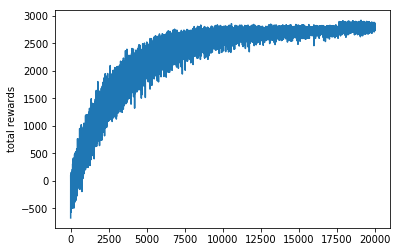

In [16]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

In [17]:
# Average reward per 100 episode
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 100:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[-193.19, -71.4, 6.7, 69.84, 182.68, 299.27, 366.65, 464.41, 529.81, 617.89, 683.02, 743.45, 821.31, 878.89, 972.36, 1016.66, 1088.72, 1095.04, 1183.8, 1167.81, 1304.96, 1328.43, 1379.78, 1367.21, 1445.3, 1522.36, 1533.08, 1602.25, 1593.58, 1660.5, 1657.14, 1673.9, 1733.91, 1726.08, 1832.4, 1793.37, 1878.21, 1884.69, 1896.17, 1910.96, 1966.37, 1969.01, 1969.95, 2022.73, 2064.84, 2057.83, 2063.7, 2124.19, 2150.17, 2172.7, 2150.63, 2169.52, 2205.83, 2207.24, 2241.26, 2261.91, 2262.2, 2294.77, 2287.56, 2337.6, 2323.99, 2327.4, 2367.36, 2394.08, 2381.1, 2391.88, 2378.43, 2398.06, 2437.44, 2424.45, 2432.12, 2450.84, 2464.57, 2484.94, 2477.26, 2484.41, 2479.57, 2521.54, 2535.41, 2530.25, 2542.37, 2557.09, 2555.66, 2561.55, 2562.28, 2553.48, 2577.65, 2600.7, 2581.16, 2569.36, 2576.22, 2593.51, 2626.65, 2623.33, 2625.29, 2631.17, 2642.36, 2626.88, 2632.11, 2643.78, 2642.74, 2671.84, 2662.69, 2647.11, 2655.5, 2665.8, 2665.17, 2660.2, 2668.96, 2669.79, 2672.05, 2696.88, 2686.92, 2691.98, 2690.01

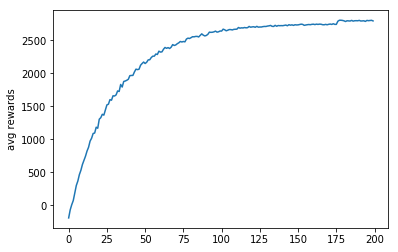

In [18]:
## Check Convergence by tracking average rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("avg rewards")
plt.show()

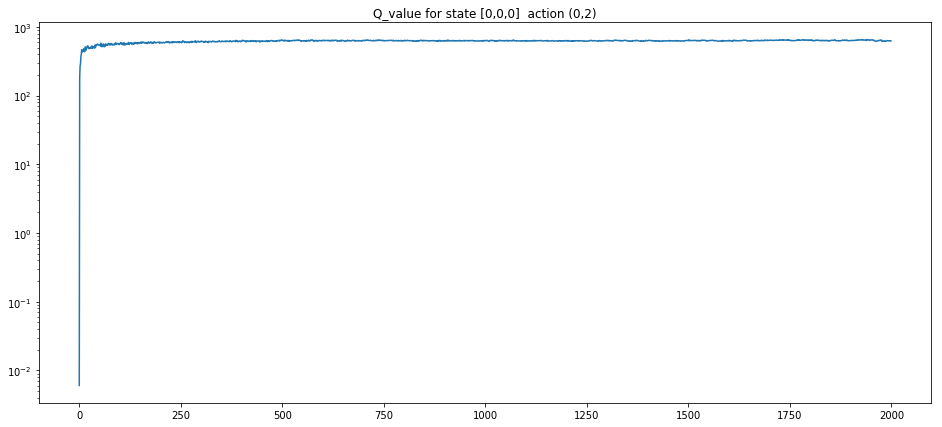

In [19]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [14]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0003*i))

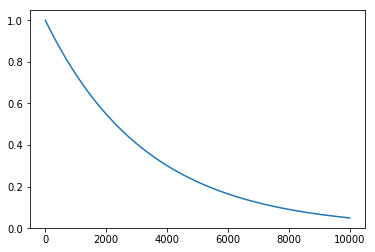

In [15]:
plt.plot(time, epsilon)
plt.show()